# Advertisement Campaign Analysis

The goal of the research is campaign efficiency evaluation. To achieve this goal we will explore the provided datasets, identify patterns in how socio-demographics influence media consumption, build a predictive model to understand drivers of purchases, and present actionable insights.

**Datasets  information**:
* Dataset `socio_demos` – socio demographics for each individual from the sample. There is also a weight column representing each individual's share of the total population for the country.
* Dataset `media_contacts` – number of times each individual in the sample was exposed to the advertisement on various media channels. There is also a column indicating if the individual has purchased the advertised product.

Each individual row in the dataset represents a large group of people so we need to try and preserve as much data as possible.

## Imports, Settings and Constants

In [1]:
import warnings
import math

# Analytical and Visualization Tools
import pandas as pd
import numpy as np
import phik
from phik.report import plot_correlation_matrix

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    StratifiedKFold,
)

# Imputation Model
from catboost import CatBoostRegressor
from sklearn.metrics import (
    root_mean_squared_error, 
    mean_absolute_error, 
    r2_score
)

# Classification Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score, 
    roc_auc_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
)

import optuna

In [2]:
# Configure settings
%config InlineBackend.figure_format = "retina"
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")

In [3]:
# Declare constants
RANDOM_STATE = 42
RESEARCH_DATE = "2025-01-20"
COLOR = "#59a590"

In [4]:
def plot_categorical_feature(data, column, 
                             binary=False, binary_x_labels=None, 
                             size=(6,6), x_text=None):
    """
    Function for plotting categorical feature distribution (counterplot).
    
    Parameters:
    - data: pandas Dataframe, data source.
    - column: pandas Series that contains categorical feature.
    - binary: boolean, default False, switcher for binary/non-binary features.
    - binary_x_labels: list, default None, list of descriptive category names.
    - size: set, default (6,6), figure size.
    - x_text: str, default None, custom text for x axis label.
    """
    
    fig, ax = plt.subplots(figsize=size)
    
    sns.countplot(
        data=data, 
        x=column, 
        ax=ax, 
        color=COLOR
    )
    
    ax.set_title(
        f"Distribution of the \"{column}\" feature",
        fontweight="semibold")
    
    ax.set_ylabel("Number of people")

    if x_text:
        ax.set_xlabel(x_text)
    else:
        ax.set_xlabel(column)

    if binary:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(binary_x_labels)
    
    total = len(data)
    
    for p in ax.patches:
        absolute_value = p.get_height()
        percentage = (absolute_value / total) * 100
        
        ax.annotate(f"{absolute_value:.0f} ({percentage:.1f}%)",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha="center", va="bottom")
        
    plt.show()

In [5]:
def plot_numeric_feature(data, column, size=(8, 5)):
    """
    Function for plotting numeric feature distribution (boxplot, histogram).

    Parameters:
    - data: pandas Dataframe, data source.
    - column: pandas Series that contains numeric feature.
    - size: set, default (8,5), figure size.
    """

    fig = plt.figure(figsize=size, constrained_layout=True)
    grid = fig.add_gridspec(nrows=2, ncols=3, wspace=0.2)
    plt.suptitle(f"Feature \"{column}\"", y=1.08, fontsize=12, fontweight="semibold")

    ax1 = fig.add_subplot(grid[:, 0])
    ax1 = sns.boxplot(data[column], color=COLOR)
    ax1.set_title("Box Plot")

    ax2 = fig.add_subplot(grid[0, 1:])
    ax2 = sns.histplot(data[column], color=COLOR, alpha=1.0, bins=20)
    ax2.set_title("Histogram of the feature distribution")

    ax3 = fig.add_subplot(grid[1, 1:])
    ax3.axis("off")
    description = data[column].describe().round(2).to_string()
    ax3.text(0, 0.04, description, fontsize=10, family="monospace")
    ax3.set_title("Descriptive statistics", y=0.75)

    plt.show()

In [6]:
def calculate_metrics_cv(model, X, y, cv):
    """
    Function for cross-validation with F1, Presicion and Recall scoring.

    Parameters:
    - model: fitted model object.
    - X: pd.DataFrame with input features.
    - y: pd.Series with target feature.
    - cv: int or cross-validation object, default 5.

    Returns:
    - f1_mean: mean F1 score of the folds.
    - precision_mean: mean precision score of the folds.
    - recall_mean: mean recall score of the folds.
    """
    
    f1_by_folds = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring="f1"
    ).round(4)
    f1_mean = f1_by_folds.mean().round(4)

    precision_by_folds = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring="precision"
    ).round(4)
    precision_mean = precision_by_folds.mean().round(4)

    recall_by_folds = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring="recall"
    ).round(4)
    recall_mean = recall_by_folds.mean().round(4)
    
    print(f"F1:        {f1_by_folds}, mean = {f1_mean}")
    print(f"Precision: {precision_by_folds}, mean = {precision_mean}")
    print(f"Recall:    {recall_by_folds}, mean = {recall_mean}")
    
    return f1_mean, precision_mean, recall_mean

## Data Loading and Preprocessing

In this section, we will load the datasets, and examine their structure to understand the type of data we are working with. We will handle duplicates, missing values and incorrect data types. We will also highlight any potential issues or inconsistencies in the data.

### Dataset `socio_demos`

**Overview**

In [7]:
# Read dataset with socio-demographics from file
data_people = pd.read_csv("data/socio_demos.csv")

In [8]:
data_people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15854 entries, 0 to 15853
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Person ID            15854 non-null  int64  
 1   weight               15854 non-null  object 
 2   BIRTHDAY             15850 non-null  float64
 3   Gender               15851 non-null  object 
 4   Number_of children   15852 non-null  object 
 5   People_in_Household  15851 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 743.3+ KB


In [9]:
# Format column names as snake_case
data_people.columns = [(col
                        .strip()
                        .lower()
                        .replace(" ", "_")
                       ) for col in data_people.columns]

# Rename columns
data_people.rename(columns=
                   {
                       "number_of_children": "children",
                       "people_in_household": "household"
                   }, 
                   inplace=True
                  )

In [10]:
# Show first 10 rows
data_people.head(10)

person_id    weight    birthday  gender    children       household
0    5326201  11032.10  19971001.0    male           0            2-HH
1     256895   2581.77  19730701.0  female           0            2-HH
2    7894945   8219.48  19870201.0    male     1 child            3-HH
3     797459   6040.79  19870401.0    male  2 Children            4-HH
4    5529182  11635.16  19971001.0    male           0            2-HH
5      17687  13456.38  19980401.0  female           0            2-HH
6   62098432   3881.71  19870201.0  female           0  1 -HH (female)
7   56489362   3993.45  19730501.0  female           0            2-HH
8     275140   6353.90  19341201.0    male           0     1-HH (male)
9  666280698   2966.01  19560501.0    male           0            2-HH

In [11]:
# Find rows with any missing values
data_people[data_people.isna().any(axis=1)]

person_id    weight    birthday  gender children    household
1839      687413    #NULL!  19750601.0     NaN        0         3-HH
13125     780080   2501.33  19680601.0     NaN        0  1-HH (male)
13566     254715   2930.96         NaN    male        0         2-HH
13702      67318   8121.38         NaN     NaN      NaN          NaN
13841       7740   6495.48  19600701.0  female      NaN         2-HH
14003     240737   2654.62         NaN  female        0         2-HH
14113   69889135  16996.26  19921101.0  female        0          NaN
14403  823783216    718.05         NaN  female        0         2-HH
14564        322   4169.16  19520501.0  female        0          NaN

**Observations:**
* One row doesn't have any information about the customer and will not be useful for our research. We can safely remove this row.
* We need to ensure that the `person_id` column contains only unique values.
* There are missing values in the columns `birthday`, `gender`, `children` and `household`.
* We can extract numeric values and convert the `children` and `household` columns into the int data type.
* For `children`, we can assume that missing value represents 0 children.
* For `household`, we can use weighted mode imputation after we extract numeric information.
* For `gender`, we can extract information from the `household` feature if possible, or use weighted mode imputation.
* The `weight` column is of type object, but it should contain only numeric values. We see an incorrect input of type str (#NULL!).
* The `birthday` column is of type float because of its format and missing values. We don't need the exact dates for modelling, but we can extract an `age` feature from it. Then for `age`, we can impute missing values with weighted mean.
* Due to the nature of the data (each row represents a group of people rather than a single person) we need to be careful with any imputations.

In [12]:
# Remove the rows missing data in 4+ columns
data_people = data_people.loc[data_people.isna().sum(axis=1) < 4]

**Duplicates Check**

First, we will check the dataset for duplicate rows.

In [13]:
# Count complete duplicates
data_people.duplicated().sum()

np.int64(0)

Next, we will check for duplicates in the `person_id` column.

In [14]:
# Check duplicated "person_id"
data_people.duplicated(subset=["person_id"]).sum()

np.int64(97)

In [15]:
# Filter out duplicates only
duplicates_people = (
    data_people[data_people.duplicated(subset=["person_id"], keep=False)]
    .sort_values(by="person_id")
)
duplicates_people

person_id    weight    birthday  gender children       household
1930          52   1695.06  19400301.0  female        0            2-HH
12326         52   2915.84  19380301.0    male        0     1-HH (male)
11355        162   1527.30  19611101.0  female        0            2-HH
3279         162   3738.80  19610101.0    male        0            2-HH
6902         322    #NULL!  19631001.0    male        0     1-HH (male)
...          ...       ...         ...     ...      ...             ...
5049       95361  13100.99  19831101.0  female        0  1 -HH (female)
603        97987   6678.95  19680401.0    male        0            4-HH
7752       97987   2649.14  19750801.0  female        0  1 -HH (female)
5975      723919   6131.39  19920601.0    male  1 child            3-HH
15534     723919    #NULL!  19521101.0  female        0  1 -HH (female)

[194 rows x 6 columns]

The data in the rows with duplicate `person_id` is different. We suspect that this is an input error. **We will handle duplicates just before merging two datasets.**

**Correcting Data Types**

We will extract the `age` feature from `birthday`. The column is of float type because of its numeric format (yyyymmdd) and present missing values. To avoid any incorrect values in the column, we will first transform it into DateTime type.

In [16]:
# Change data type for "birthday"
data_people["birthday"] = data_people["birthday"].astype("int", errors="ignore")
data_people["birthday"] = pd.to_datetime(data_people["birthday"], format="%Y%m%d", errors="coerce")
print(data_people["birthday"].min())
print(data_people["birthday"].max())

1924-12-01 00:00:00
2007-12-01 00:00:00


In [17]:
# Extract "age"
data_people["age"] = ((pd.to_datetime(RESEARCH_DATE) - data_people["birthday"])
                      .dt.days // 365)

# Delete "birthday"
data_people.drop(columns=["birthday"], inplace=True)

We need to extract numeric values from `children` and `household` features. We will use regular expressions (helper - https://regex101.com/).

In [18]:
# Check values in "children"
data_people["children"].value_counts()

children
0             14755
1 child         868
2 Children      213
3 Kinder         16
Name: count, dtype: int64

In [19]:
# Extract numbers
data_people["children"] = data_people["children"].str.extract(r"(\d)")
data_people["children"] = pd.to_numeric(data_people["children"], errors="coerce")

# Check the result
data_people["children"].value_counts(dropna=False)

children
0.0    14755
1.0      868
2.0      213
3.0       16
NaN        1
Name: count, dtype: int64

In [20]:
# Check values in "household"
data_people["household"].value_counts(dropna=False)

household
2-HH              6848
1 -HH (female)    2546
1-HH (male)       2368
3-HH              2021
4-HH              1528
5-HH               420
6-HH                92
7-HH                24
8-HH                 2
NaN                  2
10-HH                1
9-HH                 1
Name: count, dtype: int64

We don't need to keep the separation between 1-HH (female) and 1-HH (male): it is redundant because we have the `gender` column. But we will create a temporary column with extracted male/female information to validate or fill in missing data in the `gender` column.

In [21]:
# Extract gender information
data_people["gender_temp"] = data_people["household"].str.extract(r"(male|female)")
data_people[["household", "gender_temp"]].head(10)

household gender_temp
0            2-HH         NaN
1            2-HH         NaN
2            3-HH         NaN
3            4-HH         NaN
4            2-HH         NaN
5            2-HH         NaN
6  1 -HH (female)      female
7            2-HH         NaN
8     1-HH (male)        male
9            2-HH         NaN

In [22]:
# Extract numbers
data_people["household"] = data_people["household"].str.extract(r"(\d)")
data_people["household"] = pd.to_numeric(data_people["household"], errors="coerce")

# Check the result
data_people["household"].value_counts(dropna=False)

household
2.0    6848
1.0    4915
3.0    2021
4.0    1528
5.0     420
6.0      92
7.0      24
8.0       2
NaN       2
9.0       1
Name: count, dtype: int64

**Missing Values**

Let's start preprocessing with the `weight` column. We have already seen that this column contains incorect input.

In [23]:
# Identify non-numeric values in "weight"
data_people["weight_temp"] = pd.to_numeric(data_people["weight"].str.strip(), errors="coerce")
non_num_values = data_people[data_people["weight_temp"].isna()]["weight"].value_counts()
non_num_values

weight
#NULL!    2713
Name: count, dtype: int64

In [24]:
# Replace incorrect value and delete temporary column
data_people.loc[data_people["weight_temp"].isna(), "weight"] = np.nan
data_people["weight"] = data_people["weight"].astype("float")
data_people.drop(columns=["weight_temp"], inplace=True)

We identified an incorrect value in the weight column, which accounts for approximately 17% of the values in this column.

The `weight` parameter is crucial for market research as it represents the share of the population that each sampled individual corresponds to. It ensures that the sample data is accurately scaled to reflect the entire population. Without this parameter, the analysis would lose its ability to represent the population effectively, leading to biased or unreliable insights. However, since the incorrect values make up 17% of the dataset, removing these rows would result in a significant loss of data.

Let's **test the hypothesis** that we can impute missing values in the `weight` column using a predictive model trained on other socio-demographic parameters. If this approach doesn't work out, we will assume that the `weight` is missing because the group of people was too small (or even just 1 person).

In [25]:
# Prepare data for imputation model training
train_data = (
    data_people[~data_people["weight"].isna()]
    .drop(columns=["person_id", "gender_temp"])
    .dropna(subset=["gender", "children", "household", "age"])
)

X_train, X_val, y_train, y_val = train_test_split(
    train_data.drop(columns=["weight"]),
    train_data["weight"],
    random_state=RANDOM_STATE
)

X_test = (
    data_people[data_people["weight"].isna()]
    .drop(columns=["weight", "person_id", "gender_temp"])
)

In [26]:
# Train imputation model
imputation_model = CatBoostRegressor(
    random_state=RANDOM_STATE,
    cat_features=["gender"], 
    verbose=0
)

imputation_model.fit(X_train, y_train)
y_pred = imputation_model.predict(X_val)

r2 = r2_score(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
print(f"R2={r2:.2f}")
print(f"RMSE={rmse:.0f}")
print(f"MAE={mae:.0f}")

R2=0.45
RMSE=3820
MAE=2215


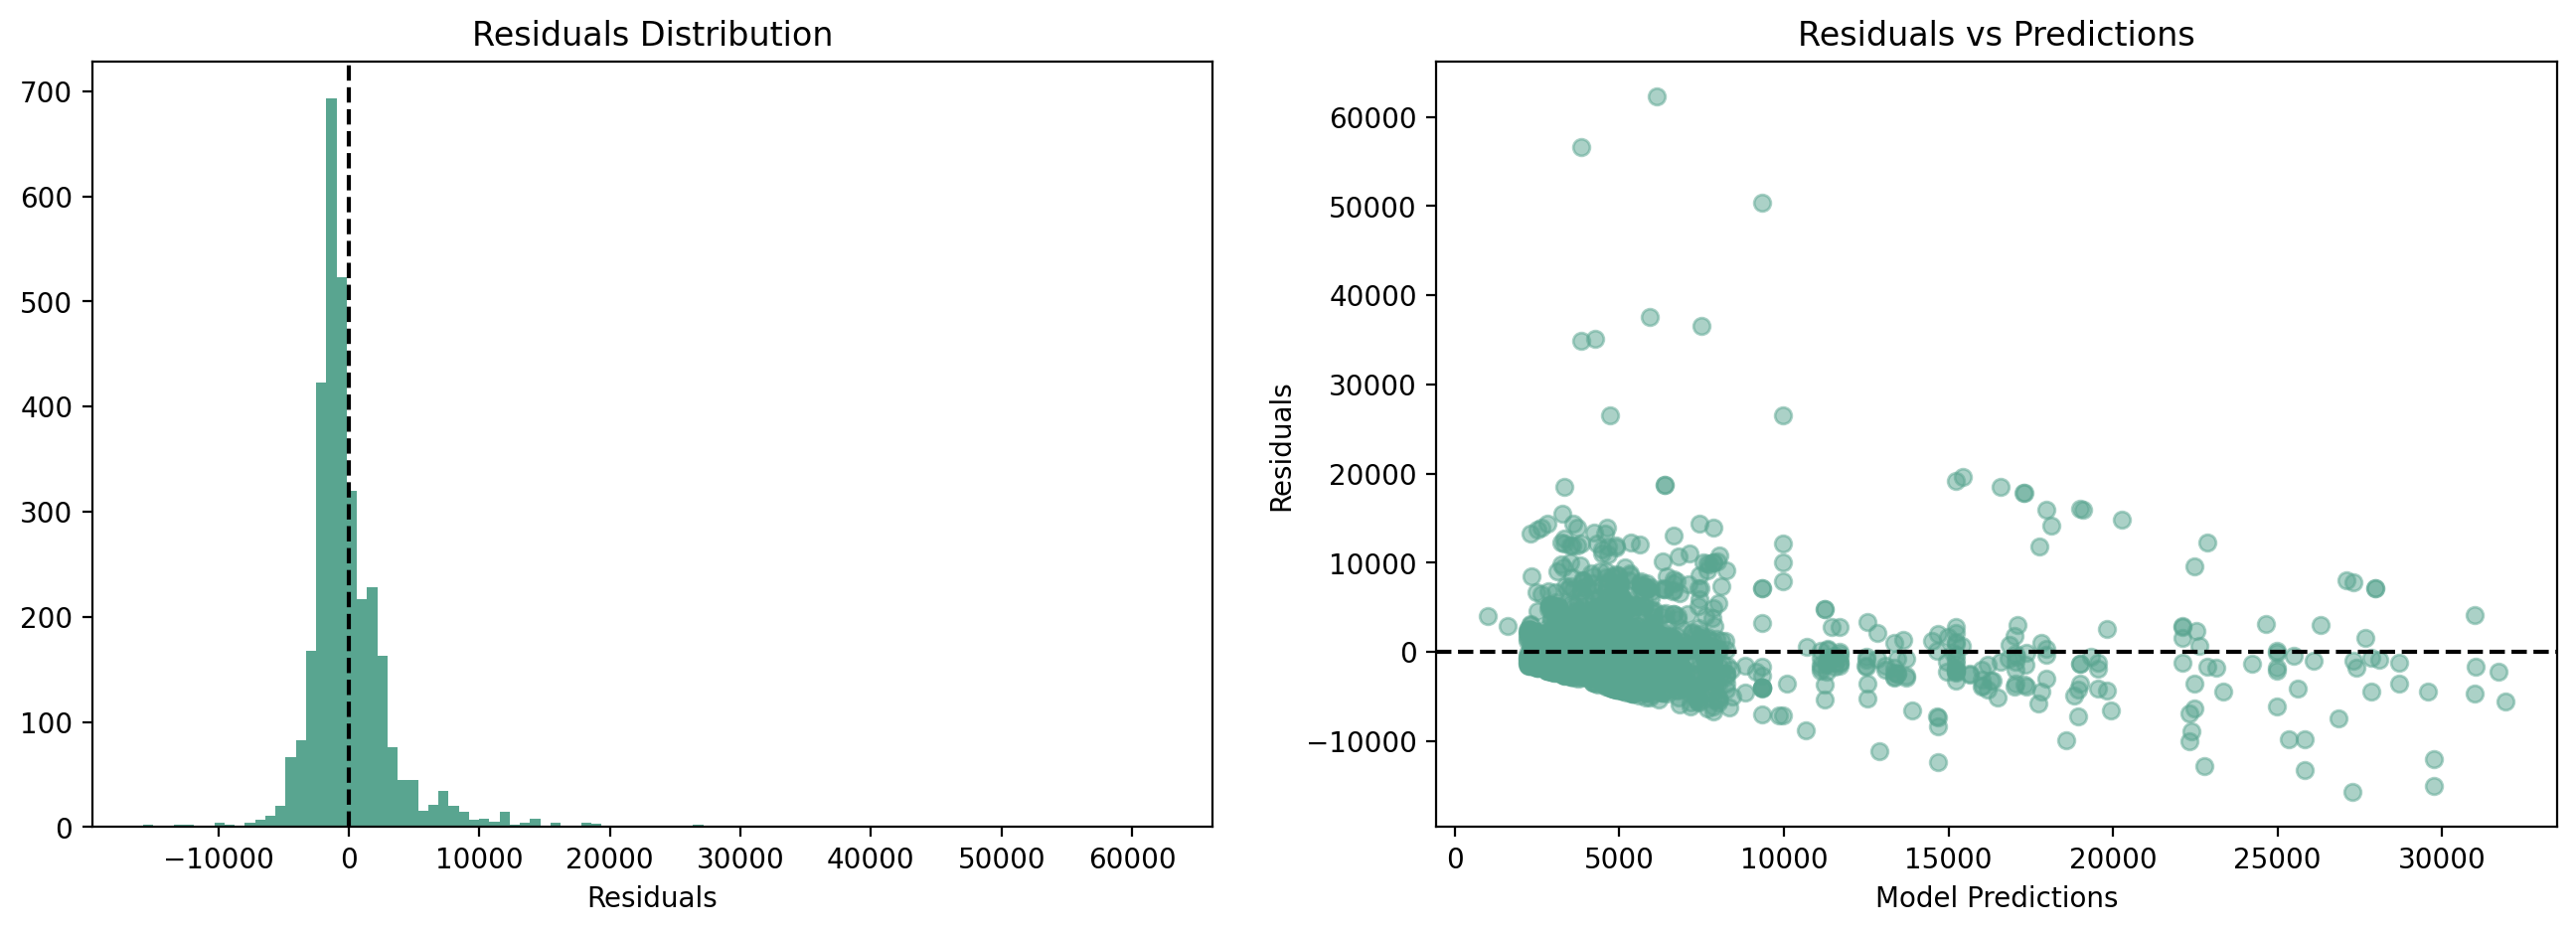

In [27]:
# Calculate the residuals
residuals = y_val - y_pred

# Visualize residual analysus
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
axes[0].set_title("Residuals Distribution")
axes[0].axvline(0, linestyle="--", color="black")
axes[0].hist(x=residuals, bins=100, color=COLOR)
axes[0].set_xlabel("Residuals")
axes[1].set_title("Residuals vs Predictions")
axes[1].scatter(x=y_pred, y=residuals, color=COLOR, alpha=0.5)
axes[1].axhline(0, linestyle="--", color="black")
axes[1].set_xlabel("Model Predictions")
axes[1].set_ylabel("Residuals")
plt.show()

The results from this predictive model are unusable. In some cases, the model assigns predicted weights that are up to 10 times higher than the actual values. Given these inaccuracies, we will not use this or any other model for imputing missing `weight` values. Instead, we will assign a value 1 to the corrupted rows.

Additionally, it is important **to inform the customer about the presence of corrupted data.**

In [28]:
# Replace missing "weight" with 1
data_people.loc[data_people["weight"].isna(), "weight"] = 1

In [29]:
# Calculate total weight
total_weight = data_people["weight"].sum()
print(f"total_weight = {total_weight:.0f}")

total_weight = 70536591


Let's look at the `gender` column.

In [30]:
# Check column values
data_people["gender"].value_counts(dropna=False)

gender
male      8330
female    7521
NaN          2
Name: count, dtype: int64

In [31]:
# Show rows with missing values
data_people[data_people["gender"].isna()]

person_id   weight gender  children  household   age gender_temp
1839      687413     1.00    NaN       0.0        3.0  49.0         NaN
13125     780080  2501.33    NaN       0.0        1.0  56.0        male

We will use extracted from the `household` column information to fill in one of the missing values. The other missing value we will replace with weighted mode.

In [32]:
# Replace missing values with extracted info
data_people.loc[(
    (data_people["gender"].isna())
    & (~data_people["gender_temp"].isna())
), "gender"] = data_people["gender_temp"]

In [33]:
# Delete temporary column
data_people.drop(columns=["gender_temp"], inplace=True)

In [34]:
# Calculate gender weights
weight_male = data_people[data_people["gender"]=="female"]["weight"].sum()
print(f"weight_male = {weight_male:.0f}")

weight_female = data_people[data_people["gender"]=="male"]["weight"].sum()
print(f"weight_female = {weight_female:.0f}")

weight_male = 34783984
weight_female = 35752606


In [35]:
# Replace missing values with weighted mode
data_people.loc[data_people["gender"].isna(), "gender"] = "female"

This is a binary feature. We can convert it to type int, where 0 represents "male" and 1 represents "female".

In [36]:
# Convert data type
data_people["gender"] = np.where(data_people["gender"] == "male", 0, 1)

# Check the result
data_people["gender"].value_counts(dropna=False)

gender
0    8331
1    7522
Name: count, dtype: int64

Let's fill in missing values in the `children` column. We assume that missing values represent "0 children".

In [37]:
# Impute missing values in "children" with 0
data_people["children"] = data_people["children"].fillna(0).astype("int")

# Check the result
data_people["children"].value_counts(dropna=False)

children
0    14756
1      868
2      213
3       16
Name: count, dtype: int64

Now, let's preprocess the `age` column.

In [38]:
# Show rows with missing values
data_people[data_people["age"].isna()]

person_id   weight  gender  children  household  age
13566     254715  2930.96       0         0        2.0  NaN
14003     240737  2654.62       1         0        2.0  NaN
14403  823783216   718.05       1         0        2.0  NaN

In [39]:
# Replace missing values with weighted mean
age_weighted_mean = (data_people["age"] * data_people["weight"]).sum() / total_weight
age_weighted_mean = round(age_weighted_mean, 0)
print(f"Mean age (weighted): {age_weighted_mean}")

data_people.loc[data_people["age"].isna(), "age"] = age_weighted_mean

Mean age (weighted): 52.0


Now, let's preprocess the `household` column.

In [40]:
# Show rows with missing values
data_people[data_people["household"].isna()]

person_id    weight  gender  children  household   age
14113   69889135  16996.26       1         0        NaN  32.0
14564        322   4169.16       1         0        NaN  72.0

In [41]:
# Replace missing values with weighted mean
hh_weighted_mean = (data_people["household"] * data_people["weight"]).sum() / total_weight
hh_weighted_mean = round(hh_weighted_mean, 0)
print(f"Mean household size (weighted): {hh_weighted_mean}")

data_people.loc[data_people["household"].isna(), "household"] = hh_weighted_mean

Mean household size (weighted): 2.0


**Intermediate Result**

Let's check the result of the `data_people` dataset preprocessing.

In [42]:
data_people.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15853 entries, 0 to 15853
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   person_id  15853 non-null  int64  
 1   weight     15853 non-null  float64
 2   gender     15853 non-null  int64  
 3   children   15853 non-null  int64  
 4   household  15853 non-null  float64
 5   age        15853 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 1.4 MB


In [43]:
data_people.head()

person_id    weight  gender  children  household   age
0    5326201  11032.10       0         0        2.0  27.0
1     256895   2581.77       1         0        2.0  51.0
2    7894945   8219.48       0         1        3.0  37.0
3     797459   6040.79       0         2        4.0  37.0
4    5529182  11635.16       0         0        2.0  27.0

Now we move on to the second dataset.

### Dataset `media_contacts`

**Overview**

In [44]:
# Read dataset with media contacts from file
data_media = pd.read_csv("data/media_contacts.csv")

In [45]:
data_media.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15854 entries, 0 to 15853
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PERSON ID        15854 non-null  int64  
 1   TV_Total         15854 non-null  float64
 2   FLYERS           15854 non-null  float64
 3   Print_Total      15854 non-null  float64
 4   Online_Video     15853 non-null  float64
 5   Online_Display   15852 non-null  float64
 6   Online Total     15853 non-null  float64
 7   TikTok           15850 non-null  float64
 8   YouTube_Total    15851 non-null  float64
 9   YouTube_Mobile   15852 non-null  float64
 10  YouTube_Desktop  15853 non-null  float64
 11  YouTube_Tablet   15851 non-null  float64
 12  YouTube CTV      15853 non-null  float64
 13  Pinterest        15854 non-null  float64
 14  Purchase         15854 non-null  int64  
dtypes: float64(13), int64(2)
memory usage: 1.8 MB


In [46]:
# Format column names as snake_case
data_media.columns = [(col
                        .strip()
                        .lower()
                        .replace(" ", "_")
                       ) for col in data_media.columns]

In [47]:
# Show first 10 rows
data_media.head(10)

person_id  tv_total  flyers  print_total  online_video  online_display  \
0    5326201       0.0     0.0          0.0          10.0             4.0   
1     256895       0.0     0.0          1.0           0.0             0.0   
2    7894945       4.0     0.0          0.0           0.0             0.0   
3     797459       0.0     0.0          0.0          11.0             2.0   
4    5529182       0.0     0.0          0.0           7.0             3.0   
5      17687       0.0     0.0          0.0           0.0             0.0   
6   62098432       4.0     0.0          0.0           6.0             5.0   
7   56489362       3.0     0.0          0.0           9.0             6.0   
8     275140       0.0     0.0          1.0           0.0             0.0   
9  666280698      81.0     3.0          1.0           0.0             0.0   

   online_total  tiktok  youtube_total  youtube_mobile  youtube_desktop  \
0          14.0     0.0            0.0             0.0              0.0   
1           0.0     0.0            2.0             0.0              2.0   
2           0.0     0.0            1.0             0.0              0.0   
3          13.0     0.0            1.0             1.0              0.0   
4          10.0     0.0            0.0             0.0              0.0   
5           0.0     0.0            0.0             0.0              0.0   
6          11.0     0.0            1.0             1.0              0.0   
7          15.0     0.0            2.0             0.0              0.0   
8           0.0     0.0            0.0             0.0              0.0   
9           0.0     0.0            0.0             0.0              0.0   

   youtube_tablet  youtube_ctv  pinterest  purchase  
0             0.0          0.0        0.0         1  
1             0.0          0.0        0.0         1  
2             1.0          0.0        0.0         1  
3             0.0          0.0       25.0         1  
4             0.0          0.0        0.0         0  
5             0.0          0.0        0.0         0  
6             0.0          0.0        0.0         1  
7             2.0          0.0        3.0         1  
8             0.0          0.0        0.0         0  
9             0.0          0.0        0.0         1

In [48]:
# Find rows with any missing values
data_media[data_media.isna().any(axis=1)]

person_id  tv_total  flyers  print_total  online_video  online_display  \
237      4102455       3.0     0.0          1.0           0.0             0.0   
295    683019135      18.0     0.0          0.0           NaN             0.0   
334       420352       0.0     0.0          0.0           0.0             0.0   
537       798896       1.0     0.0          1.0           0.0             NaN   
7027   871569245       0.0     0.0          0.0           0.0             0.0   
7040      791520       0.0     0.0          0.0           0.0             NaN   
7467      534695       3.0     0.0          0.0           0.0             0.0   
7470      163081       0.0     0.0          0.0           0.0             0.0   
13649     323767       0.0     0.0          0.0           0.0             0.0   

       online_total  tiktok  youtube_total  youtube_mobile  youtube_desktop  \
237             0.0     0.0            NaN             0.0              0.0   
295             0.0     0.0            1.0             0.0              1.0   
334             0.0     NaN            0.0             0.0              0.0   
537             NaN     NaN            NaN             NaN              NaN   
7027            0.0     0.0            NaN             NaN              0.0   
7040            0.0     0.0            0.0             0.0              0.0   
7467            0.0     0.0            0.0             0.0              0.0   
7470            0.0     NaN            1.0             0.0              1.0   
13649           0.0     NaN            1.0             1.0              0.0   

       youtube_tablet  youtube_ctv  pinterest  purchase  
237               0.0          0.0        0.0         1  
295               0.0          0.0        0.0         1  
334               0.0          NaN        0.0         1  
537               NaN          0.0        0.0         0  
7027              0.0          0.0        0.0         1  
7040              0.0          0.0        0.0         1  
7467              NaN          0.0        0.0         0  
7470              0.0          0.0        0.0         0  
13649             NaN          0.0        0.0         0

**Observations:**
* We need to ensure that the `person_id` column contains only unique values.
* The dataset contains our target - `purchase`. We need to see the distribution of the target and decide wheter we need to handle imbalance or not.
* There are 1-4 missing values in the most columns. We can assume that missing values represent 0 (no contact through that channel).
* We need to ensure that the `x_total` columns actually contain the sum of the values of the related columns.

**Duplicates Check**

First, we will check the dataset for duplicate rows.

In [49]:
# Count complete duplicates
data_media.duplicated().sum()

np.int64(7)

Next, we will check for duplicates in the `person_id` column.

In [50]:
# Check duplicated "person_id"
data_media.duplicated(subset=["person_id"]).sum()

np.int64(97)

In [51]:
# Filter out duplicates only
duplicates_media = (
    data_media[data_media.duplicated(subset=["person_id"], keep=False)]
    .sort_values(by="person_id")
)
duplicates_media

person_id  tv_total  flyers  print_total  online_video  online_display  \
1930          52       1.0     0.0          1.0           0.0             0.0   
12326         52       7.0     0.0          2.0           0.0             0.0   
11355        162       2.0     0.0          1.0           0.0             0.0   
3279         162       1.0     0.0          1.0           1.0             0.0   
6902         322       4.0     0.0          0.0           0.0             0.0   
...          ...       ...     ...          ...           ...             ...   
5049       95361      19.0     0.0          0.0           0.0             0.0   
603        97987       3.0     0.0          2.0           0.0             0.0   
7752       97987      17.0     2.0          0.0           0.0             0.0   
5975      723919       6.0     1.0          0.0           0.0             0.0   
15534     723919       0.0     0.0          0.0           0.0             0.0   

       online_total  tiktok  youtube_total  youtube_mobile  youtube_desktop  \
1930            0.0     0.0            0.0             0.0              0.0   
12326           0.0     0.0            0.0             0.0              0.0   
11355           0.0     0.0            0.0             0.0              0.0   
3279            1.0     0.0            0.0             0.0              0.0   
6902            0.0     0.0            0.0             0.0              0.0   
...             ...     ...            ...             ...              ...   
5049            0.0     0.0            2.0             2.0              0.0   
603             0.0     0.0            1.0             1.0              0.0   
7752            0.0     0.0            1.0             1.0              0.0   
5975            0.0     0.0            0.0             0.0              0.0   
15534           0.0     0.0            0.0             0.0              0.0   

       youtube_tablet  youtube_ctv  pinterest  purchase  
1930              0.0          0.0        0.0         0  
12326             0.0          0.0        0.0         0  
11355             0.0          0.0        0.0         1  
3279              0.0          0.0        0.0         1  
6902              0.0          0.0        0.0         0  
...               ...          ...        ...       ...  
5049              0.0          0.0        0.0         1  
603               0.0          0.0        0.0         1  
7752              0.0          0.0        0.0         1  
5975              0.0          0.0        0.0         0  
15534             0.0          0.0        0.0         0  

[194 rows x 15 columns]

Just as before, the data differs, supporting our assumption of an input error. We will handle duplicates before merging the datasets.

**Missing Values and Sum Check**

We assume that missing values represent 0 (no contact through that channel).

In [52]:
# Impute missing values with 0
data_media = data_media.fillna(0).astype("int")

Now we will check `x_total` and their related columns.

In [53]:
# Check inconsistency in "online_total"
data_media["online_temp"] = data_media["online_video"] + data_media["online_display"]
wrong_sum = len(data_media[data_media["online_total"]!=data_media["online_temp"]])
print(wrong_sum)

0


In [54]:
# Check inconsistency in "youtube_total"
data_media["youtube_temp"] = (
    data_media["youtube_mobile"] 
    + data_media["youtube_desktop"] 
    + data_media["youtube_tablet"] 
    + data_media["youtube_ctv"]
)
wrong_sum = len(data_media[data_media["youtube_total"]!=data_media["youtube_temp"]])
print(wrong_sum)

0


In [55]:
# Delete temporary columns
data_media.drop(columns=["youtube_temp", "online_temp"], inplace=True)

**Intermediate Result**

Let's check the result of the `data_media` dataset preprocessing.

In [56]:
data_media.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15854 entries, 0 to 15853
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   person_id        15854 non-null  int64
 1   tv_total         15854 non-null  int64
 2   flyers           15854 non-null  int64
 3   print_total      15854 non-null  int64
 4   online_video     15854 non-null  int64
 5   online_display   15854 non-null  int64
 6   online_total     15854 non-null  int64
 7   tiktok           15854 non-null  int64
 8   youtube_total    15854 non-null  int64
 9   youtube_mobile   15854 non-null  int64
 10  youtube_desktop  15854 non-null  int64
 11  youtube_tablet   15854 non-null  int64
 12  youtube_ctv      15854 non-null  int64
 13  pinterest        15854 non-null  int64
 14  purchase         15854 non-null  int64
dtypes: int64(15)
memory usage: 1.8 MB


In [57]:
data_media.head()

person_id  tv_total  flyers  print_total  online_video  online_display  \
0    5326201         0       0            0            10               4   
1     256895         0       0            1             0               0   
2    7894945         4       0            0             0               0   
3     797459         0       0            0            11               2   
4    5529182         0       0            0             7               3   

   online_total  tiktok  youtube_total  youtube_mobile  youtube_desktop  \
0            14       0              0               0                0   
1             0       0              2               0                2   
2             0       0              1               0                0   
3            13       0              1               1                0   
4            10       0              0               0                0   

   youtube_tablet  youtube_ctv  pinterest  purchase  
0               0            0          0         1  
1               0            0          0         1  
2               1            0          0         1  
3               0            0         25         1  
4               0            0          0         0

### Merging Datasets

Before we merge the datasets, we need to handle duplicates. Visual analysis of the first 10 rows of our datasets showed that the indices in them might be identical for `person_id`. If we can confirm it, we can merge datasets on indices and delete the `person_id` column all together. Afterwards all we need to do is to double-check duplicate rows and delete them if needed.

Let's compare index-person_id pairs.

In [58]:
# Reset index to extract current index as a new feature
data_people_temp = data_people.copy(deep=True).reset_index(drop=False)
data_media_temp = data_media.copy(deep=True).reset_index(drop=False)

data_temp = data_people_temp[["index", "person_id"]].merge(
    data_media_temp[["index", "person_id"]], 
    on="index", 
    how="left", 
    suffixes=["_people", "_media"]
)
data_temp.head(10)

index  person_id_people  person_id_media
0      0           5326201          5326201
1      1            256895           256895
2      2           7894945          7894945
3      3            797459           797459
4      4           5529182          5529182
5      5             17687            17687
6      6          62098432         62098432
7      7          56489362         56489362
8      8            275140           275140
9      9         666280698        666280698

In [59]:
# Find rows where person_id are different
data_temp["different"] = np.where(data_temp["person_id_people"]!=data_temp["person_id_media"], 1, 0)

print(f"Number of different ids: {data_temp['different'].sum()}")

Number of different ids: 0


Our suggestion was correct. We can merge two DataFrames on their indices.

In [60]:
print(f"data_people size: {data_people.shape}")
print(f"data_media size: {data_media.shape}")

data_people size: (15853, 6)
data_media size: (15854, 15)


In [61]:
# Merge datesets on indices
data = (
    data_people
    .drop(columns="person_id")
    .join(data_media.drop(columns="person_id"), how="left")
)

In [62]:
data.head()

weight  gender  children  household   age  tv_total  flyers  print_total  \
0  11032.10       0         0        2.0  27.0         0       0            0   
1   2581.77       1         0        2.0  51.0         0       0            1   
2   8219.48       0         1        3.0  37.0         4       0            0   
3   6040.79       0         2        4.0  37.0         0       0            0   
4  11635.16       0         0        2.0  27.0         0       0            0   

   online_video  online_display  online_total  tiktok  youtube_total  \
0            10               4            14       0              0   
1             0               0             0       0              2   
2             0               0             0       0              1   
3            11               2            13       0              1   
4             7               3            10       0              0   

   youtube_mobile  youtube_desktop  youtube_tablet  youtube_ctv  pinterest  \
0               0                0               0            0          0   
1               0                2               0            0          0   
2               0                0               1            0          0   
3               1                0               0            0         25   
4               0                0               0            0          0   

   purchase  
0         1  
1         1  
2         1  
3         1  
4         0

Now we need to check duplicates. We will exclude `weight` as it might change (if we need to merge rows with identical behaviour).

In [63]:
# Check duplicates without weight
data.drop(columns=["weight"]).duplicated().sum()

np.int64(3637)

We will merge duplicated rows and calculate the sum of the weights in those rows.

In [64]:
# Merge duplicated rows and update their weights
columns_for_agg = data.drop(columns=["weight"]).columns.tolist()
data = data.groupby(columns_for_agg, as_index=False)["weight"].sum()

data.head()

gender  children  household   age  tv_total  flyers  print_total  \
0       0         0        1.0  23.0         0       0            0   
1       0         0        1.0  23.0         5       0            0   
2       0         0        1.0  24.0         0       0            0   
3       0         0        1.0  24.0         0       0            0   
4       0         0        1.0  24.0         3       0            0   

   online_video  online_display  online_total  tiktok  youtube_total  \
0             0               0             0       0              0   
1             0               0             0       0              0   
2             0               0             0       0              0   
3             0               0             0       0              0   
4             0               0             0       0              0   

   youtube_mobile  youtube_desktop  youtube_tablet  youtube_ctv  pinterest  \
0               0                0               0            0          0   
1               0                0               0            0          0   
2               0                0               0            0          0   
3               0                0               0            0          0   
4               0                0               0            0          0   

   purchase    weight  
0         1      1.00  
1         0  10126.39  
2         0  10127.39  
3         1      1.00  
4         1  13120.28

In [65]:
# Check duplicates
data.duplicated().sum()

np.int64(0)

In [66]:
# Check columns with constant values
data.nunique().sort_values()

gender                2
purchase              2
flyers                4
children              4
youtube_desktop       9
household             9
youtube_tablet       10
tiktok               10
youtube_ctv          13
online_display       14
youtube_mobile       15
youtube_total        15
online_video         18
print_total          21
online_total         23
pinterest            52
tv_total             79
age                  84
weight             2611
dtype: int64

In [67]:
print(f"data size: {data.shape}")

data size: (12216, 19)


In [68]:
# Calculate total weight
total_weight = data["weight"].sum()
print(f"total_weight = {total_weight:.0f}")

total_weight = 70536591


In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12216 entries, 0 to 12215
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           12216 non-null  int64  
 1   children         12216 non-null  int64  
 2   household        12216 non-null  float64
 3   age              12216 non-null  float64
 4   tv_total         12216 non-null  int64  
 5   flyers           12216 non-null  int64  
 6   print_total      12216 non-null  int64  
 7   online_video     12216 non-null  int64  
 8   online_display   12216 non-null  int64  
 9   online_total     12216 non-null  int64  
 10  tiktok           12216 non-null  int64  
 11  youtube_total    12216 non-null  int64  
 12  youtube_mobile   12216 non-null  int64  
 13  youtube_desktop  12216 non-null  int64  
 14  youtube_tablet   12216 non-null  int64  
 15  youtube_ctv      12216 non-null  int64  
 16  pinterest        12216 non-null  int64  
 17  purchase    

In [70]:
# Show the result
data.head(10)

gender  children  household   age  tv_total  flyers  print_total  \
0       0         0        1.0  23.0         0       0            0   
1       0         0        1.0  23.0         5       0            0   
2       0         0        1.0  24.0         0       0            0   
3       0         0        1.0  24.0         0       0            0   
4       0         0        1.0  24.0         3       0            0   
5       0         0        1.0  24.0         5       0            0   
6       0         0        1.0  24.0        12       0            0   
7       0         0        1.0  25.0         0       0            0   
8       0         0        1.0  25.0         0       0            0   
9       0         0        1.0  25.0         0       0            0   

   online_video  online_display  online_total  tiktok  youtube_total  \
0             0               0             0       0              0   
1             0               0             0       0              0   
2             0               0             0       0              0   
3             0               0             0       0              0   
4             0               0             0       0              0   
5             0               0             0       0              0   
6             0               0             0       0              0   
7             0               0             0       0              0   
8             0               0             0       0              0   
9             2               0             2       0              0   

   youtube_mobile  youtube_desktop  youtube_tablet  youtube_ctv  pinterest  \
0               0                0               0            0          0   
1               0                0               0            0          0   
2               0                0               0            0          0   
3               0                0               0            0          0   
4               0                0               0            0          0   
5               0                0               0            0          0   
6               0                0               0            0          0   
7               0                0               0            0          0   
8               0                0               0            0          0   
9               0                0               0            0          0   

   purchase    weight  
0         1      1.00  
1         0  10126.39  
2         0  10127.39  
3         1      1.00  
4         1  13120.28  
5         0  10489.42  
6         1  13120.28  
7         0  24867.40  
8         1  10653.99  
9         0  10829.44

### Stage Results

**Dataset with socio-demographic information:**
* We deleted one row that had missing values in all the columns apart from `person_id`. This row had no value for our reserach.
* We created a new feature `age` based on the `birthday` column, the `birthday` column was deleted. 
* The `age` column inherited missing values from the `birthday` column. We replaced them with weighted mean age (52 years).
* We extracted numeric data from the `children` column and filled the missing values with 0, assuming that the missing values represent no children.
* We extracted numeric data from the `household` column and filled the missing values with weighted mean (2 people in the household).
* We also extracted gender related information from the `household` column and filled the missing values in the `gender` column where it was possible. The rest was filled with weighted mode (female). The feature was converted to type int, where 0 represents male, 1 represents female.
* We identified 2713 corrupted values in the `weight` column. The parameter is crucial for market research as it represents the share of the population that each sampled individual corresponds to. It ensures that the sample data is accurately scaled to reflect the entire population. Without this parameter, the analysis would lose its ability to represent the population effectively, leading to biased or unreliable insights. However, since the incorrect values make up 17% of the dataset, removing these rows would result in a significant loss of data. We attempted to impute the missing data with a regression model, but the results were not satisfactory. As a result, we decided to replace corrupted values with 1.

**Dataset with media contacts information:**
* We filled in missing values with 0, assuming that missing values represent no contact through those channels.
* We checked the consistency of `x_total` and their related columns. All sums are correct.

**Merged dataset:**
* We found duplicated `person_id` in each dataset, but the actual data in the rows was different. We made an assumption that this is an input error. We compared index-person_id pairs from both datasets and found out that indices are identical for each `person_id`. It allowed us to merge datasets on indices and drop `person_id` column as it is also useless for modelling purposes.
* We checked the resulting dataset for columns with constant values as such columns are not informative for ML models. There are no such columns in the dataset.
* We checked the dataset for duplicates (`weight` was excluded from the subset). It appeared that we had 3637 duplicate rows with different weights.
* Size of the resulting dataset is 12216 rows, 19 columns. **Even though it might seem that we lost a lot of data, in fact we preserved all but one row (the one that had missing data in all the columns) - total weight before and after the merge is 70'536'591. The size of the dataset shrank because we combined duplicated rows and updated the sum weights accordingly.**

## Exploratory Data Analysis

We will conduct EDA from two perspectives.

1) We will analyze each column individually as a potential feature for ML model development. This includes examining their distributions and relationships between the features.
2) We will look at the data through the lens of the `weight` parameter to find interesting business insights. 

### Business Insights

Before we start the exploration from the business perspective, we will create a copy of the dataset, because some of the features that we will create at this stage **might cause a target leakage and cannot be used for modelling purposes**.

In [71]:
# Create a copy of the dataset
data_bi = data.copy(deep=True)

In [72]:
# Create channel list
channel_columns = [
    "tv_total", "flyers", "print_total", "online_video", 
    "online_display", "online_total", "tiktok", 
    "youtube_total", "youtube_mobile", "youtube_desktop",
    "youtube_tablet", "youtube_ctv", "pinterest"
]

To make our conversion rate calculation by channel more accurate, we will create a binary feature `multi_channel` where 1 represents interaction with multiple channels, 0 represents interaction with only one channel.

In [73]:
# Add new features
data_bi["multi_channel"] = np.where(data_bi[channel_columns].gt(0).sum(axis=1) > 1, 1, 0)
data_bi["interactions_total"] = data_bi[channel_columns].sum(axis=1)

In [74]:
# Min and max age
print(data_bi["age"].min())
print(data_bi["age"].max())

17.0
100.0


In [75]:
# Age binning
bins = [0, 23, 31, 41, 51, 61, 71, float("inf")]
labels = [
    "17-22",
    "23-30", 
    "31-40", 
    "41-50", 
    "51-60", 
    "61-70", 
    "71+"
]
data_bi["age_bins"] = pd.cut(data_bi["age"], bins=bins, labels=labels, right=False)
data_bi["age_bins"].value_counts(dropna=False)

age_bins
51-60    2838
61-70    2498
41-50    2438
71+      2425
31-40    1467
23-30     400
17-22     150
Name: count, dtype: int64

#### Overall Conversion Rate

A conversion rate records the percentage of customers who have completed a desired action (purchase). Conversion rates are an effective way of comparing and contrasting the performance of multiple advertising channels.

In [76]:
# Calculate total population
total_exposure = (data_bi["interactions_total"] * data_bi["weight"]).sum()

In [77]:
# Overall Conversion Rate
overall_conversion_rate = (
    (data_bi["purchase"] * data_bi["weight"]).sum() 
    / total_exposure * 100
)

print(f"Overall CR: {overall_conversion_rate:.2f}%")

Overall CR: 5.11%


Conversion Rate for the product is 5.11%.

#### Conversion Rate by Channels

In [78]:
# Create dictionary to store CR data
conversion_rate_df_data = {}

In [79]:
# Conversion rate by channels
for channel in channel_columns:
    filtered_data = data_bi[(data_bi[channel]!=0) & (data_bi["multi_channel"]==0)]

    if len(filtered_data) != 0:
        population_exposed_to_channel = (
            filtered_data[channel] * filtered_data["weight"]
        ).sum()
        
        conversion_rate = (
            (filtered_data["purchase"] * filtered_data["weight"]).sum() 
            / population_exposed_to_channel * 100
        )
        conversion_rate_df_data[channel] = conversion_rate.round(1)
        print(f"CR {channel}: {conversion_rate:.2f}%")
    else:
        pass

CR tv_total: 4.03%
CR flyers: 13.50%
CR print_total: 9.20%
CR tiktok: 5.98%
CR pinterest: 3.33%


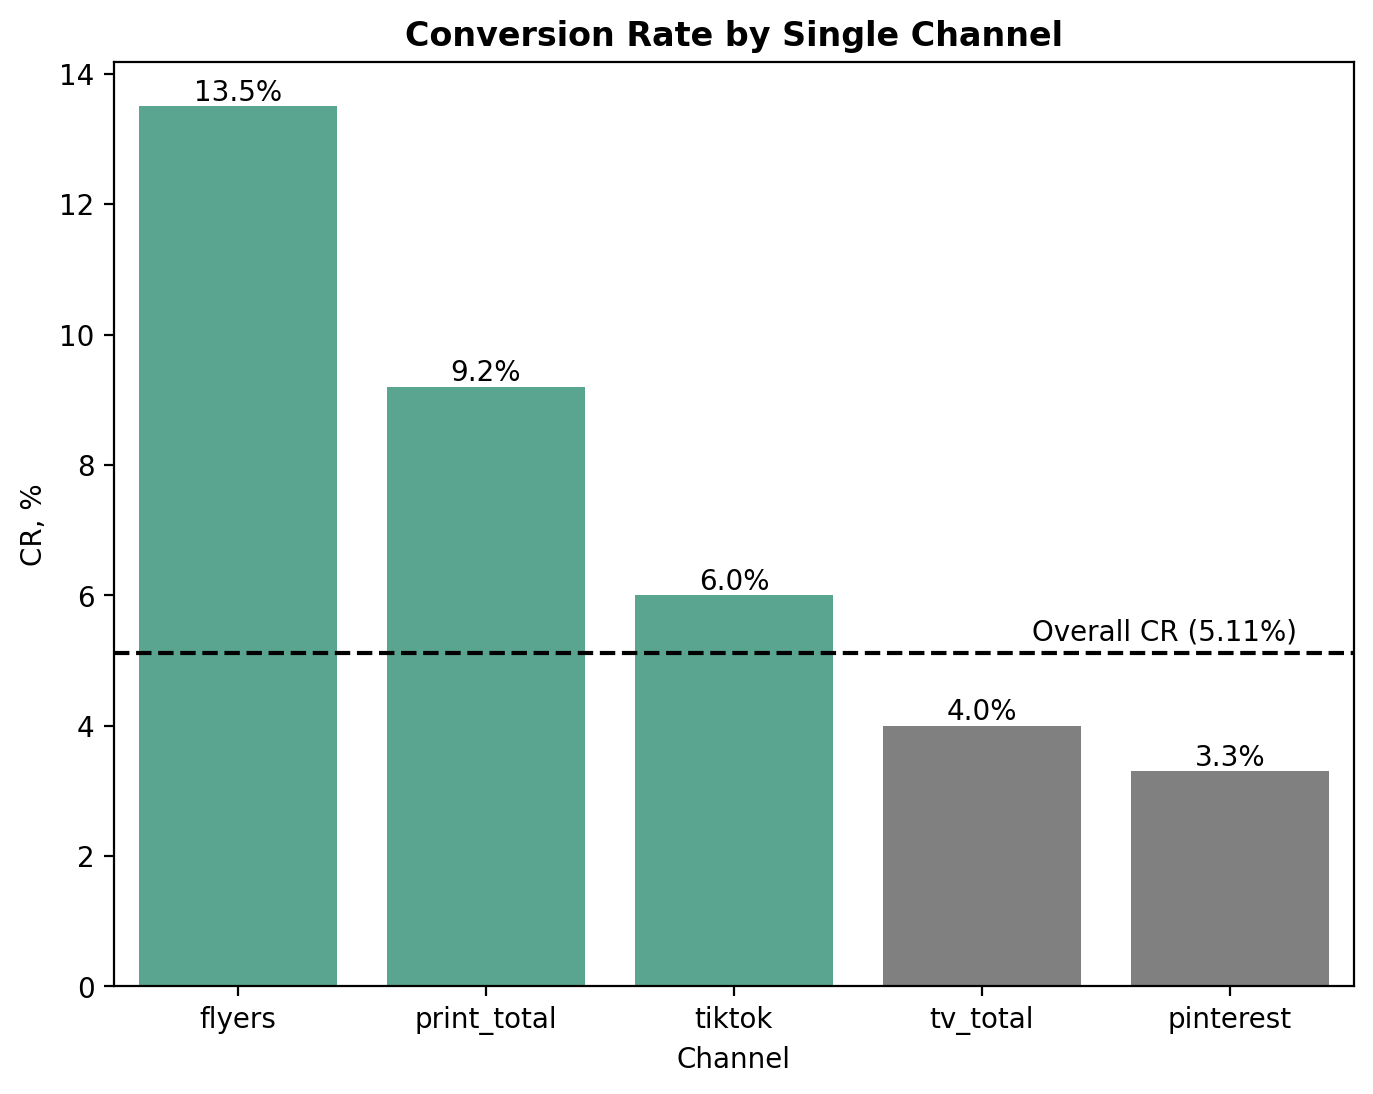

In [80]:
# Create DataFrame
conversion_rate_df = pd.DataFrame(
    list(conversion_rate_df_data.items()), 
    columns=["channel", "CR"]
)
conversion_rate_df.sort_values(by="CR", ascending=False, inplace=True)

# Plot CR information
plt.figure(figsize=(8,6))
ax = sns.barplot(conversion_rate_df, x="channel", y="CR", color="grey")
for p in ax.patches:
    if p.get_height() > overall_conversion_rate:
        p.set_facecolor(COLOR)
    ax.annotate(f"{p.get_height()}%",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", va="bottom")
plt.title("Conversion Rate by Single Channel", fontweight="semibold")
ax.set_xlabel("Channel")
ax.set_ylabel("CR, %")
ax.axhline(overall_conversion_rate, linestyle="--", color="black")
plt.text(x=3.2, y=overall_conversion_rate+0.2, s="Overall CR (5.11%)")
plt.show()

* There are 13 media channels in total. Only 5 of these channels were ever used independently, for which we calculated the conversion rate (CR) by channel. The channels with a CR higher than the overall CR are `flyers`, `print_total`, and `tiktok`.
* The `flyers` channel shows outstanding result of 13.5% conversion rate.
* Channels such as YouTube and Online were never used as standalone sources of information, so we are unable to evaluate their individual CR.

#### Channel Interactions by Age

In [81]:
# Create dictionaries to store channel data
channels_by_age_df_data = {}
channels_by_gender_df_data = {}

In [82]:
# Channels by age bins
channels_by_age_df_data = []
for channel in channel_columns:
    filtered_data = data_bi.loc[:, [channel, "age_bins", "weight"]]
    filtered_data["weighted_interactions"] = (
        filtered_data[channel] * filtered_data["weight"]
    )
    channel_agg = (
        filtered_data
        .groupby("age_bins", observed=False)["weighted_interactions"].sum()
    )
 
    channel_df = pd.DataFrame(channel_agg).T
    channel_df = (channel_df / 1000).round(2)
    channel_df["channel"] = channel
    
    channels_by_age_df_data.append(channel_df)

channels_by_age_df = pd.concat(channels_by_age_df_data).reset_index(drop=True)
channels_by_age_df.set_index("channel", inplace=True)
channels_by_age_df = channels_by_age_df.round(0).astype("int")
channels_by_age_df

age_bins         17-22  23-30  31-40  41-50   51-60   61-70    71+
channel                                                           
tv_total          6725  28648  50449  65722  106876  102717  81299
flyers            2165   2125   2486   4352    6568    6458   9551
print_total       2364   4449   7405   9351   10909    9256  10817
online_video       226   1917   2355   3118    2413    2436   1672
online_display     148   1122    948   1270    1333    1473    474
online_total       374   3039   3302   4388    3746    3910   2146
tiktok               0    513    442    360     812     656    507
youtube_total        0      0   8463  18971   12219       0      0
youtube_mobile       0      0   5200  10728    6029       0      0
youtube_desktop      0      0    504   1642    1589       0      0
youtube_tablet       0      0    825   1941    1580       0      0
youtube_ctv          0      0   1934   4661    3021       0      0
pinterest            0   1255   9803   8621   10513   11065   5666

In [83]:
# Calculate sum by channels
sum_by_channel = channels_by_age_df.sum(axis=1).sort_values(ascending=False)
sum_by_channel = sum_by_channel.to_frame()
sum_by_channel.columns = ["interactions"]
total_interactions = sum_by_channel["interactions"].sum()
sum_by_channel["percent"] = (sum_by_channel["interactions"] / total_interactions * 100).round(2)
sum_by_channel

interactions  percent
channel                               
tv_total               442436    63.02
print_total             54551     7.77
pinterest               46923     6.68
youtube_total           39653     5.65
flyers                  33705     4.80
youtube_mobile          21957     3.13
online_total            20905     2.98
online_video            14137     2.01
youtube_ctv              9616     1.37
online_display           6768     0.96
youtube_tablet           4346     0.62
youtube_desktop          3735     0.53
tiktok                   3290     0.47

In [84]:
# Calculate sum by age group
sum_by_age = channels_by_age_df.sum(axis=0).sort_values(ascending=False)
sum_by_age = sum_by_age.to_frame()
sum_by_age.columns = ["interactions"]
total_interactions = sum_by_age["interactions"].sum()
sum_by_age["percent"] = (sum_by_age["interactions"] / total_interactions * 100).round(2)
sum_by_age

interactions  percent
age_bins                       
51-60           167608    23.88
61-70           137971    19.65
41-50           135125    19.25
71+             112132    15.97
31-40            94116    13.41
23-30            43068     6.13
17-22            12002     1.71

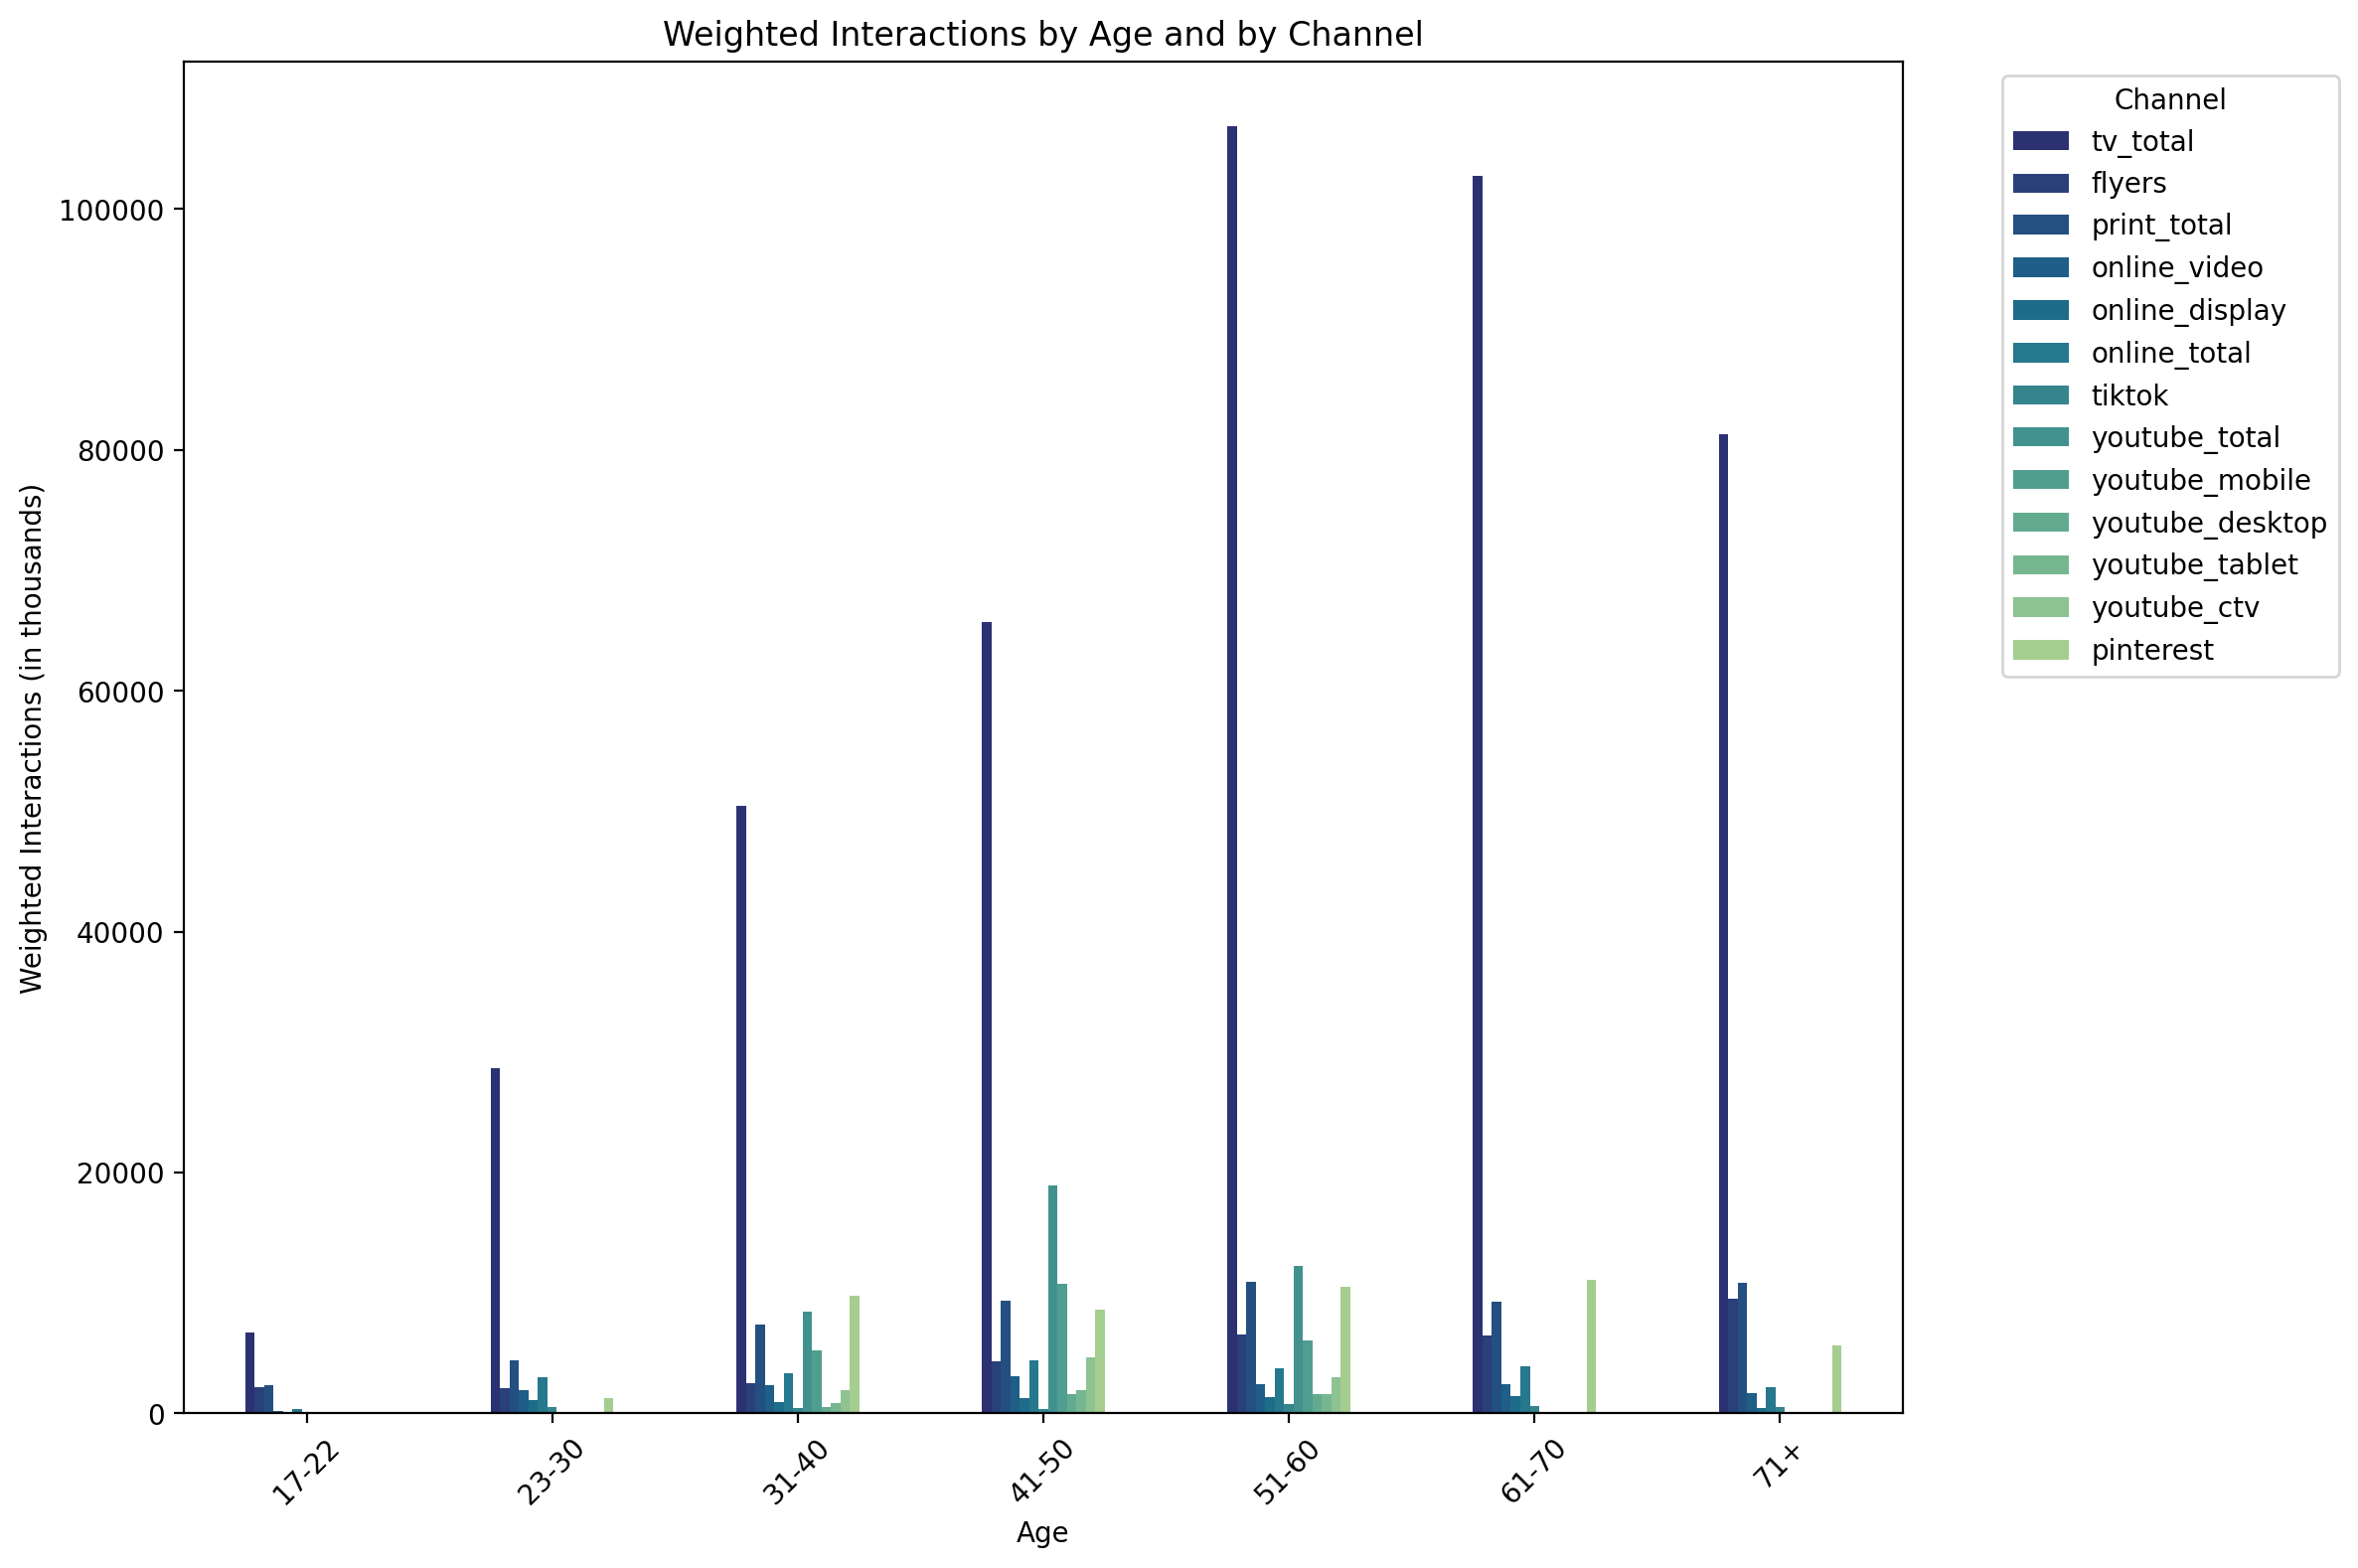

In [85]:
# Transponse for plotting
channels_by_age_df = channels_by_age_df.T

# Plot for interactions by channel and by age group
ax = channels_by_age_df.plot(
    kind="bar",
    stacked=False,
    figsize=(12, 8),
    colormap="crest_r",
    alpha=1
)

plt.title("Weighted Interactions by Age and by Channel")
plt.xlabel("Age")
plt.ylabel("Weighted Interactions (in thousands)")
plt.xticks(rotation=45)
plt.legend(title="Channel", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

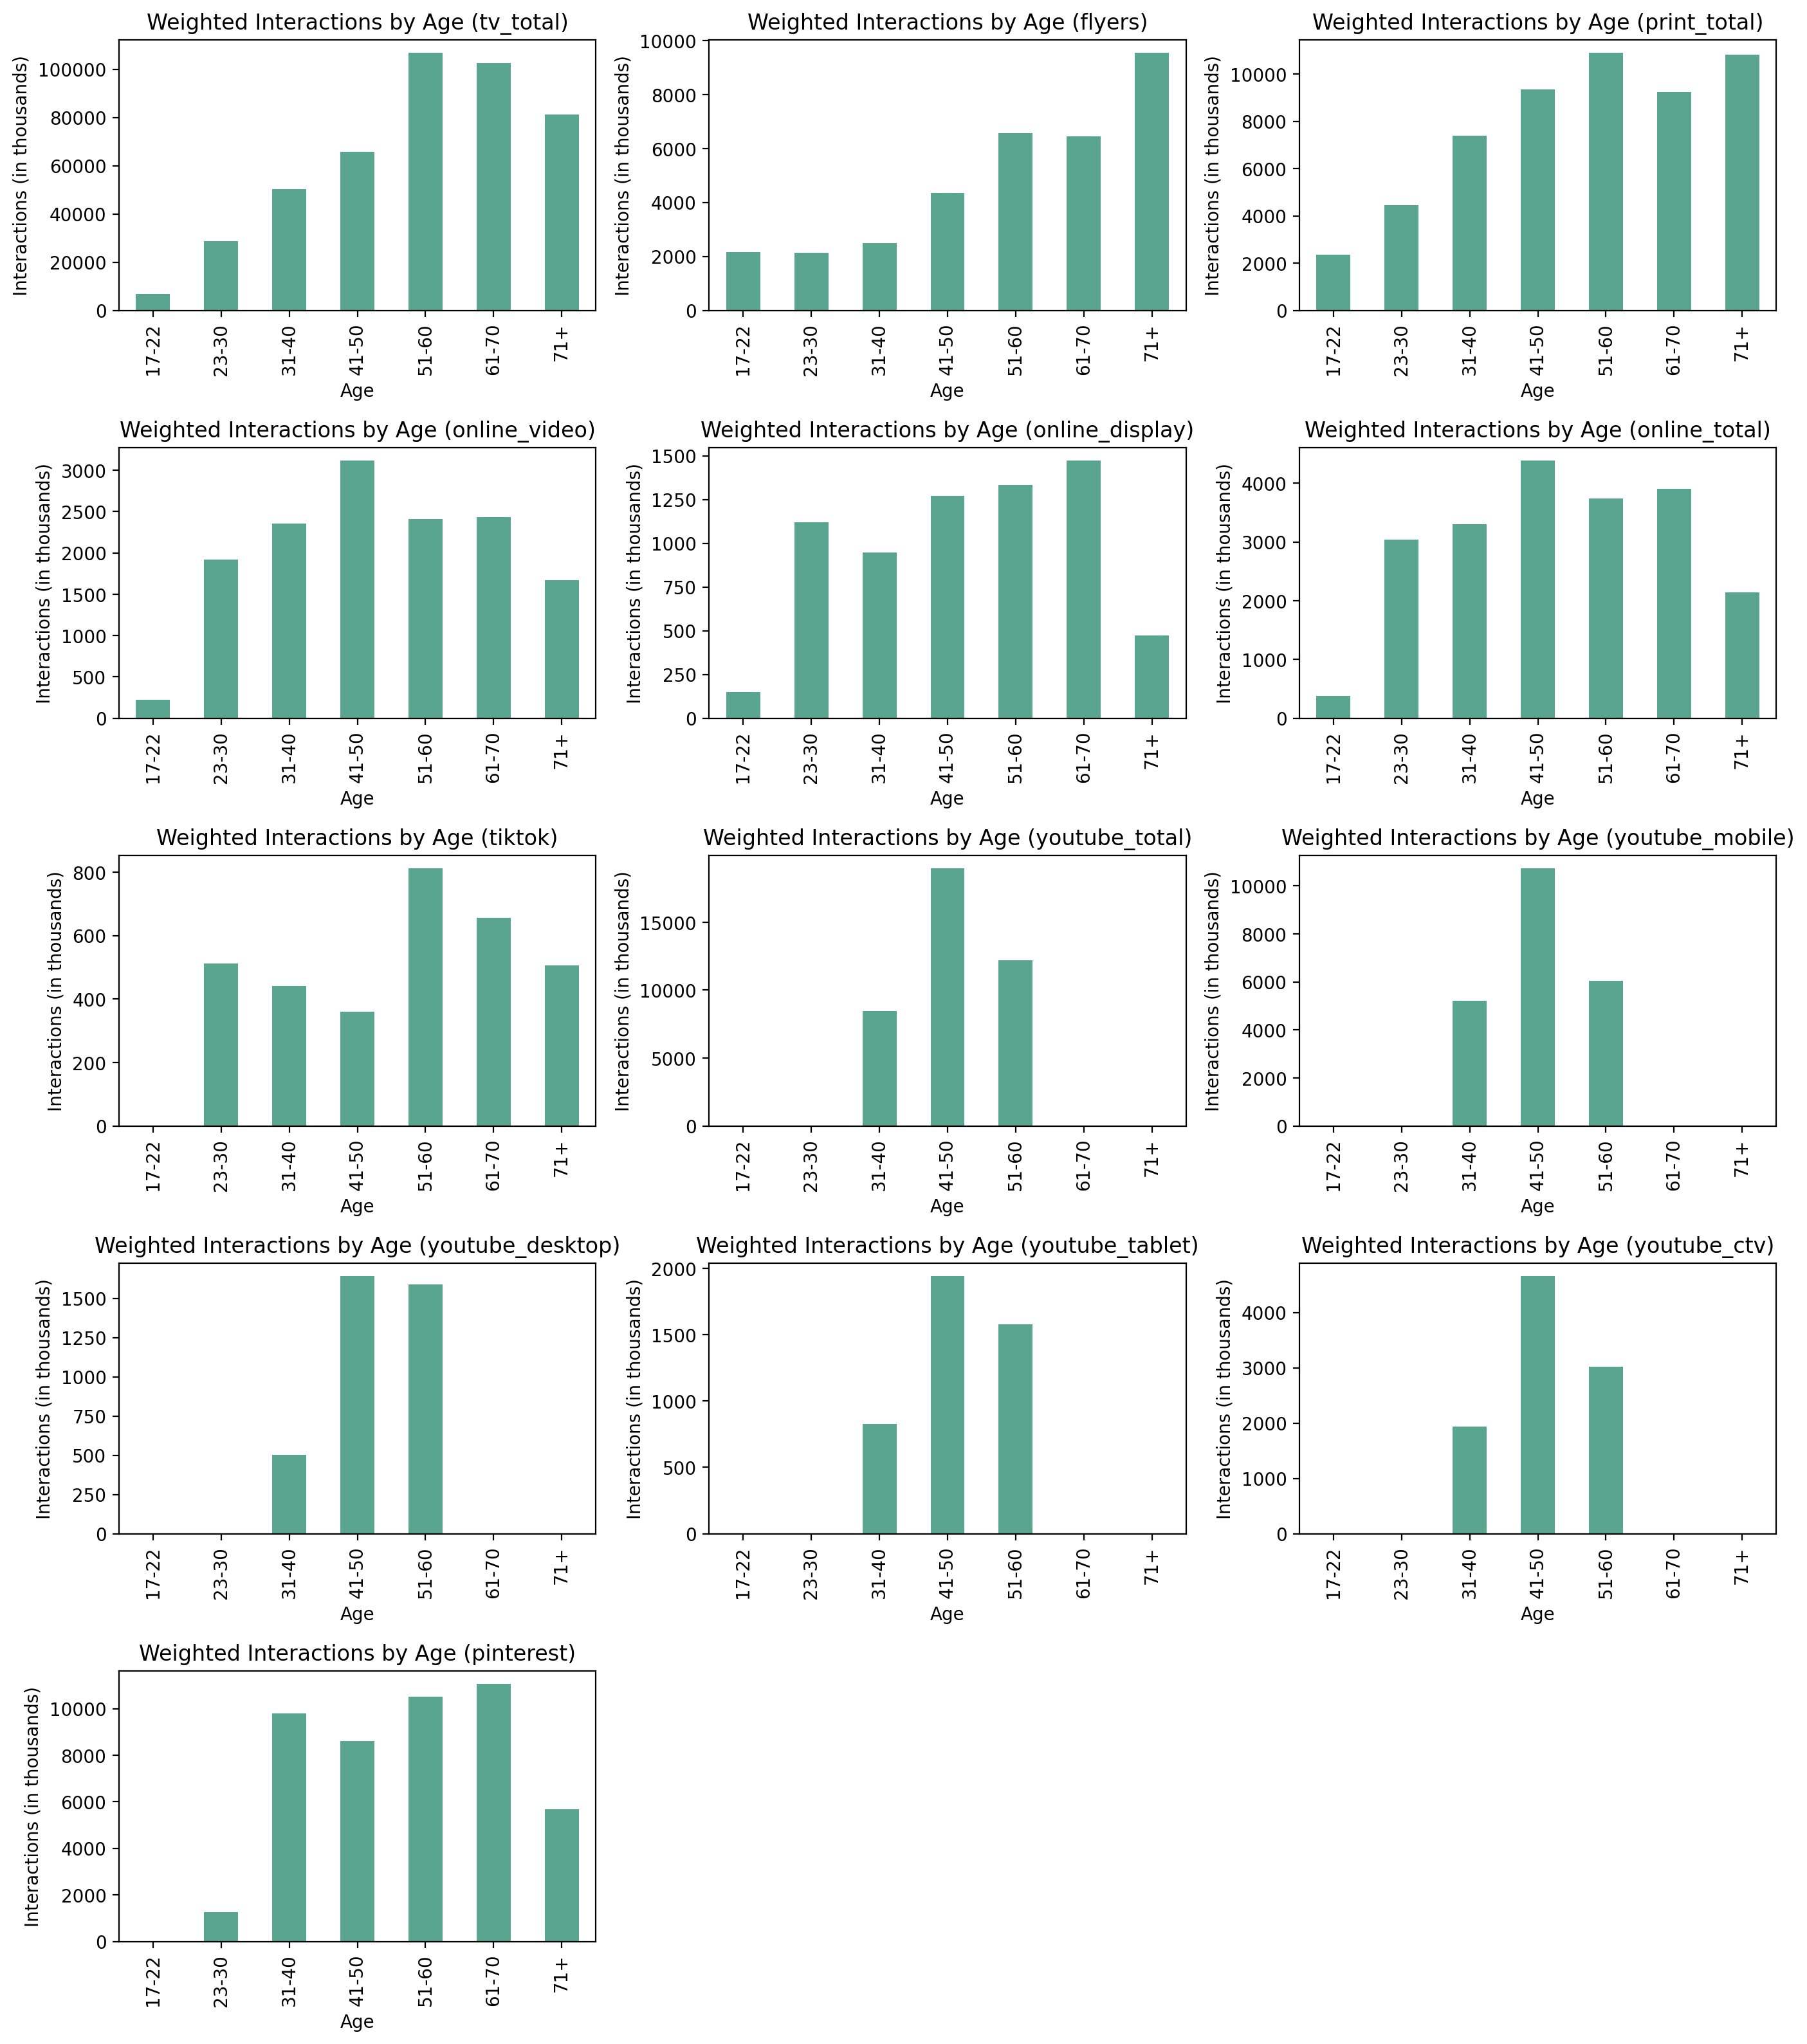

In [86]:
# Plots for every channel
fig, ax = plt.subplots(5, 3, figsize=(14, 16))
ax = ax.flatten()
for i, channel in enumerate(channels_by_age_df.columns.tolist()):
    channels_by_age_df[channel].plot(
        kind="bar",
        color=COLOR,
        alpha=1,
        ax=ax[i]
    )
    
    ax[i].set_title(f"Weighted Interactions by Age ({channel})")
    ax[i].set_xlabel("Age")
    ax[i].set_ylabel("Interactions (in thousands)")

for unused_index in range(len(channels_by_age_df.columns.tolist()), len(ax)):
    ax[unused_index].axis("off")
    
plt.tight_layout()
plt.show()

* TV is by far the most common way the company interacts with people (63% of all interactions).
* The second most popular channel is print (7.78% of interactions).
* Tiktok is the least popular channel to interact with potential customers (only 0.47% of all interactions).

#### Organic Customer Profile

Organic customers are the customers whose purchase decision was made independently of any marketing or advertising influence, often driven by factors such as prior knowledge of the product, word of mouth, brand loyalty, or other non-advertising-related reasons.

In [87]:
# Add new feature
data_bi["is_organic"] = np.where(
    (data_bi[channel_columns].sum(axis=1) == 0) & (data_bi["purchase"] == 1), 1, 0
)

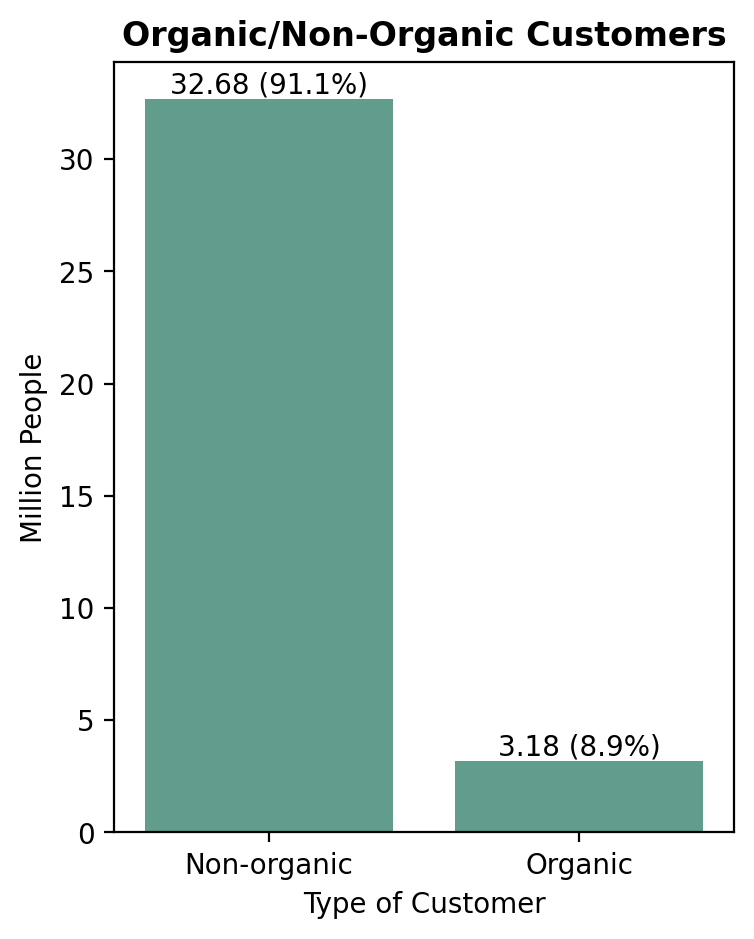

In [88]:
# Aggregate data by "is_organic"
filtered_data = data_bi[data_bi["purchase"]==1]
organic_agg = filtered_data.groupby("is_organic", as_index=False)["weight"].sum()
organic_agg["weight"] /= 1000000

plt.figure(figsize=(4,5))
ax = sns.barplot(organic_agg, x="is_organic", y="weight", color=COLOR)
for p in ax.patches:
    total = organic_agg["weight"].sum()
    absolute_value = p.get_height()
    percentage = (absolute_value / total) * 100
    ax.annotate(f"{absolute_value:.2f} ({percentage:.1f}%)",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", va="bottom")
plt.title("Organic/Non-Organic Customers", fontweight="semibold")
ax.set_xlabel("Type of Customer")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Non-organic", "Organic"])
ax.set_ylabel("Million People")
plt.show()

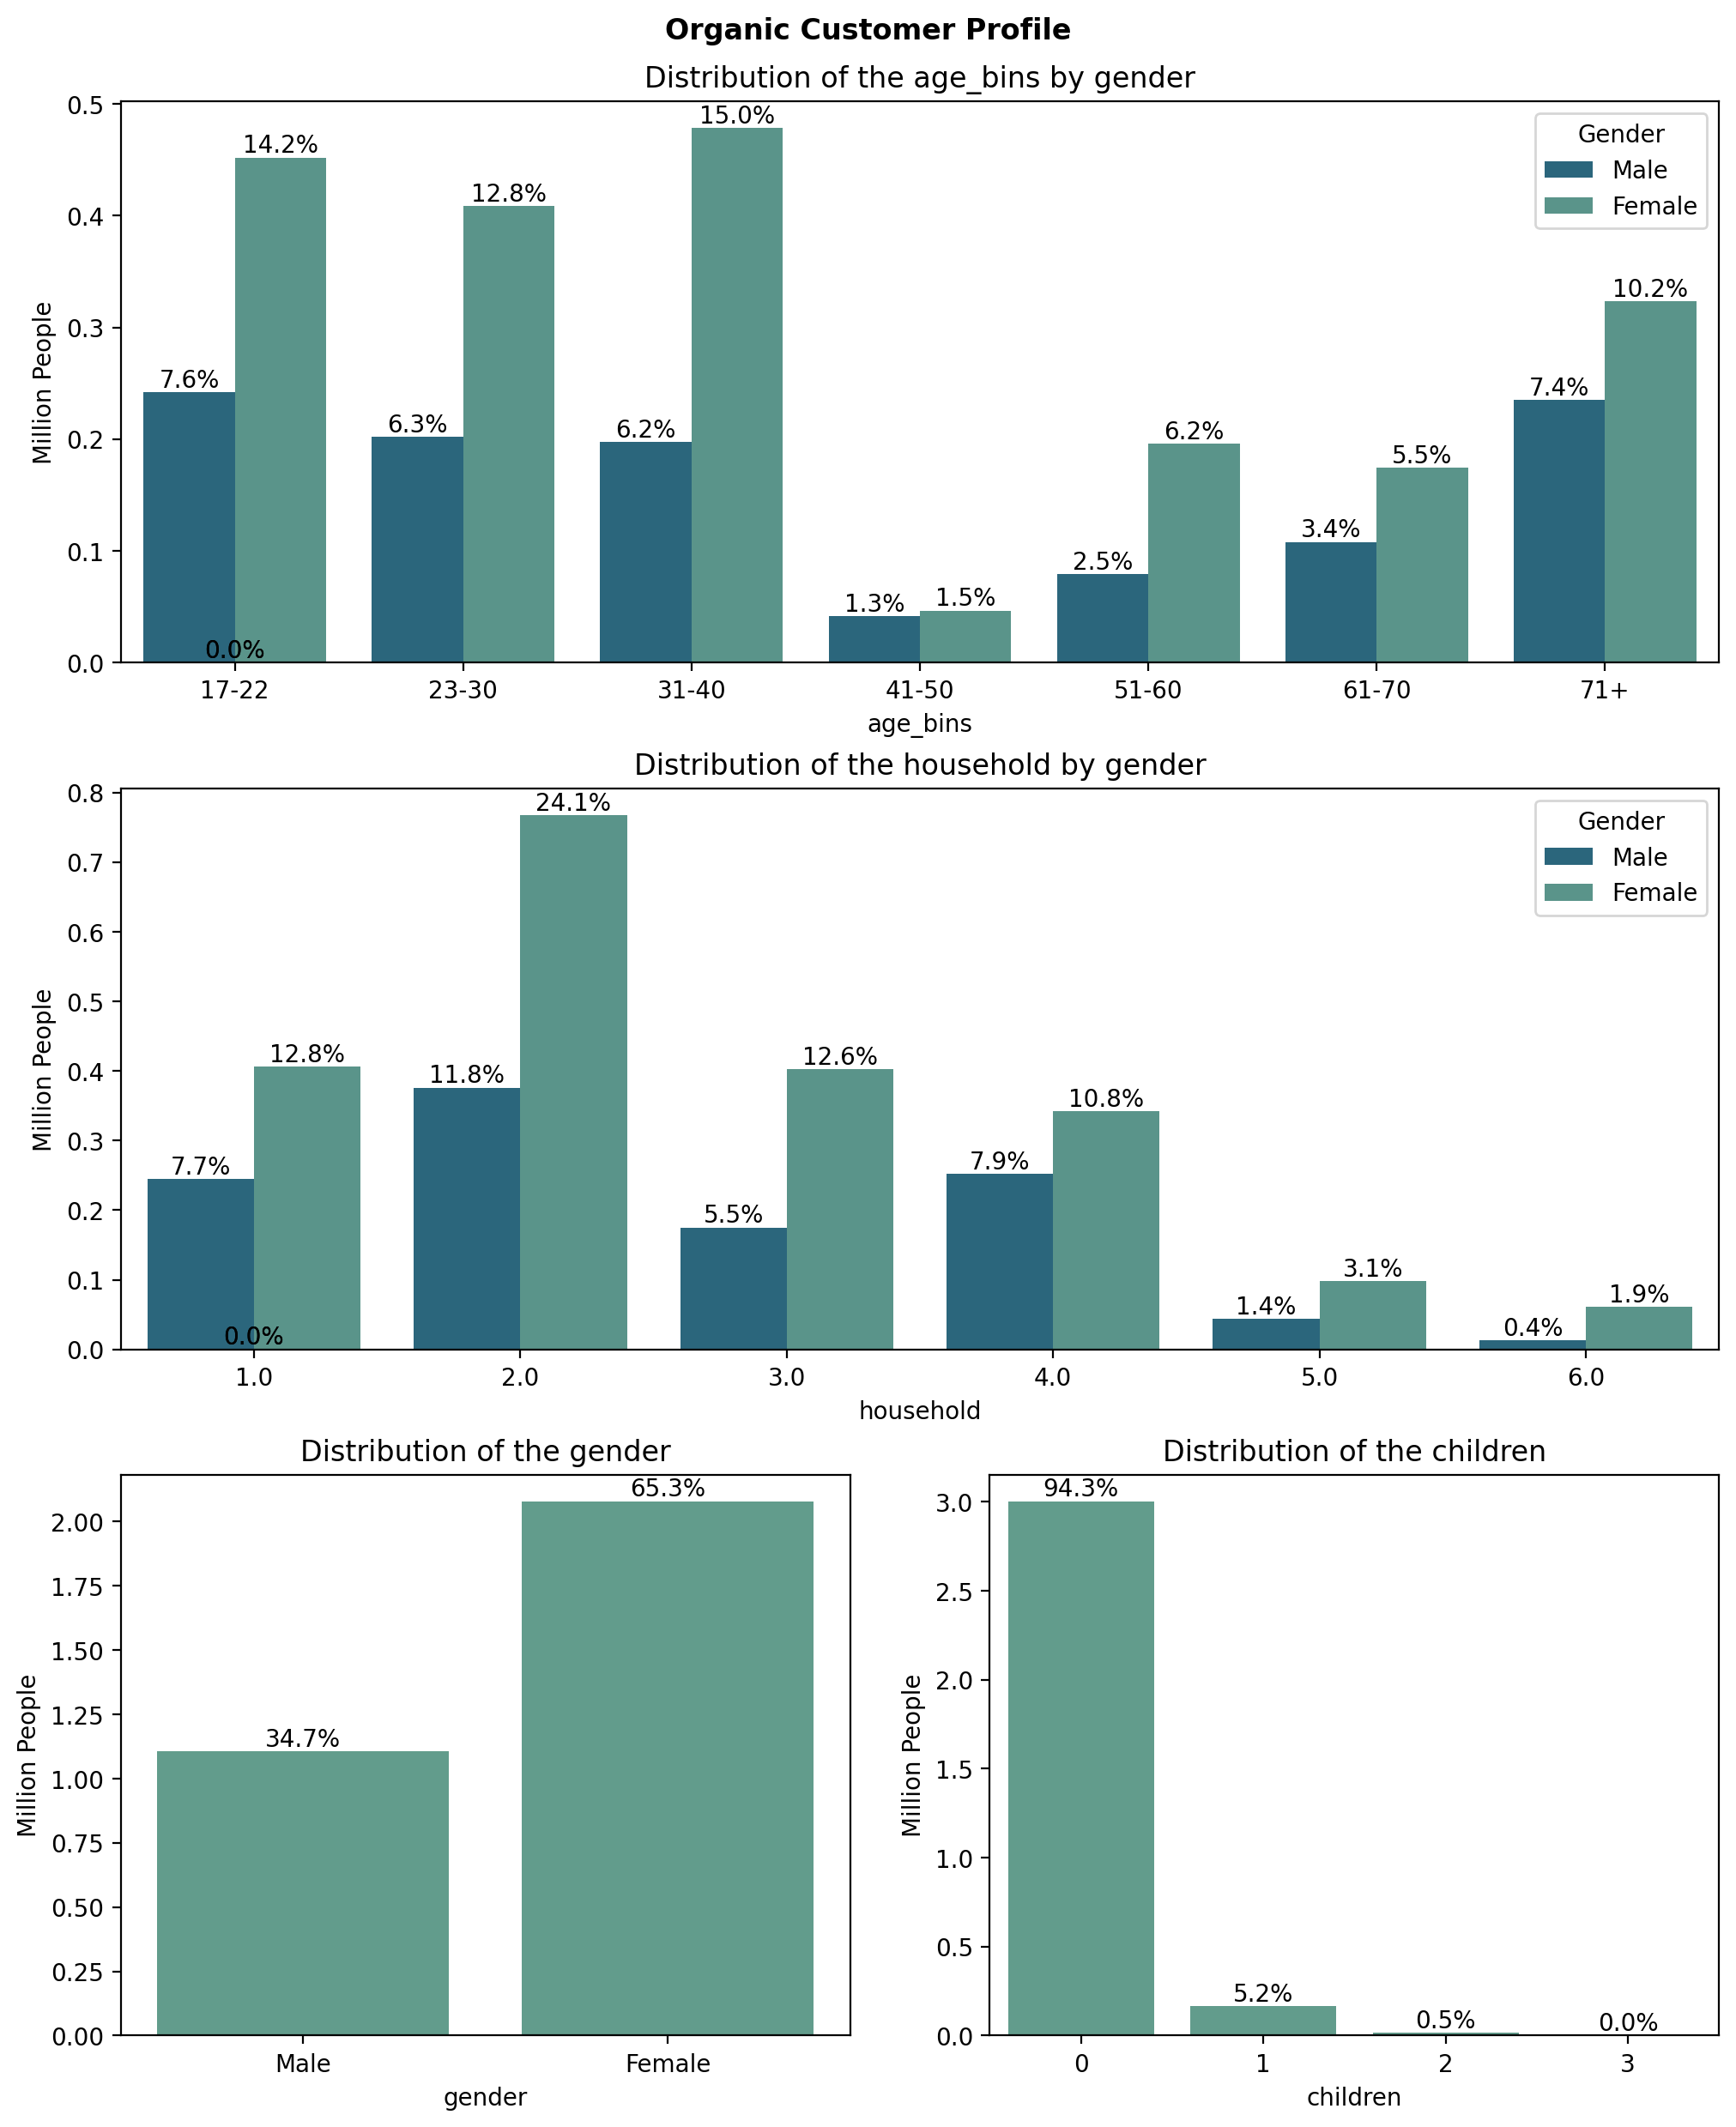

In [89]:
# Filter by organic customers
filtered_data = data_bi[data_bi["is_organic"]==1]

fig = plt.figure(figsize=(10, 12), constrained_layout=True)
grid = fig.add_gridspec(nrows=3, ncols=2)
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, :])
ax3 = fig.add_subplot(grid[2, :1])
ax4 = fig.add_subplot(grid[2, 1:])
axs = [ax1, ax2, ax3, ax4]

plt.suptitle(
    f"Organic Customer Profile", 
    y=1.02, fontsize=12, fontweight="semibold"
)

customer_features = ["age_bins", "household", "gender", "children"]

for i, feature in enumerate(customer_features):
    if feature in ["age_bins", "household"]:
        filtered_agg = filtered_data.groupby(
            [feature, "gender"], 
            observed=True, 
            as_index=False
        )["weight"].sum()
        
        filtered_agg["weight"] /= 1000000
        sns.barplot(
            data=filtered_agg, 
            x=feature, 
            y="weight", 
            hue="gender", 
            palette="crest_r",
            ax=axs[i]
        )
        axs[i].set_ylabel("Million People")
        axs[i].set_title(f"Distribution of the {feature} by gender")
        gender_labels = {0: "Male", 1: "Female"}
        handles, labels = axs[i].get_legend_handles_labels()
        axs[i].legend(handles, [gender_labels[int(label)] for label in labels], title="Gender")
    else:
        filtered_agg = filtered_data.groupby(
            feature, 
            observed=True, 
            as_index=False
        )["weight"].sum()
        
        filtered_agg["weight"] /= 1000000
        sns.barplot(
            data=filtered_agg, 
            x=feature, 
            y="weight", 
            color=COLOR, 
            ax=axs[i]
        )
        axs[i].set_ylabel("Million People")
        axs[i].set_title(f"Distribution of the {feature}")
        if feature == "gender":
            axs[i].set_xticks([0, 1])
            axs[i].set_xticklabels(["Male", "Female"])
        
    for p in axs[i].patches:
        total = filtered_agg["weight"].sum()
        absolute_value = p.get_height()
        percentage = (absolute_value / total) * 100
        axs[i].annotate(f"{percentage:.1f}%",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha="center", va="bottom")

* **Our typical organic customer is a 17-40 years old woman, without children, living with a partner.**
* Organic customers make up 8.9% of all people who purchased the product.
* Women make up 65.3% of organic customers.
* 94.3% of organic customers don't have children.

#### Acquired Customer Profile

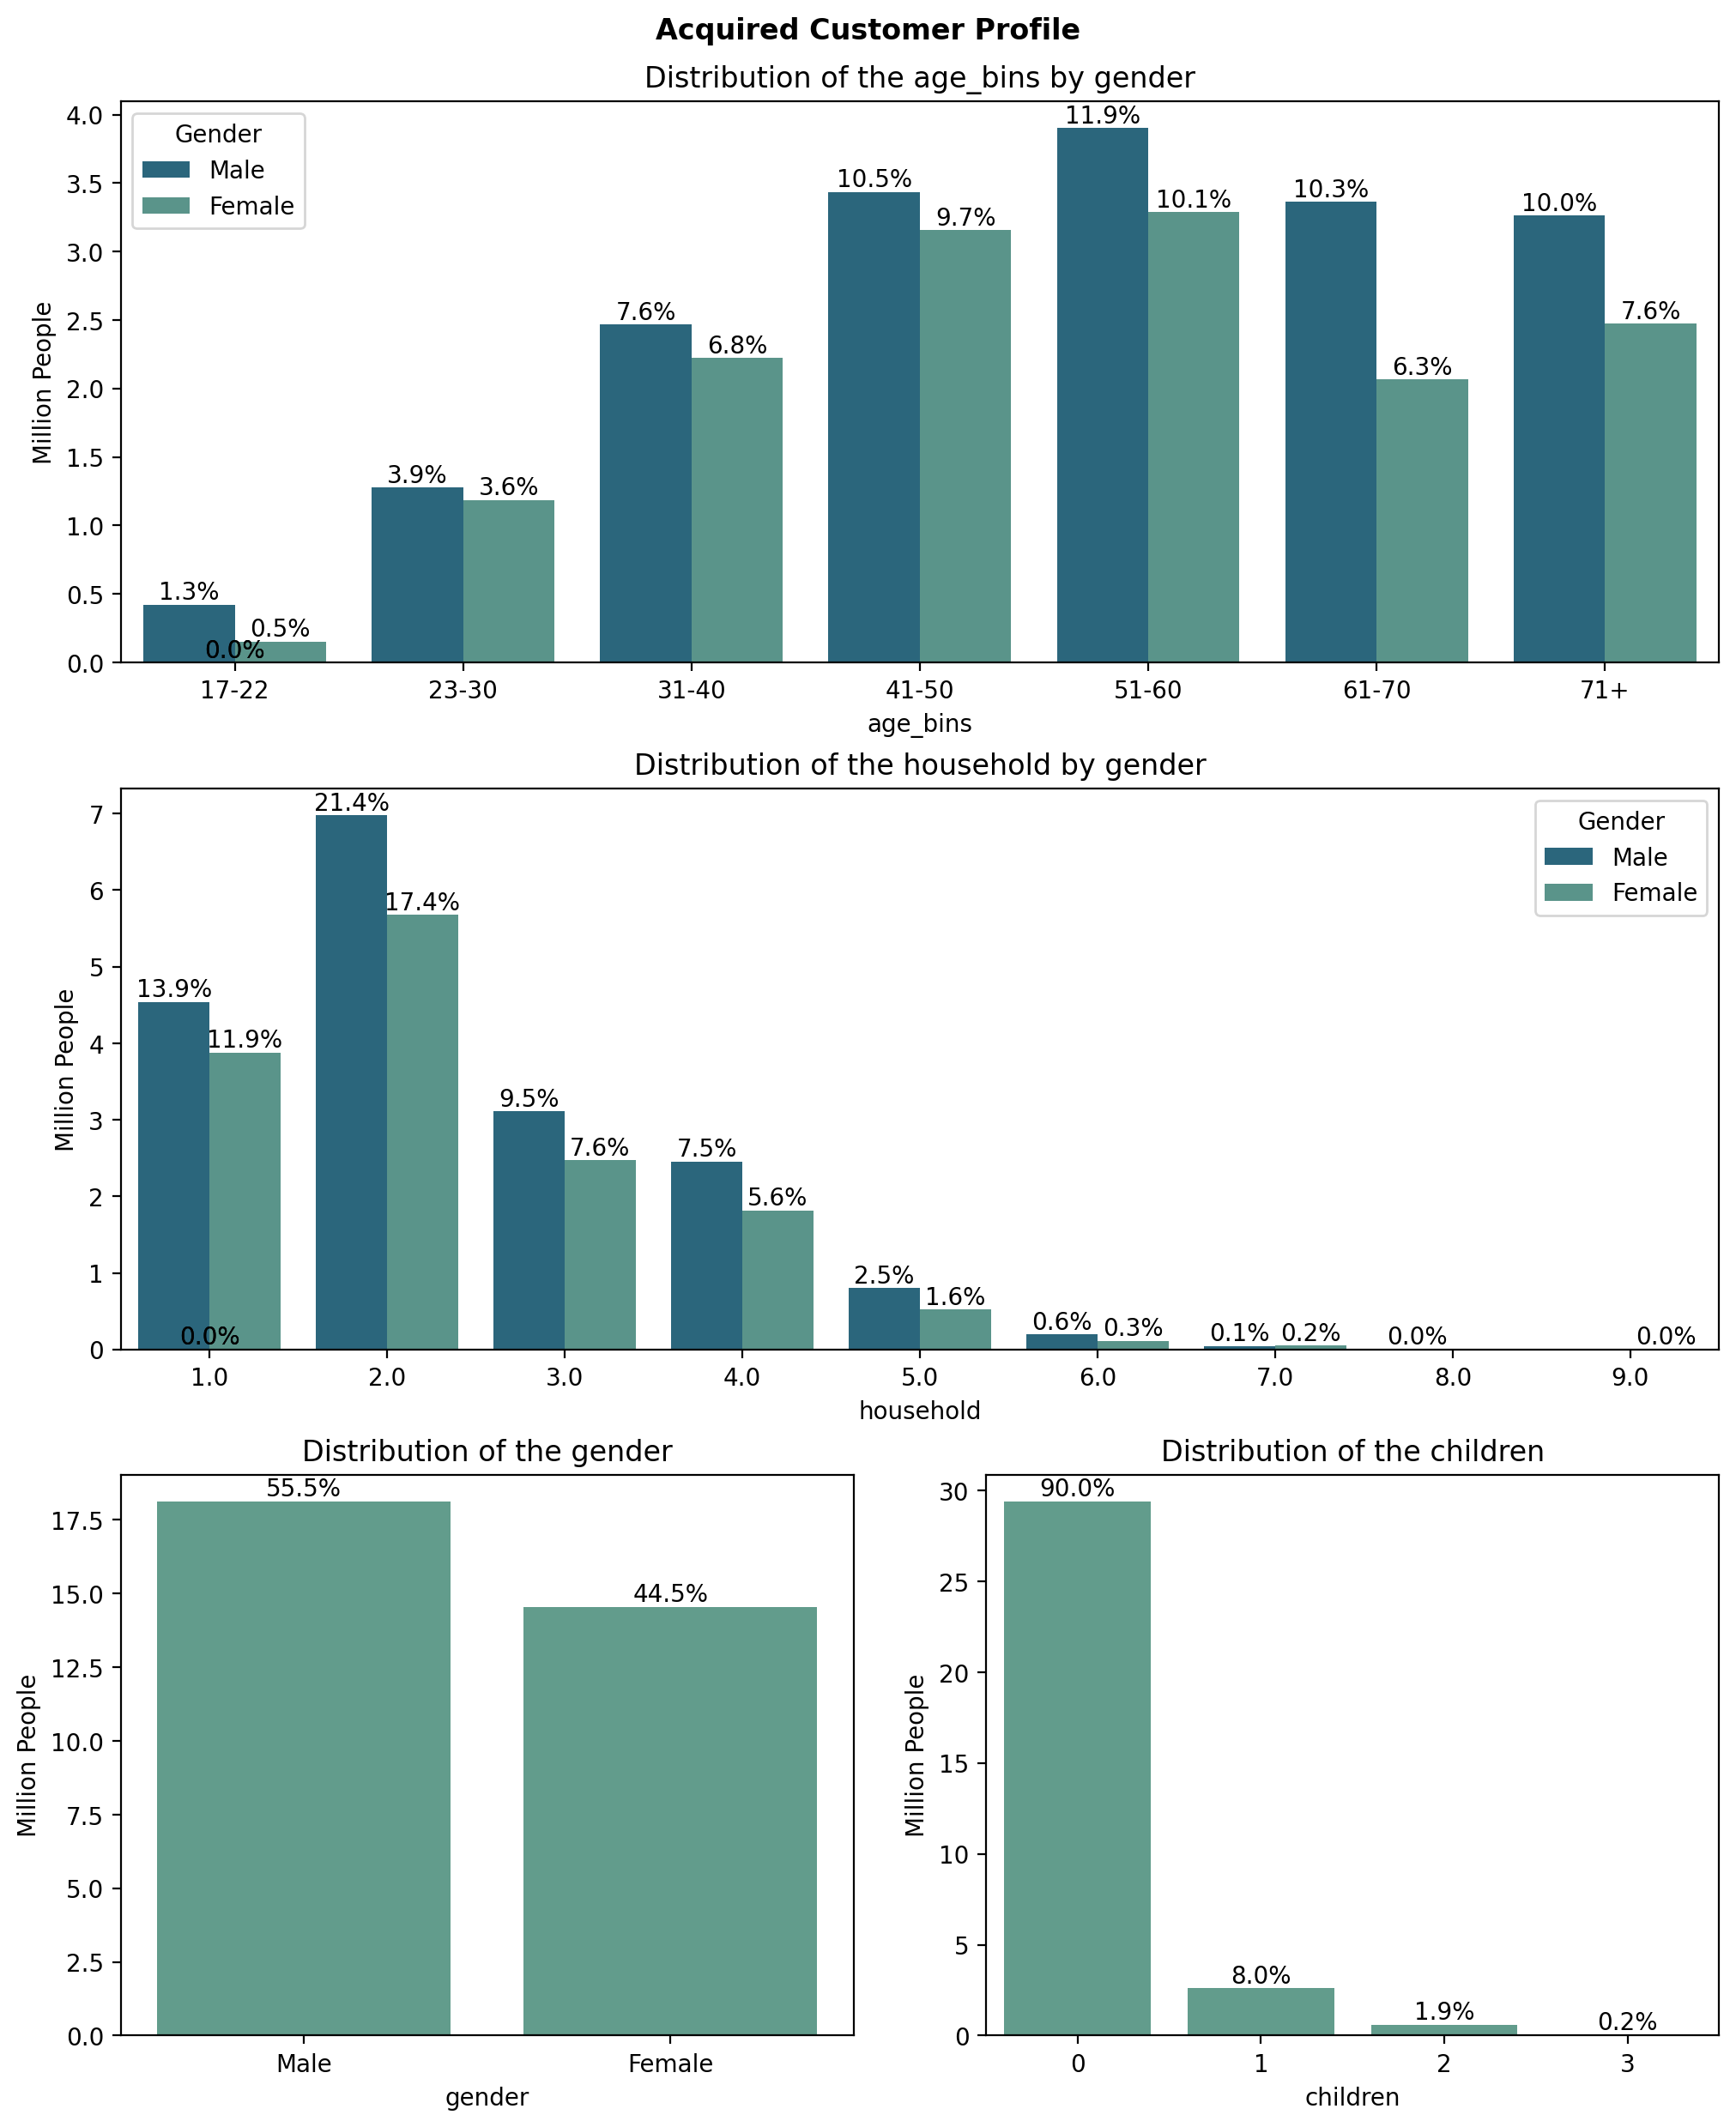

In [90]:
# Filter out organic customers
filtered_data = data_bi[(data_bi["is_organic"]==0) & (data_bi["purchase"]==1)]

fig = plt.figure(figsize=(10, 12), constrained_layout=True)
grid = fig.add_gridspec(nrows=3, ncols=2)
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, :])
ax3 = fig.add_subplot(grid[2, :1])
ax4 = fig.add_subplot(grid[2, 1:])
axs = [ax1, ax2, ax3, ax4]

plt.suptitle(
    f"Acquired Customer Profile", 
    y=1.02, fontsize=12, fontweight="semibold"
)

customer_features = ["age_bins", "household", "gender", "children"]

for i, feature in enumerate(customer_features):
    if feature in ["age_bins", "household"]:
        filtered_agg = filtered_data.groupby(
            [feature, "gender"], 
            observed=True, 
            as_index=False
        )["weight"].sum()
        
        filtered_agg["weight"] /= 1000000
        sns.barplot(
            data=filtered_agg, 
            x=feature, 
            y="weight", 
            hue="gender", 
            palette="crest_r",
            ax=axs[i]
        )
        axs[i].set_ylabel("Million People")
        axs[i].set_title(f"Distribution of the {feature} by gender")
        gender_labels = {0: "Male", 1: "Female"}
        handles, labels = axs[i].get_legend_handles_labels()
        axs[i].legend(handles, [gender_labels[int(label)] for label in labels], title="Gender")
    else:
        filtered_agg = filtered_data.groupby(
            feature, 
            observed=True, 
            as_index=False
        )["weight"].sum()
        
        filtered_agg["weight"] /= 1000000
        sns.barplot(
            data=filtered_agg, 
            x=feature, 
            y="weight", 
            color=COLOR, 
            ax=axs[i]
        )
        axs[i].set_ylabel("Million People")
        axs[i].set_title(f"Distribution of the {feature}")
        if feature == "gender":
            axs[i].set_xticks([0, 1])
            axs[i].set_xticklabels(["Male", "Female"])
        
    for p in axs[i].patches:
        total = filtered_agg["weight"].sum()
        absolute_value = p.get_height()
        percentage = (absolute_value / total) * 100
        axs[i].annotate(f"{percentage:.1f}%",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha="center", va="bottom")

The situation changed for acquired customers. 

* **Our typical acquired customer is a mid to elder age man without children, living with a partner.**
* Now male customers make up 55.5% which means that they more likely will buy our product when they see the advertisement.
* There is no dominant age category, young people presented less than in the organic customers group.

#### Analysis Results

**Conversion Rate (CR) Analysis**
* The overall conversion rate (CR) for the product is 5.11%.
* Among the five channels used independently, flyers (13.50%), print_total (9.20%), and TikTok (5.98%) outperformed the overall CR.
* The flyers channel stands out with an exceptional CR of 13.50%, demonstrating its effectiveness in driving conversions.
* Channels like YouTube and Online were never used as standalone sources, making it impossible to evaluate their individual CR.

**Media Channel Interactions**
* TV is the dominant channel, accounting for 63% of all interactions.
* The second most popular channel is print, contributing 7.78% of interactions.
* TikTok, despite having a relatively high conversion rate, is the least utilized channel, representing only 0.47% of all interactions.

**Engagement by Age Group**

Age groups show varying preferences for media channels, highlighting the need for targeted strategies:

|Age Group|% of Interactions|Key Observations|
|:--|:--|:--|
|17-22|1.71%|Rarely interacts with ads. Channels: flyers, print, online, and TV.|
|23-30|6.13%|Does not engage with ads via YouTube.|
|31-40|13.41%|Engages with Pinterest, YouTube (mobile), and print.|
|41-50|19.25%|Highest YouTube (mobile) interactions. Also engages with print and Pinterest.|
|51-60|**23.88%**|**Most interactions across all channels.** Popular channels: TV, print, YouTube (mobile), Pinterest.|
|61-70|19.65%|Engages with Pinterest more than any other group.|
|71+|15.97%|Interacts with flyers more than other groups. Also engages with print.|

**Customer Profiles**

1. Organic Customers
* Organic customers make up 8.9% of all customers who purchased the product.
* Typical Profile: A woman aged 17-40, without children, living with a partner.
* Women account for 65.3% of organic customers.
* 94.3% of organic customers do not have children.

2. Acquired Customers
* Typical Profile: A mid-to-elder-aged man, without children, living with a partner.
* Men now constitute 55.5% of acquired customers, indicating their higher likelihood of purchasing after viewing advertisements.
* No dominant age category was observed, though young people are underrepresented compared to the organic customer group.

### Analysis from ML perspective

#### Feature Distributions

**Feature `purchase` (target)**

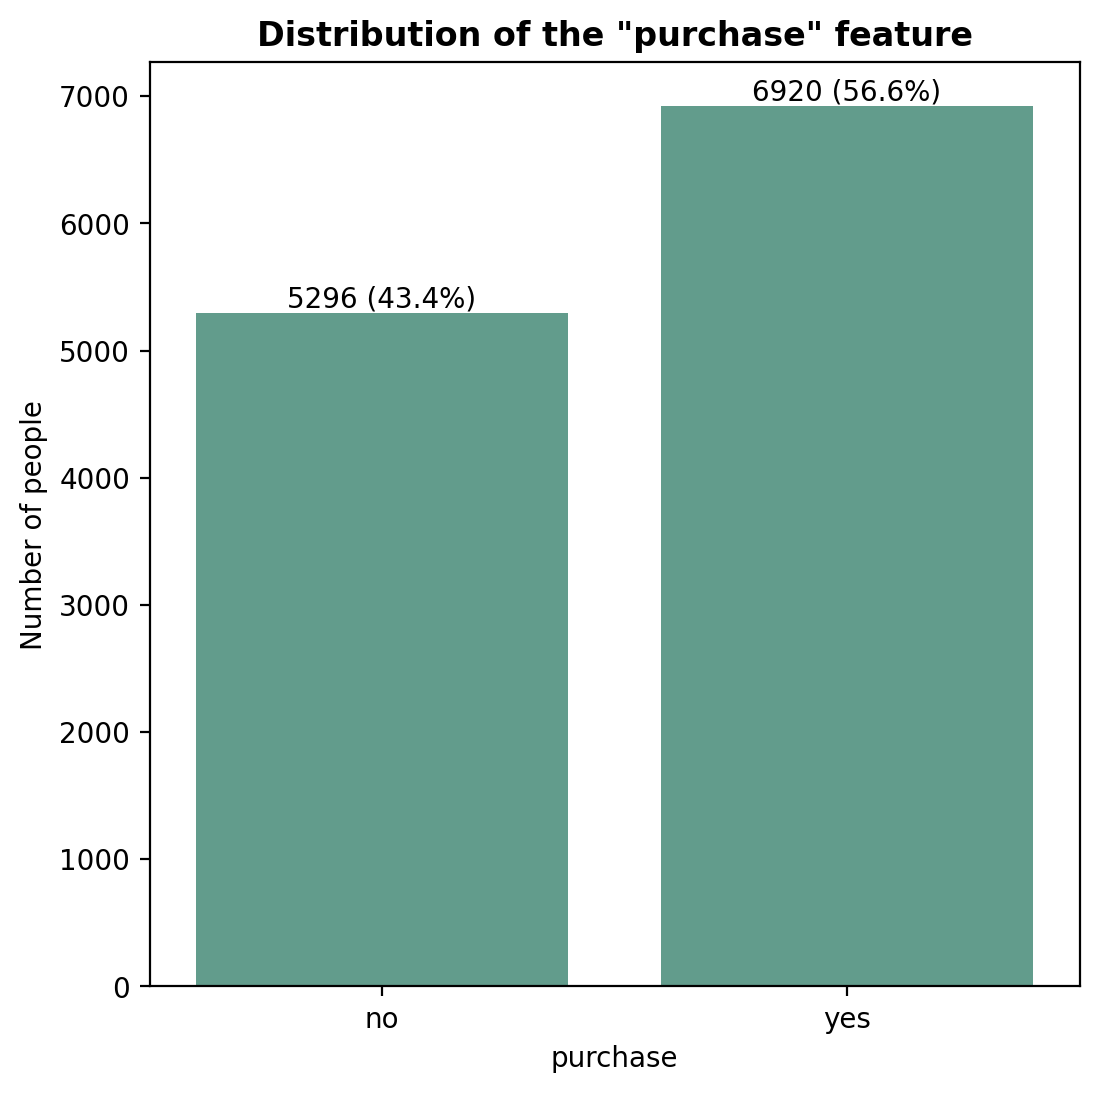

In [91]:
plot_categorical_feature(
    data=data, 
    column="purchase", 
    binary=True, 
    binary_x_labels=["no", "yes"]
)

* The target feature has only two values - 0 and 1, it means that we will be solving binary classification problem. 
* We observe light class imbalance. We don't need to apply any upsampling techniques, stratification should be enough.

**Feature `weight`**

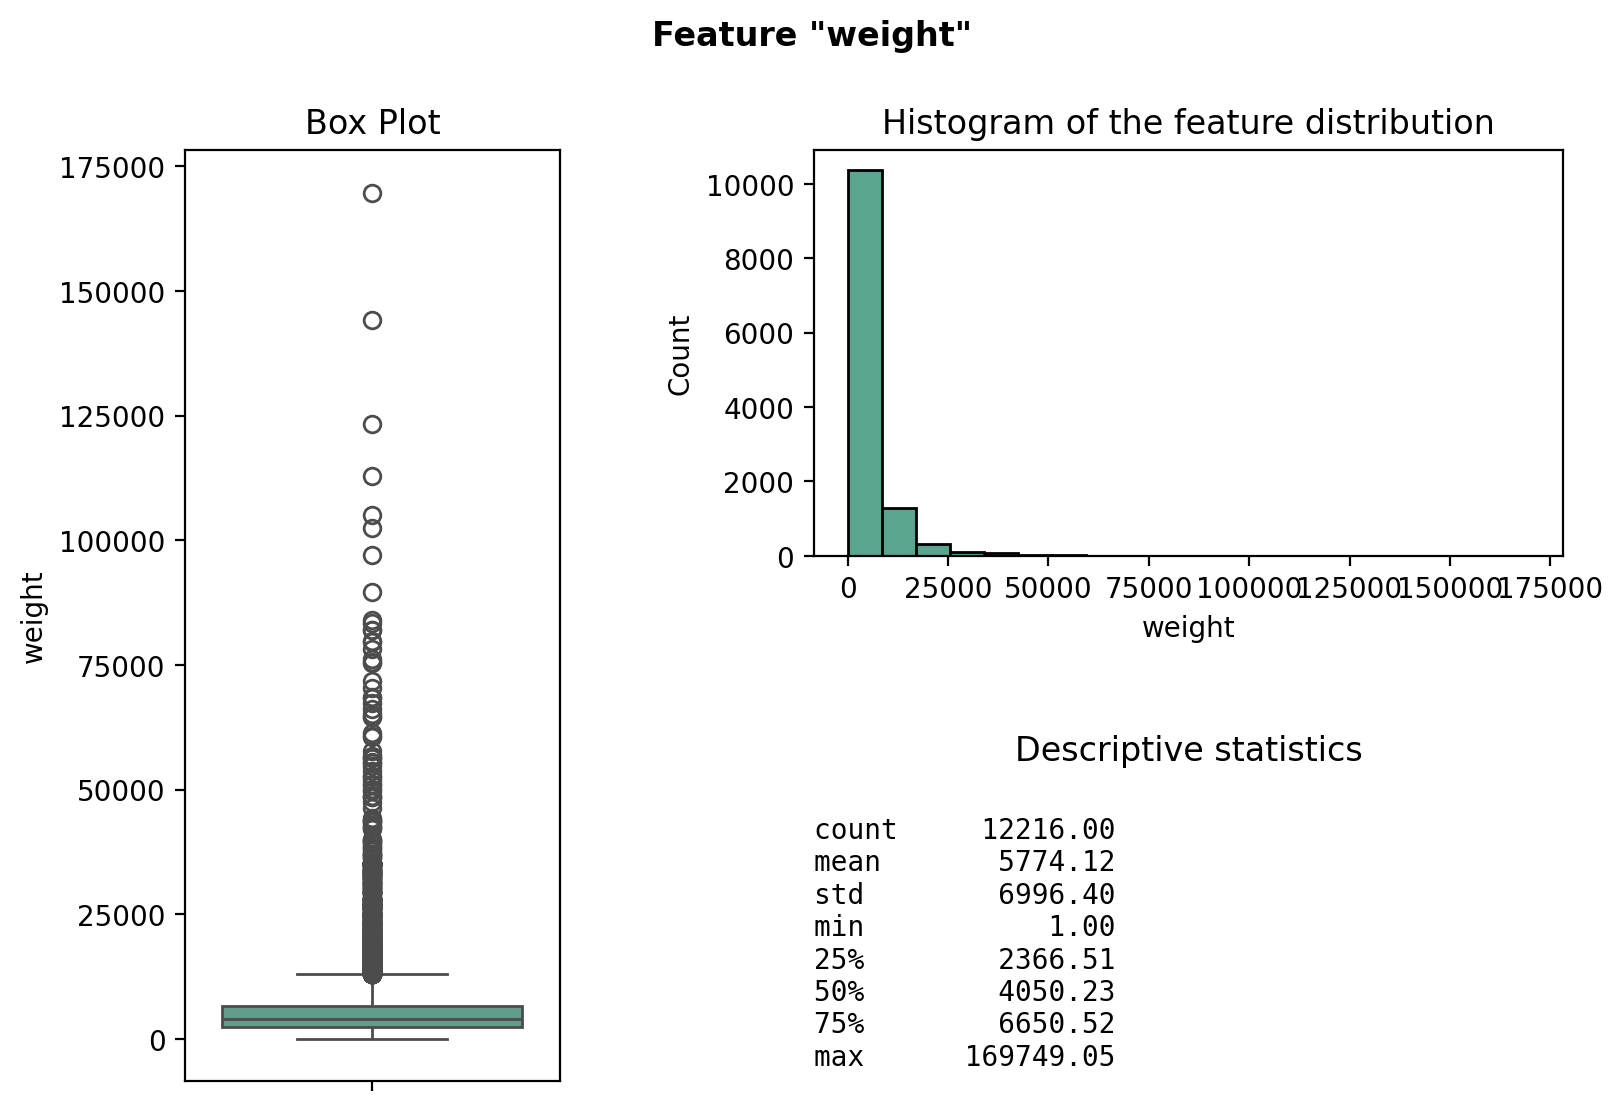

In [92]:
plot_numeric_feature(data=data, column="weight")

* The feature is numeric. It has logarithmic distribution with values ranging from 1 to 169'749.
* The distribution is highly skewed. This skewness indicates that extreme values (outliers) are present and significantly differ from the majority of the data.
* All feature values are positive, so we can apply logarithmic transformation.

In [93]:
# Remove data with weight less than 10
data = data.loc[data["weight"]>=10]

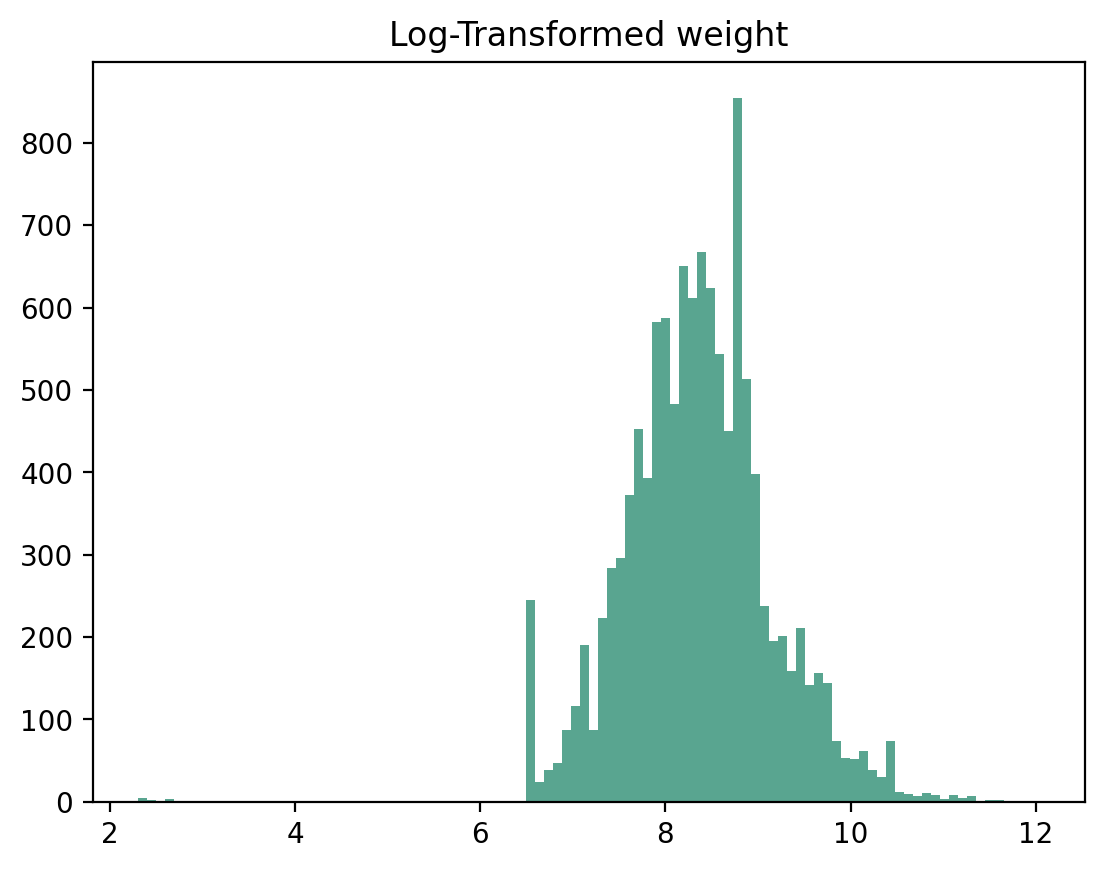

In [94]:
# Apply log-transformation and plot
data["weight"] = np.log(data["weight"])
plt.hist(data["weight"], bins=100, color=COLOR)
plt.title("Log-Transformed weight")
plt.show()

Now the plot resembles normal distribution.

**Feature `gender`**

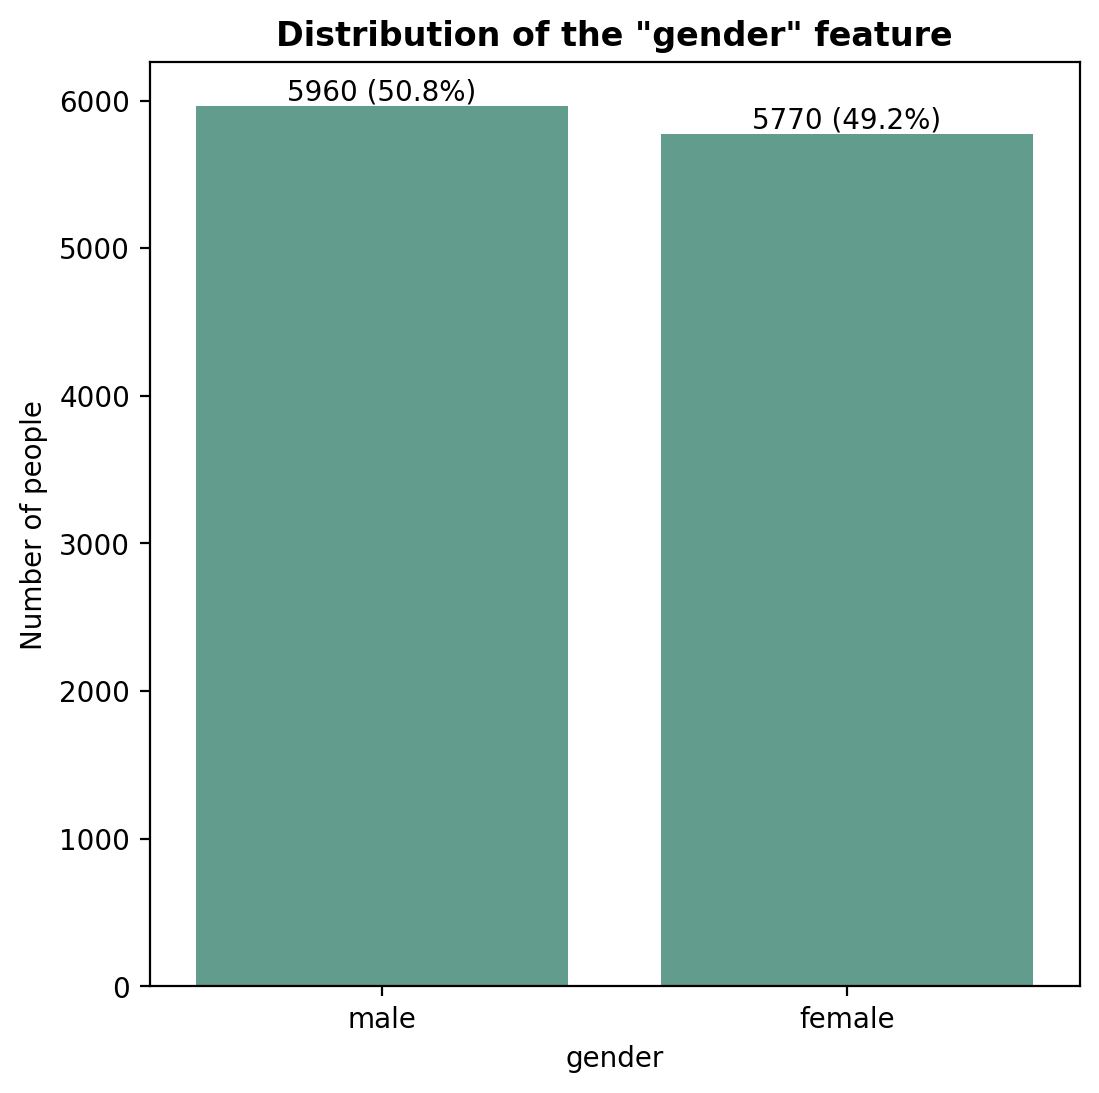

In [95]:
plot_categorical_feature(
    data=data, 
    column="gender",
    binary=True, 
    binary_x_labels=["male", "female"]
)

* The feature is binary categorical.
* The categories are almost equal.

**Feature `children`**

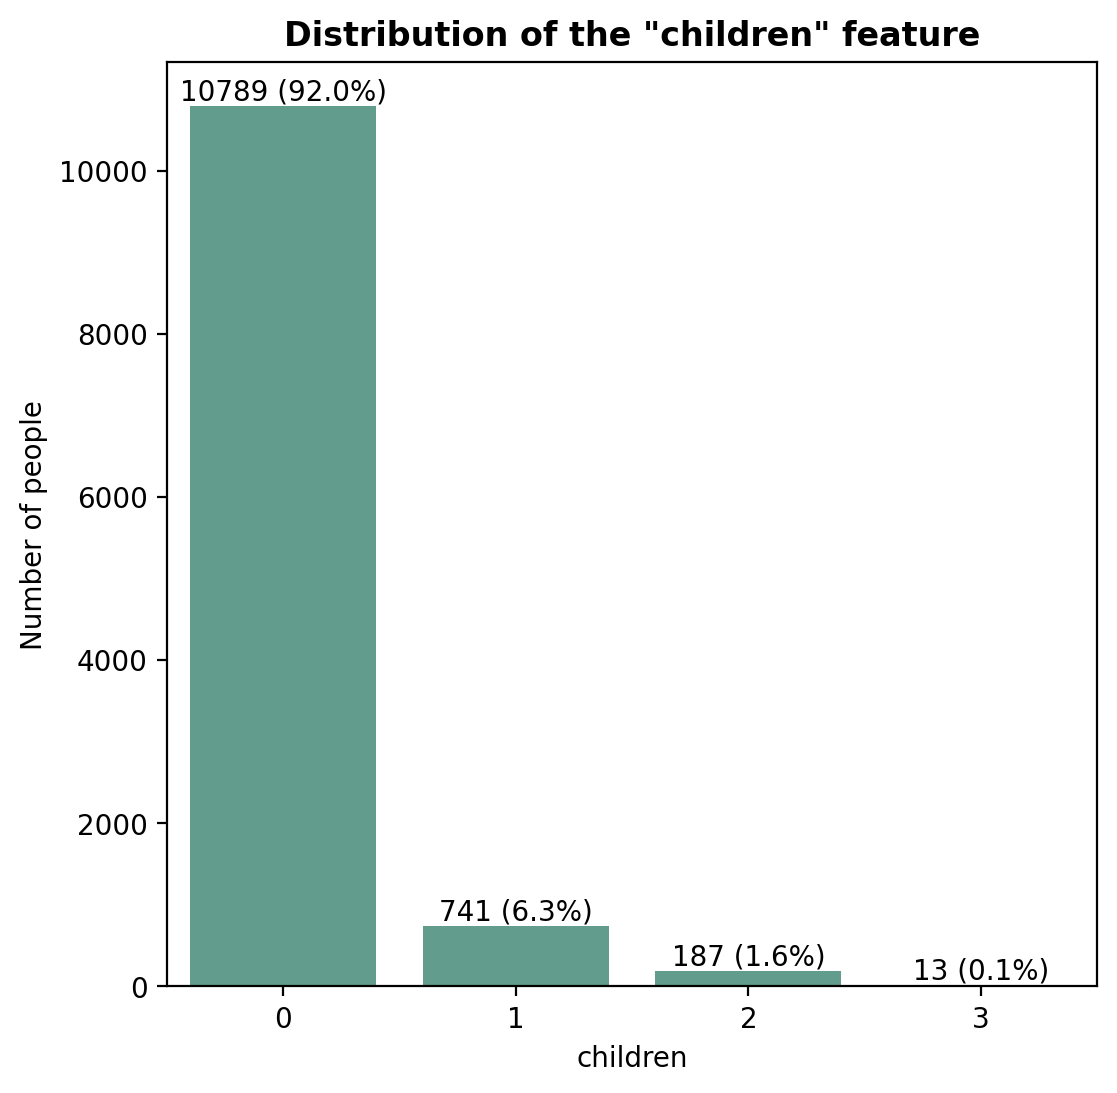

In [96]:
plot_categorical_feature(data=data, column="children")

* The feature is numeric, but has only 4 int values so can be treated as categorical.
* The categories are highly imbalanced, with the category 0 make up 91.5% of the values.

**Feature `household`**

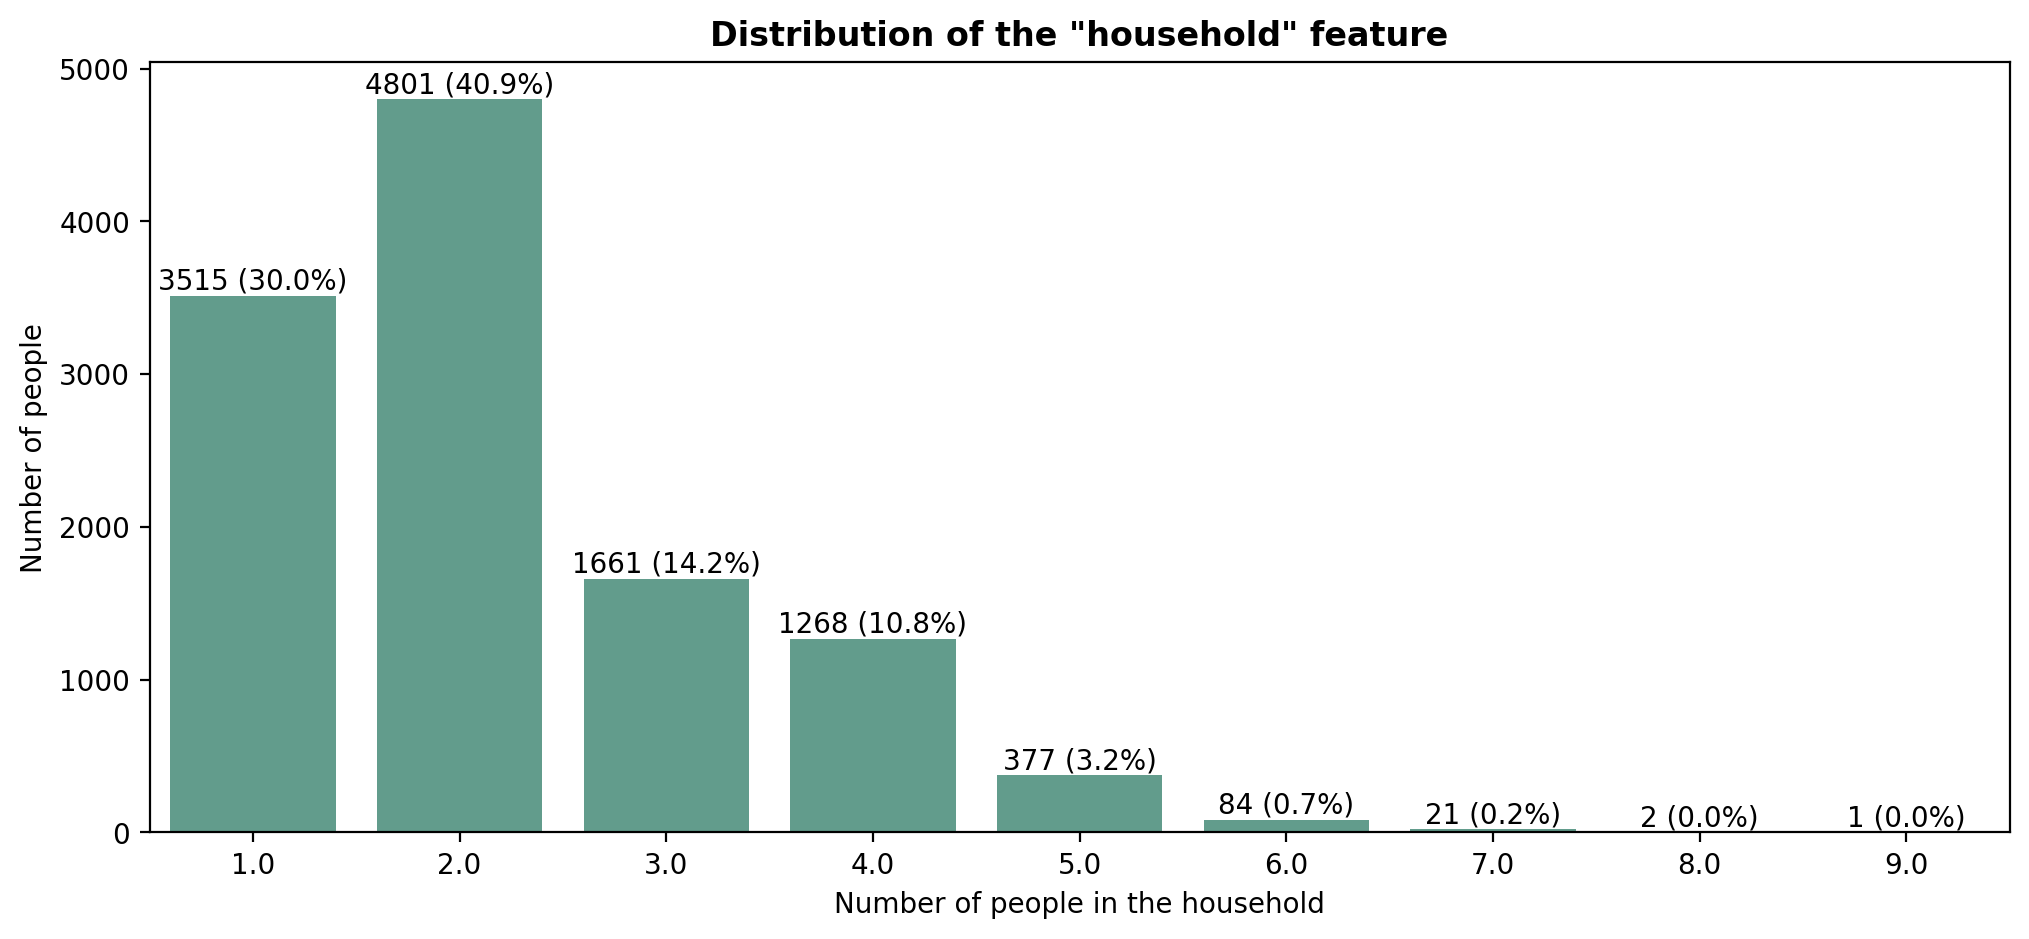

In [97]:
plot_categorical_feature(
    data=data, 
    column="household", 
    size=(12,5),
    x_text="Number of people in the household"
)

* The feature is numeric, but has only 9 int values so can be treated as categorical.
* The categories are highly imbalanced.

**Feature `age`**

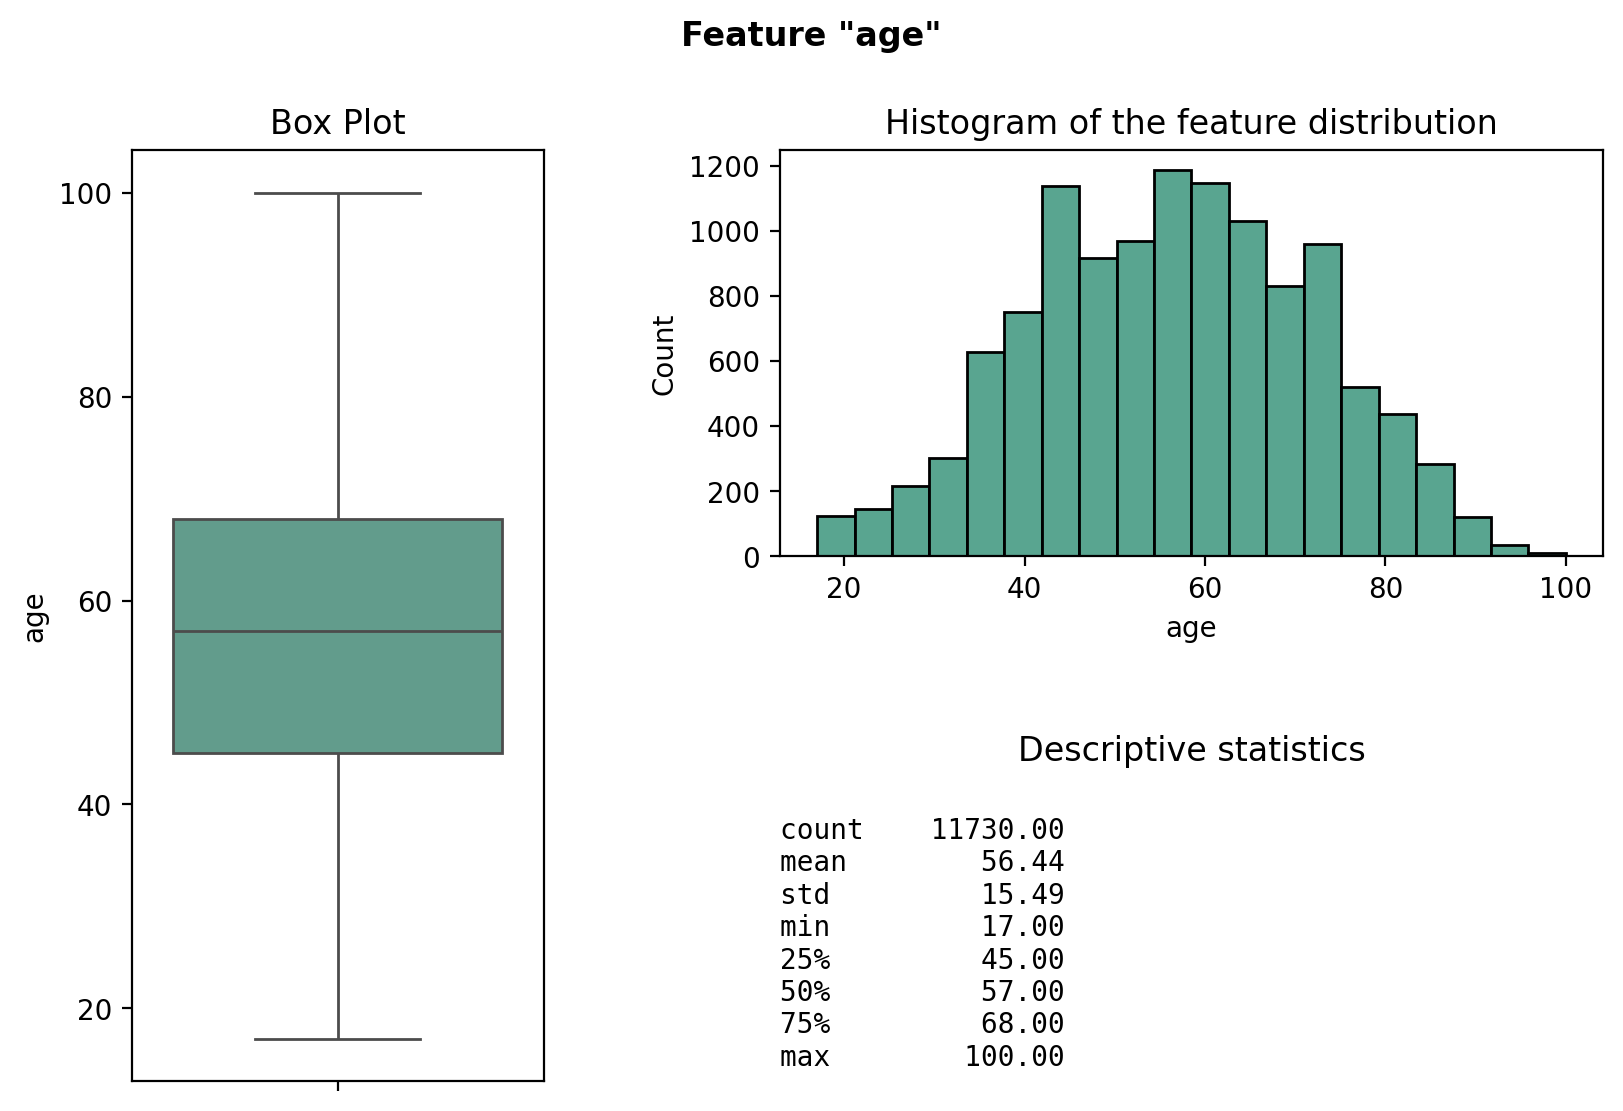

In [98]:
plot_numeric_feature(data=data, column="age")

* The feature is numeric with values ranging from 17 to 100.
* There are no outliers.
* The feature has normal distribution.

**Feature `tv_total`**

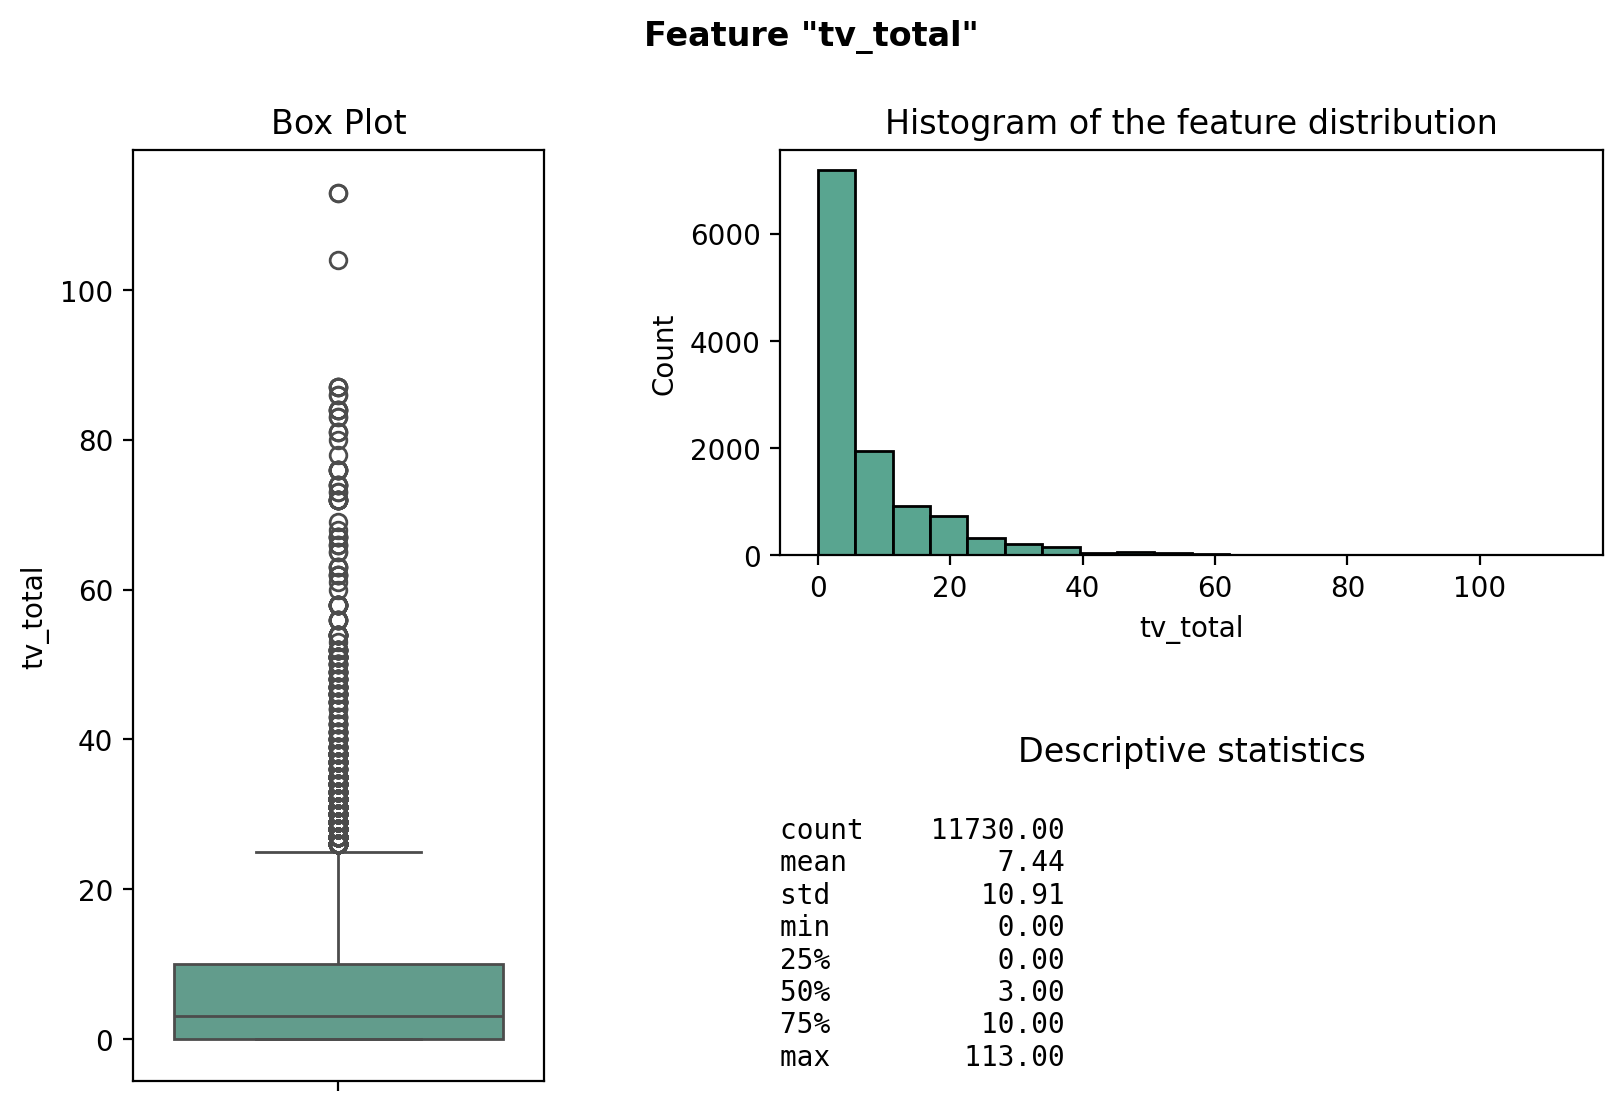

In [99]:
plot_numeric_feature(data=data, column="tv_total")

* The feature is numeric with values ranging from 0 to 113.
* There are a lot of outliers, but they correctly reflect the dominance of the TV interaction channel. We will not remove any outliers.
* The feature has logarithmic distribution, but has 0 values so we cannot aply log-transformation.

**Feature `flyers`**

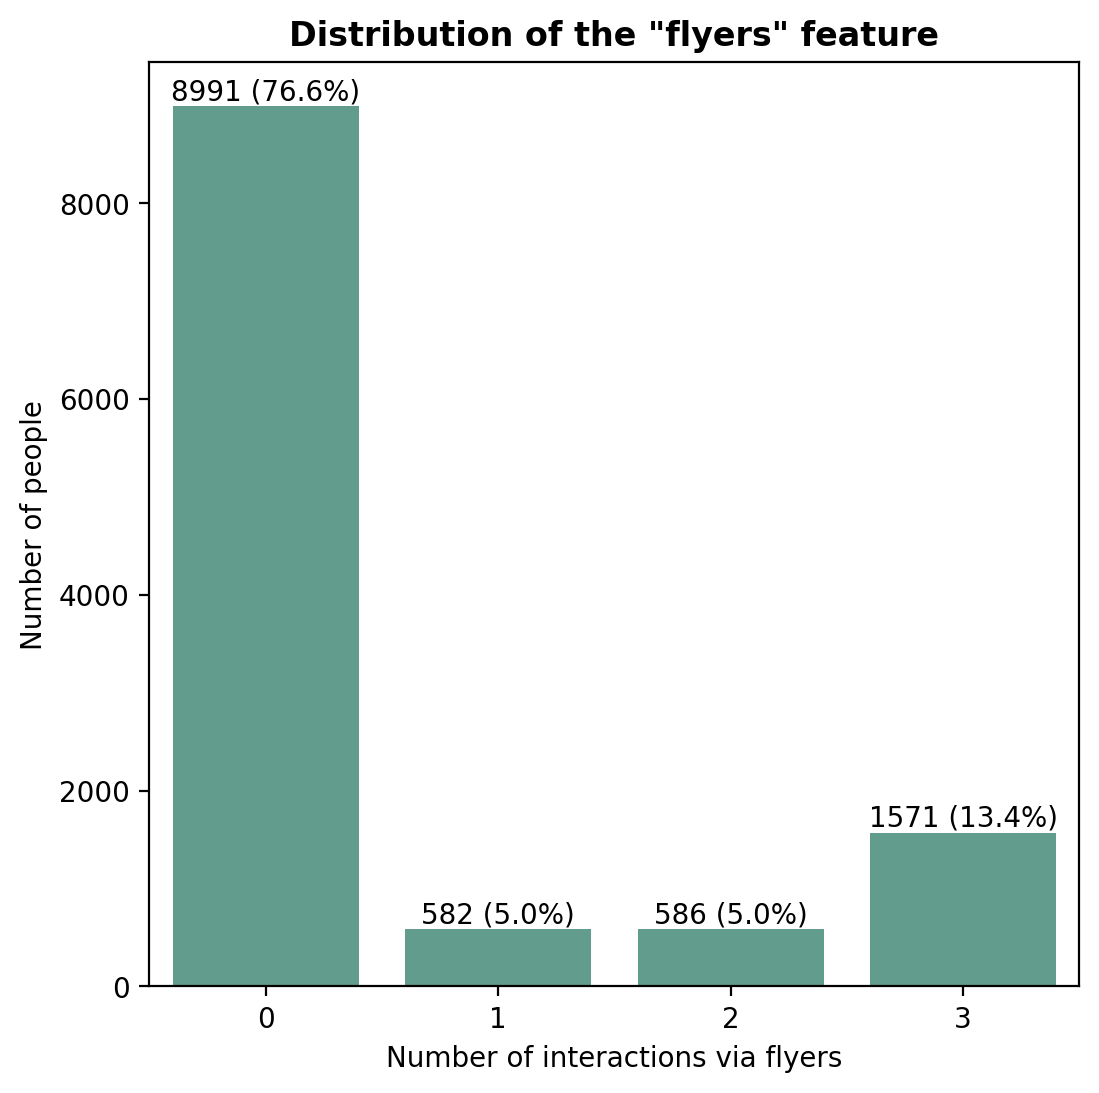

In [100]:
plot_categorical_feature(
    data=data,
    column="flyers",
    x_text="Number of interactions via flyers"
)

* The feature is numeric, but has only 4 int values so can be treated as categorical.
* The categories are highly imbalanced.

**`print_total`**

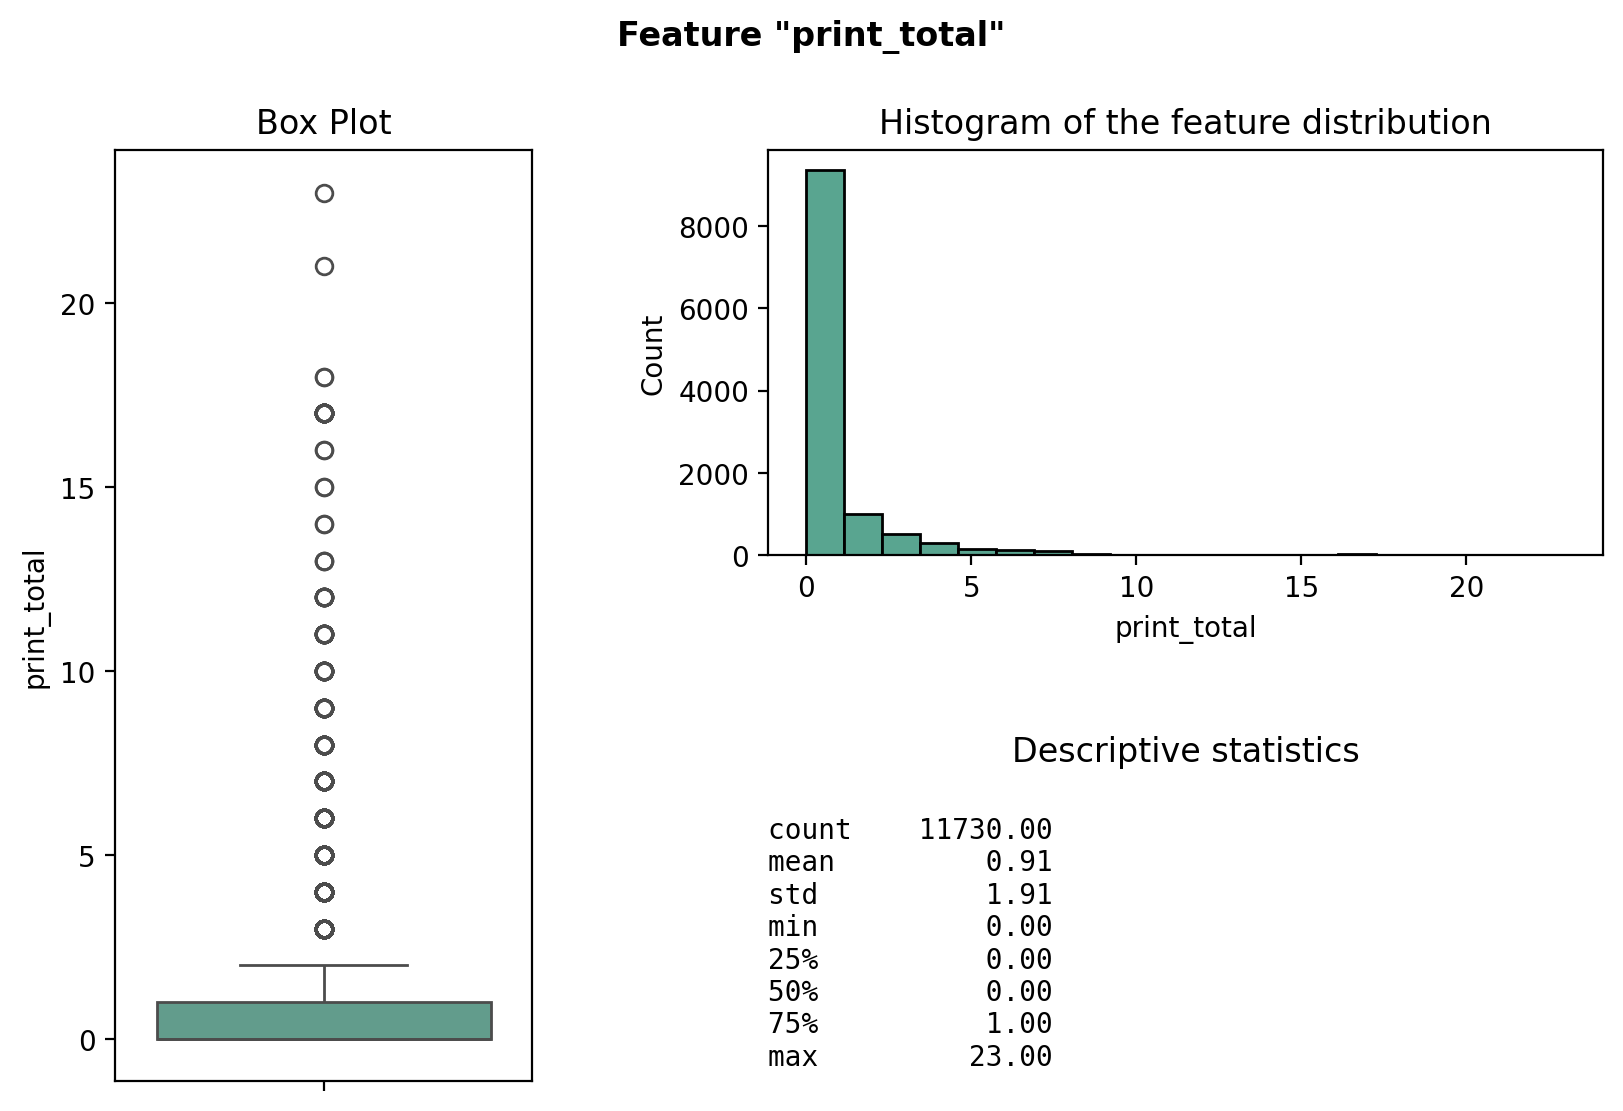

In [101]:
plot_numeric_feature(data=data, column="print_total")

* The feature is numeric with values ranging from 0 to 23.
* The distribution is highly-skewed, but due to the presence of 0 values we cannot use log-transformation.

**Features `online_x`**

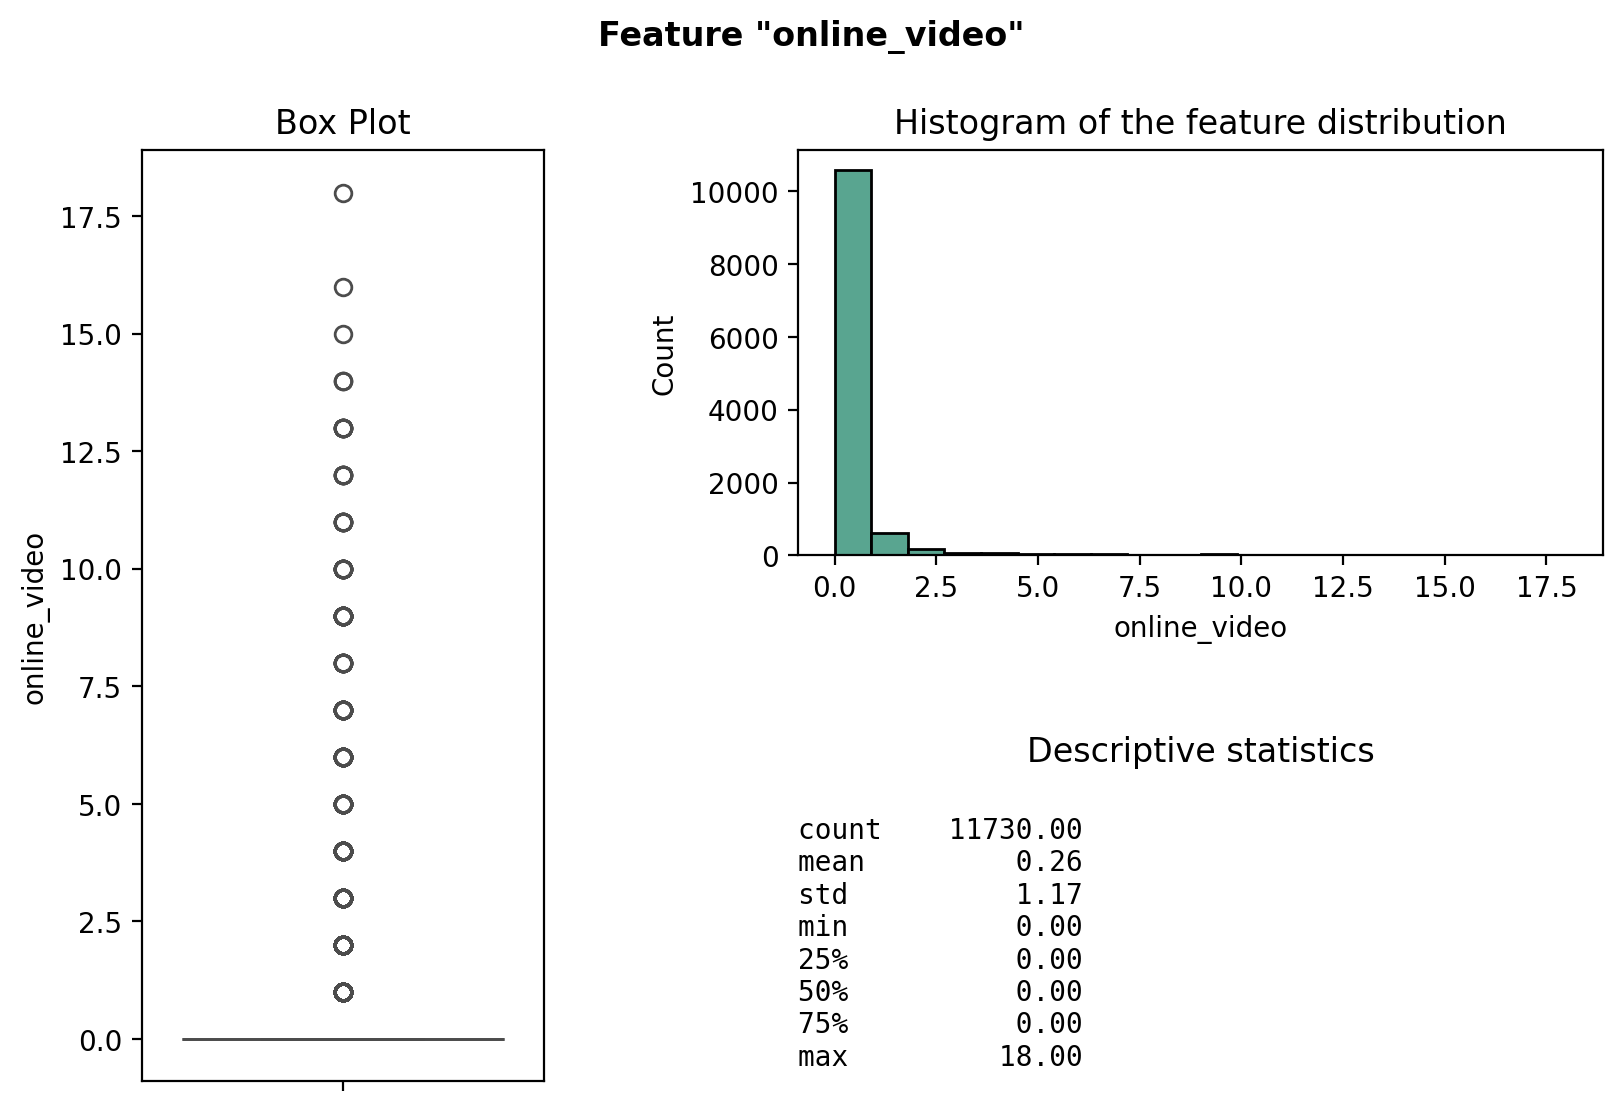

In [102]:
plot_numeric_feature(data=data, column="online_video")

* The feature is numeric with values ranging from 0 to 18.
* The distribution is highly-skewed, but due to the presence of 0 values we cannot use log-transformation.

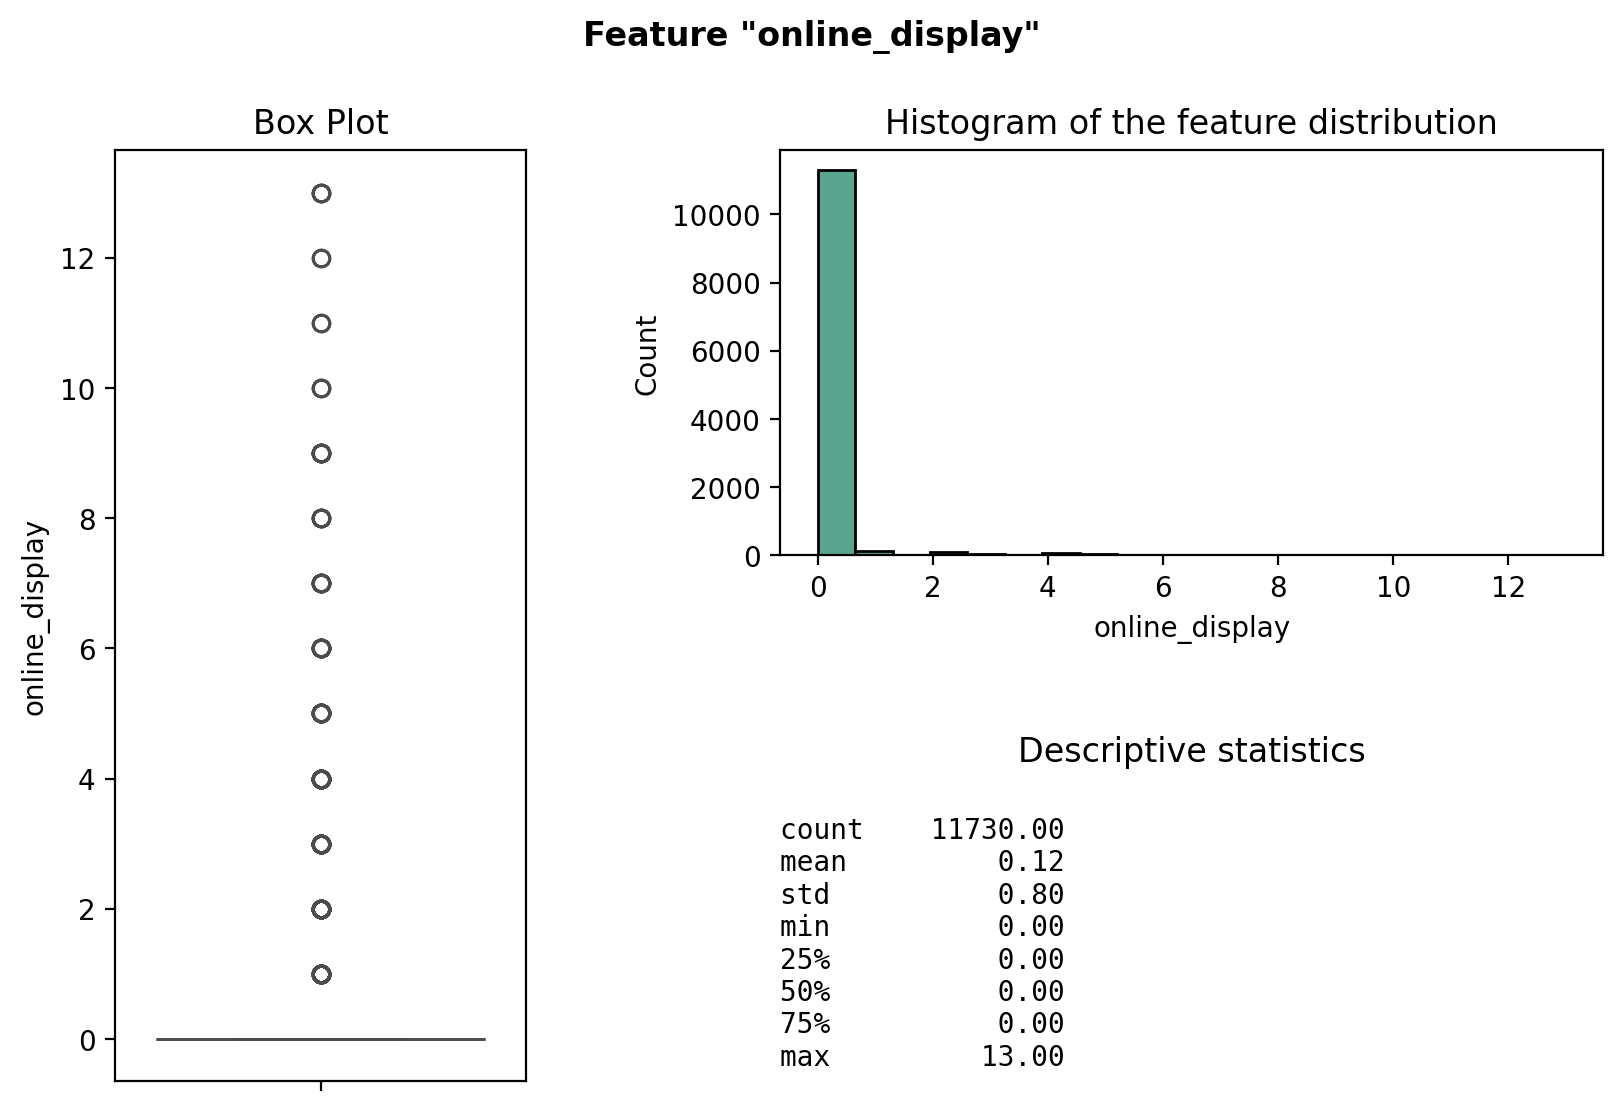

In [103]:
plot_numeric_feature(data=data, column="online_display")

* The feature is numeric with values ranging from 0 to 13.
* The distribution is highly-skewed, but due to the presence of 0 values we cannot use log-transformation.
* Most of the values are 0.

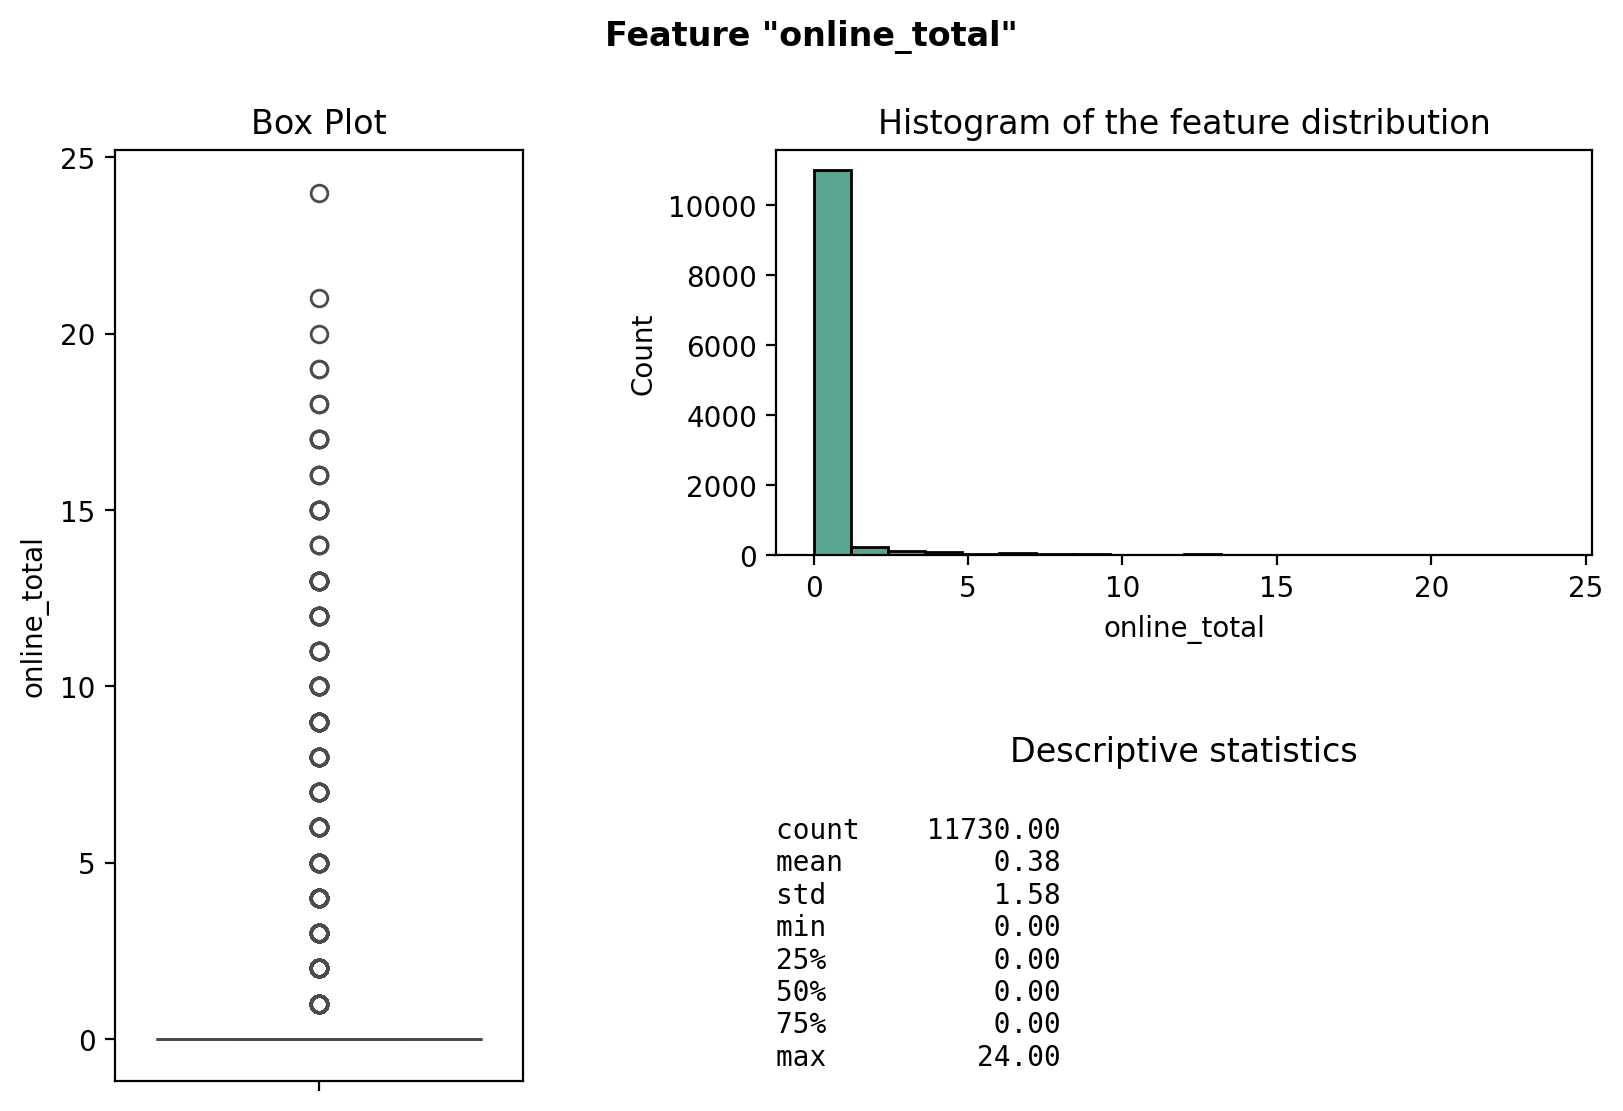

In [104]:
plot_numeric_feature(data=data, column="online_total")

* The feature is numeric with values ranging from 0 to 24.
* The distribution is highly-skewed, but due to the presence of 0 values we cannot use log-transformation.
* This feauture is a sum of the features `online_video` and `online_display`. They will have very strong correlation, it is not a problem for Decision Tree based models, but still might be useful to remove multi-collinearity.

**Feature `tiktok`**

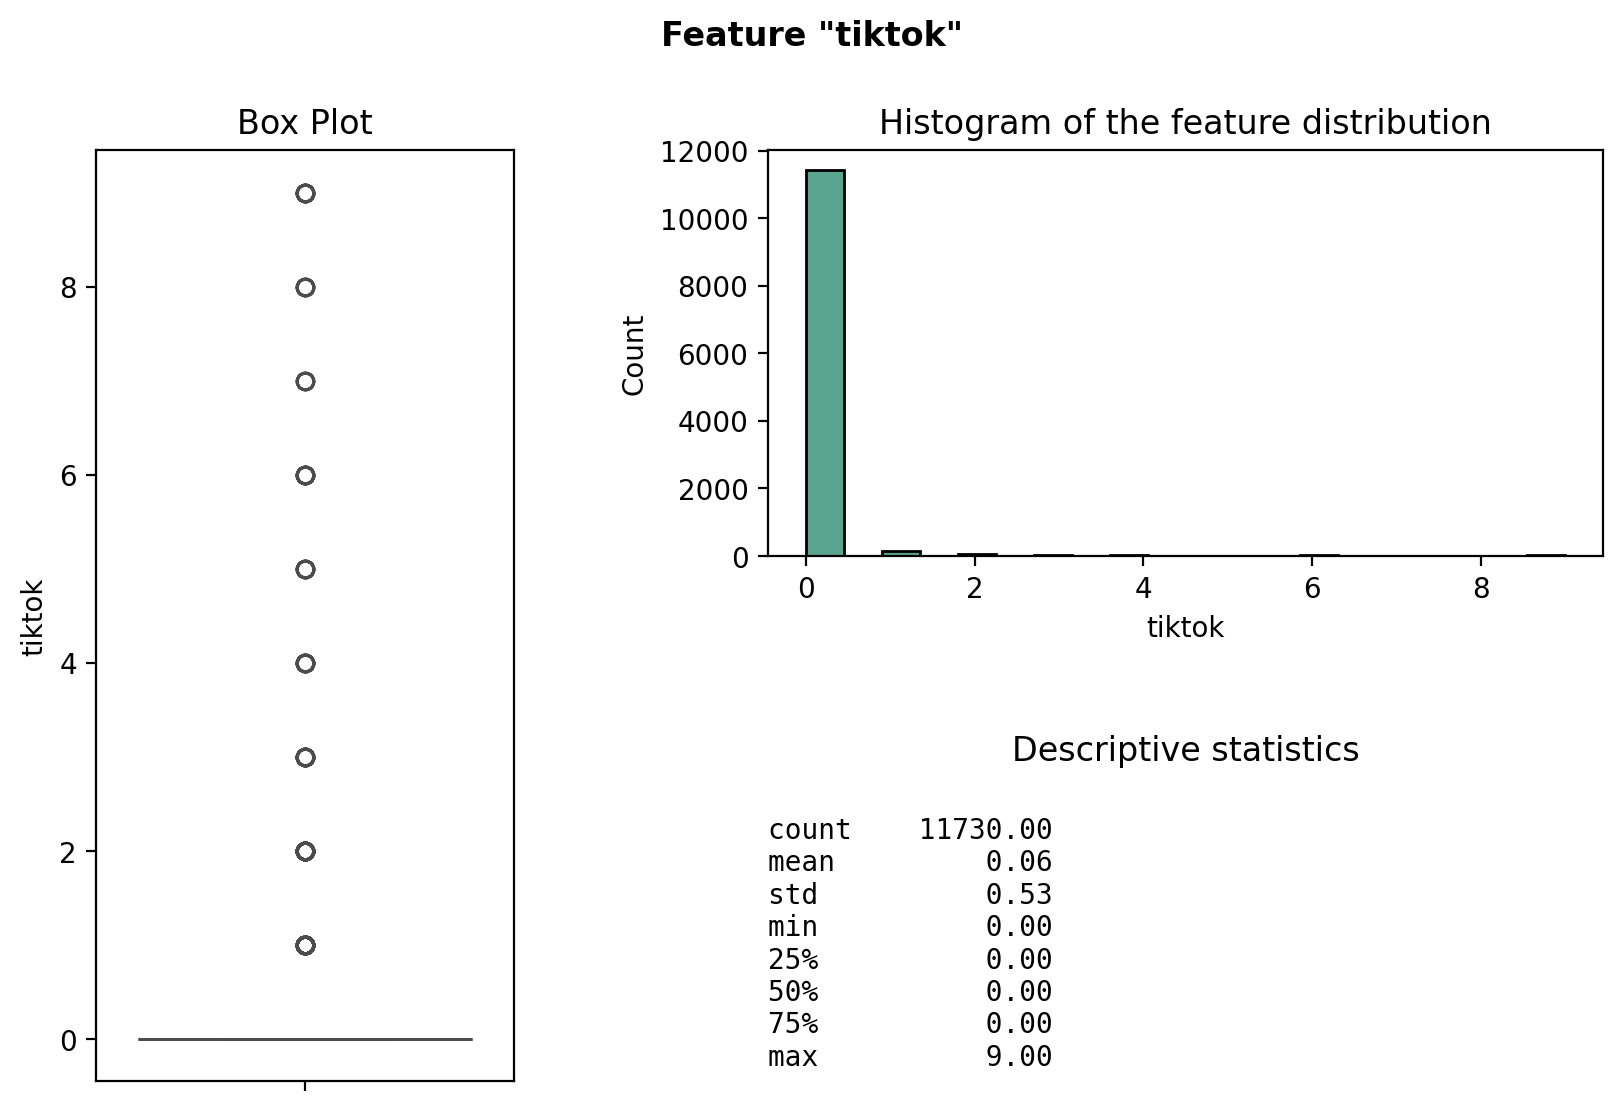

In [105]:
plot_numeric_feature(data=data, column="tiktok")

* The feature is numeric with values ranging from 0 to 9.
* The distribution is highly-skewed, but due to the presence of 0 values we cannot use log-transformation.
* Most of the values are 0.

**Features `youtube_x`**

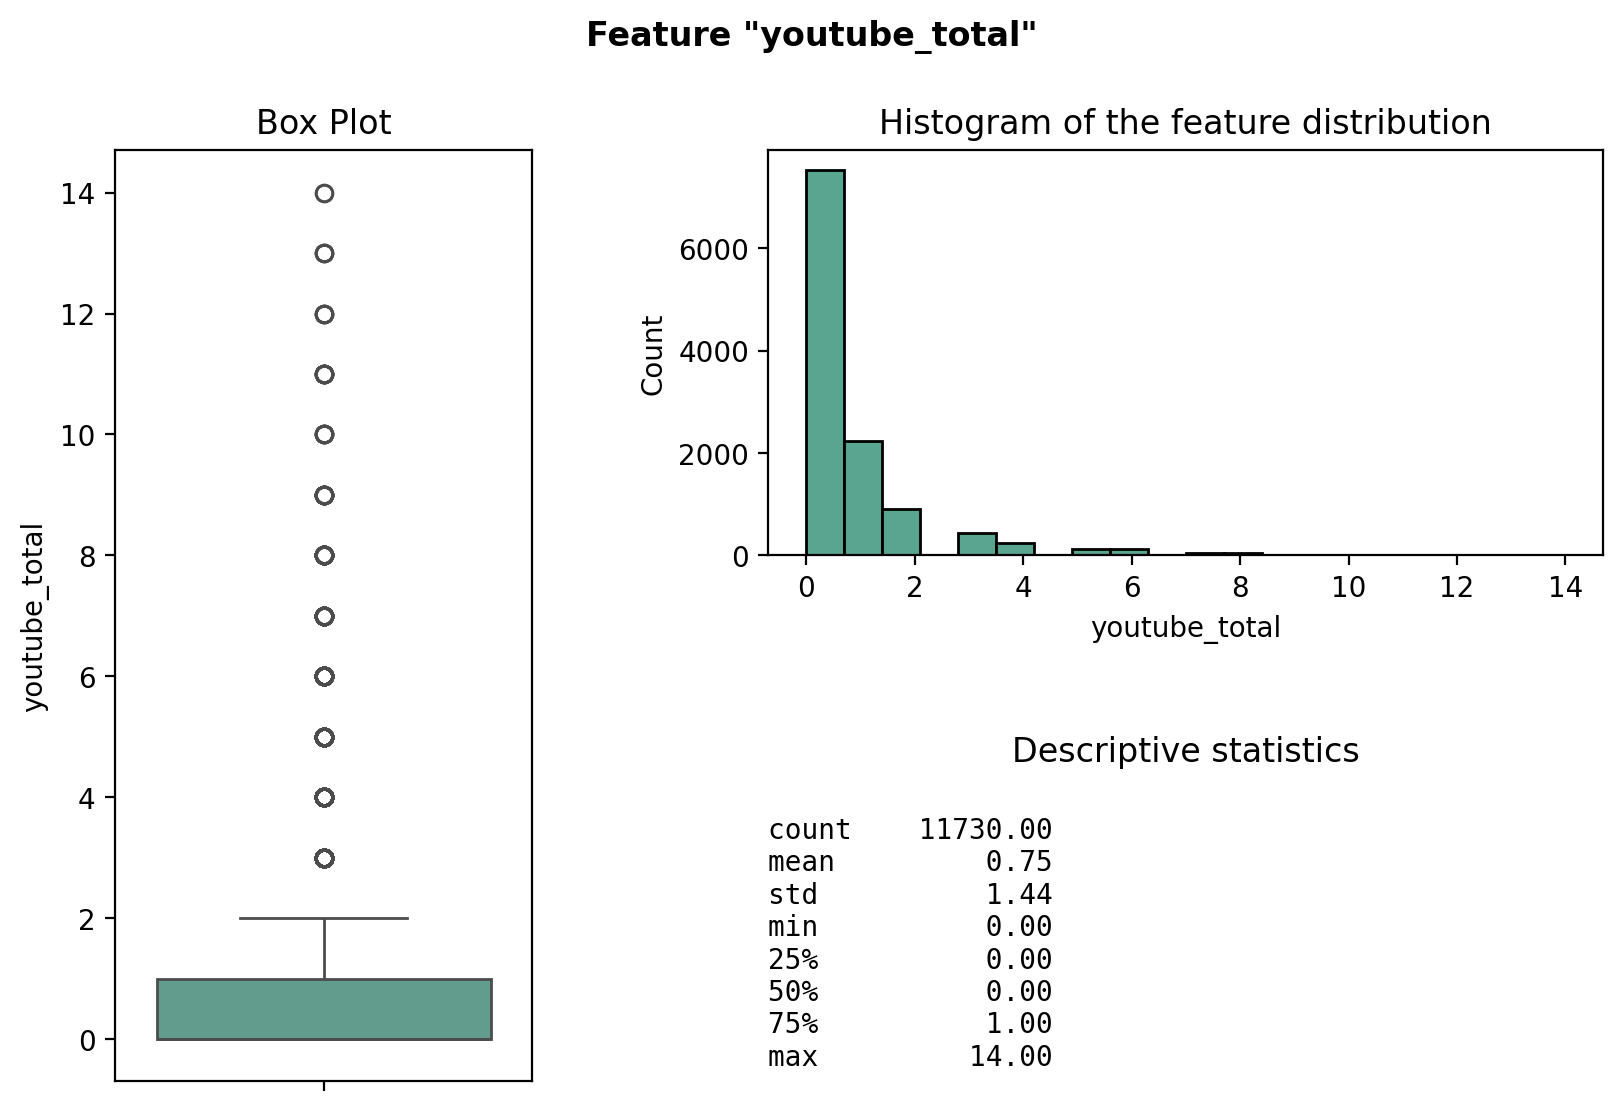

In [106]:
plot_numeric_feature(data=data, column="youtube_total")

* The feature is numeric with values ranging from 0 to 14.
* This feauture is a sum of the features `youtube_mobile`, `youtube_desktop`, `youtube_tablet` and `youtube_ctv`. They will have very strong correlation, it is not a problem for Decision Tree based models, but still might be useful to remove multi-collinearity.

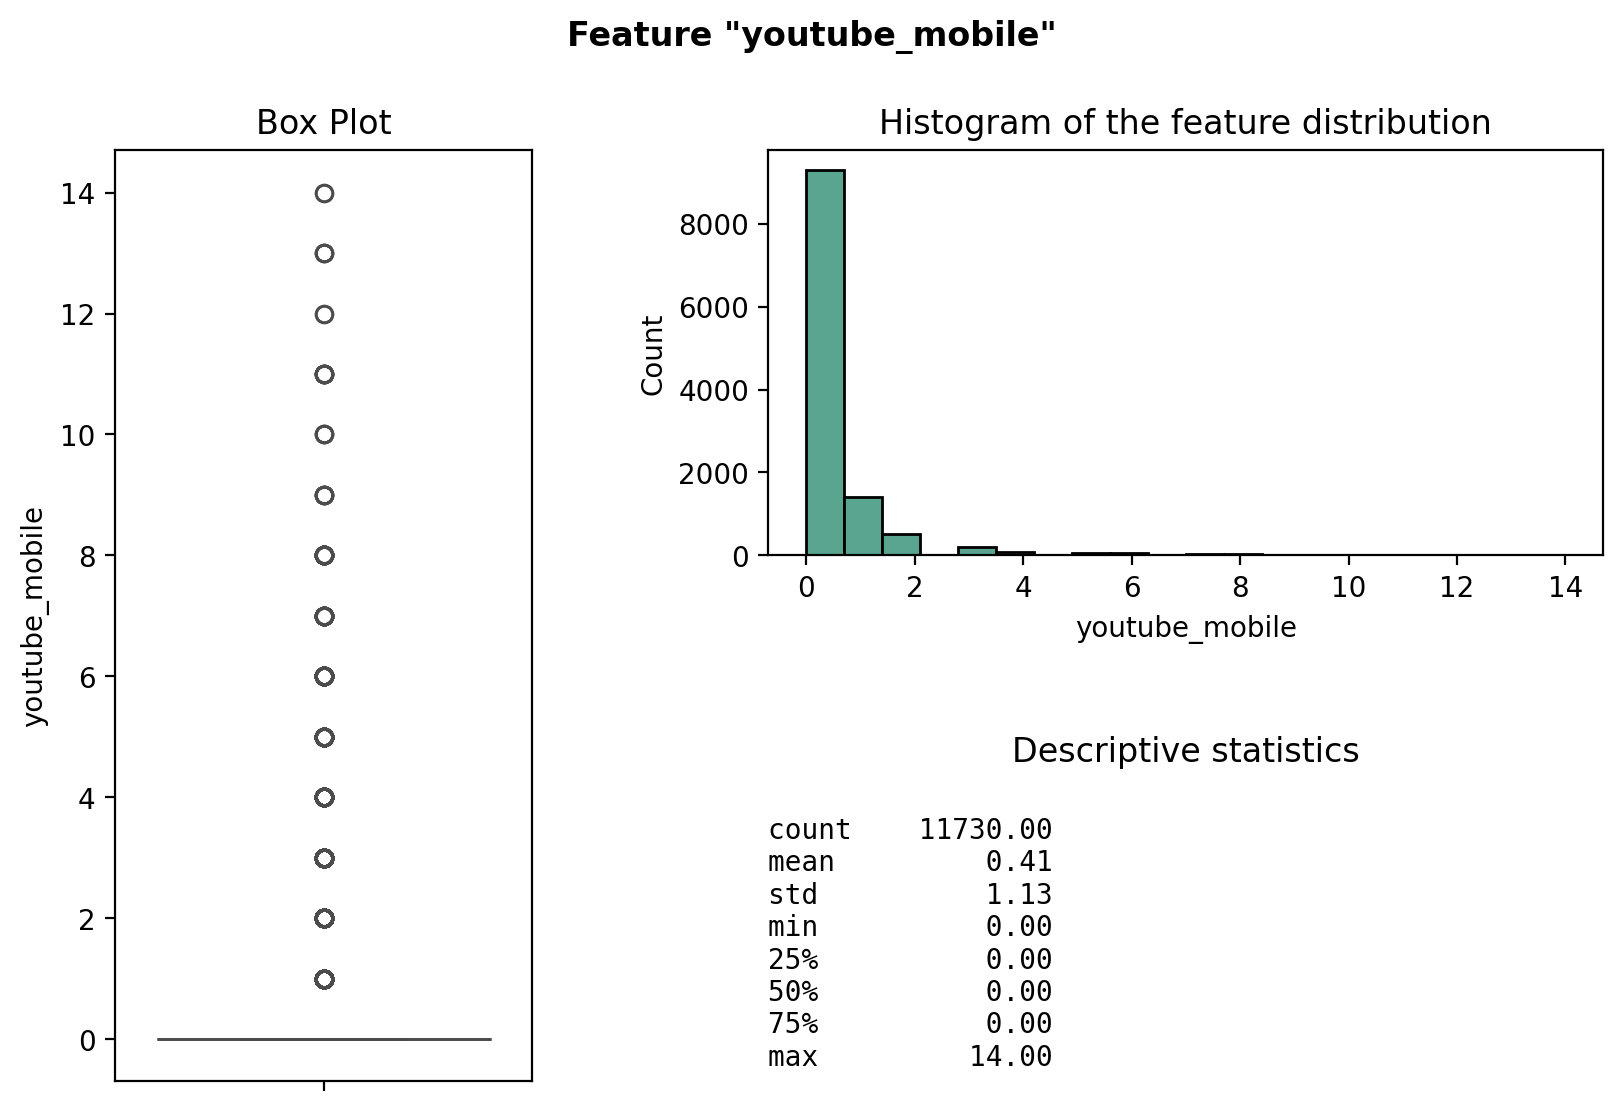

In [107]:
plot_numeric_feature(data=data, column="youtube_mobile")

* The feature is numeric with values ranging from 0 to 14.
* This feature contributes the most to the `youtube_total` feature and their distributions look almost identical. Probably, this feature will not be useful for modelling.

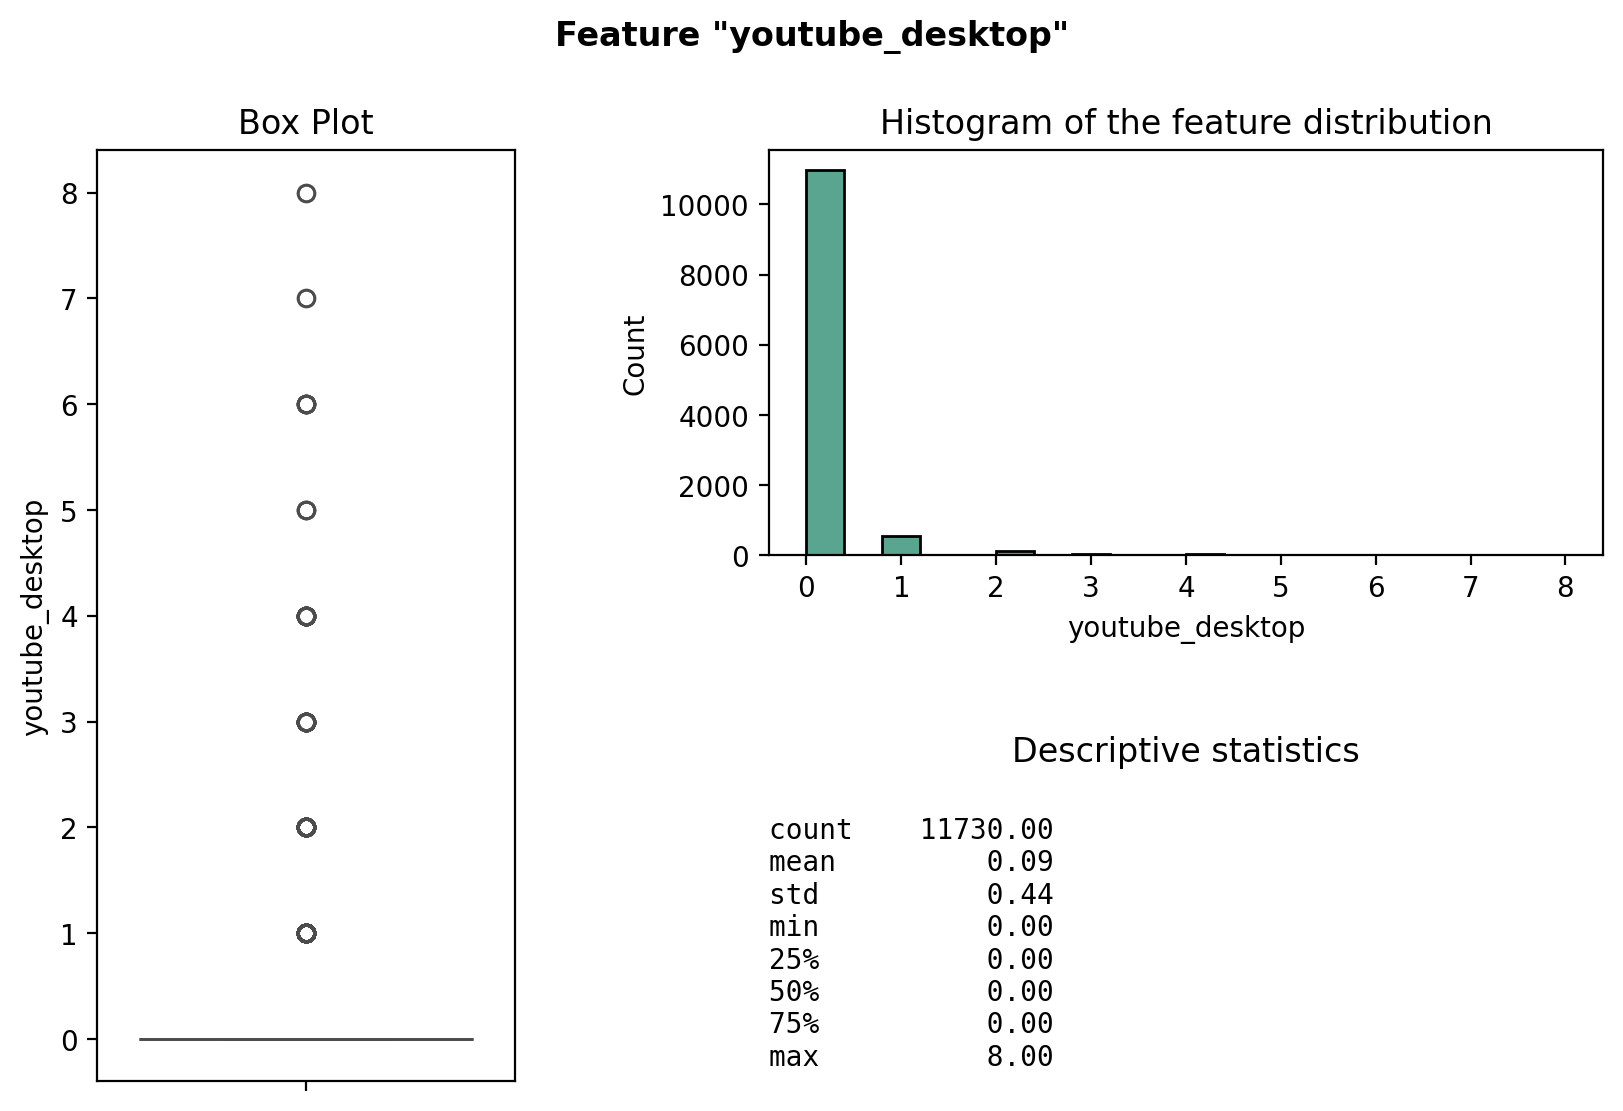

In [108]:
plot_numeric_feature(data=data, column="youtube_desktop")

* The feature is numeric with values ranging from 0 to 8.
* This feature contributes to the `youtube_total` feature. Probably, this feature will not be useful for modelling.

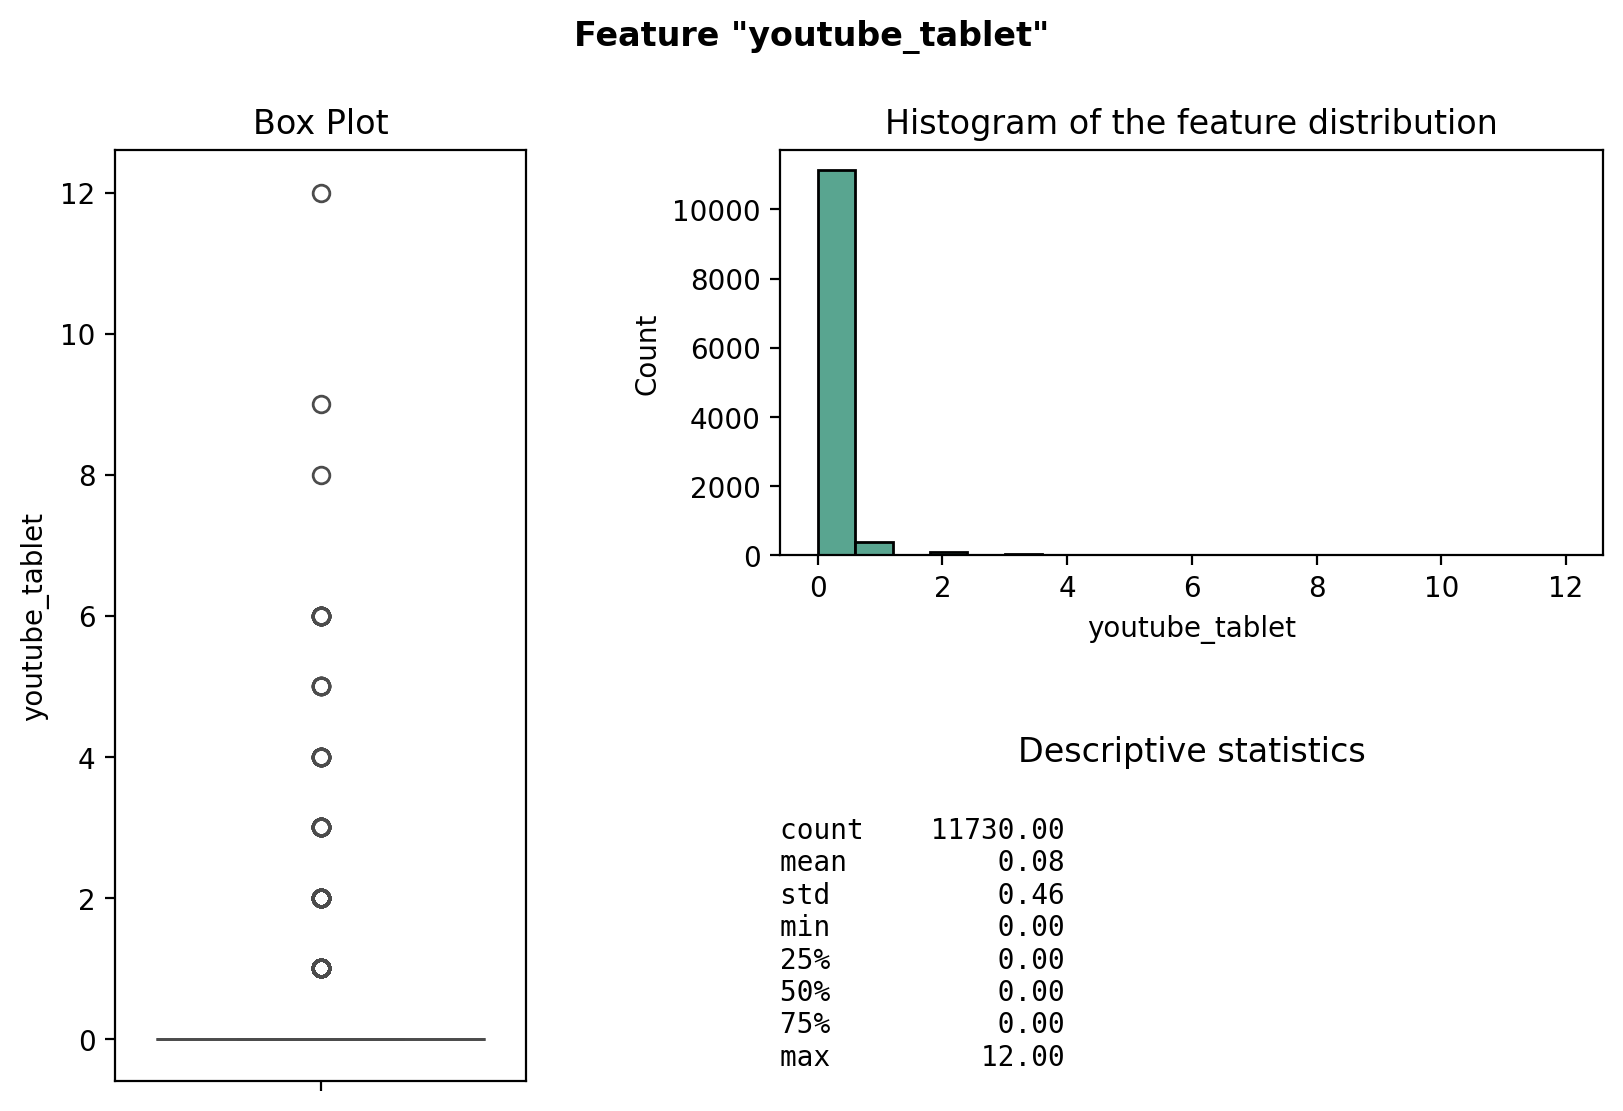

In [109]:
plot_numeric_feature(data=data, column="youtube_tablet")

* The feature is numeric with values ranging from 0 to 12.
* This feature contributes to the `youtube_total` feature. Probably, this feature will not be useful for modelling.

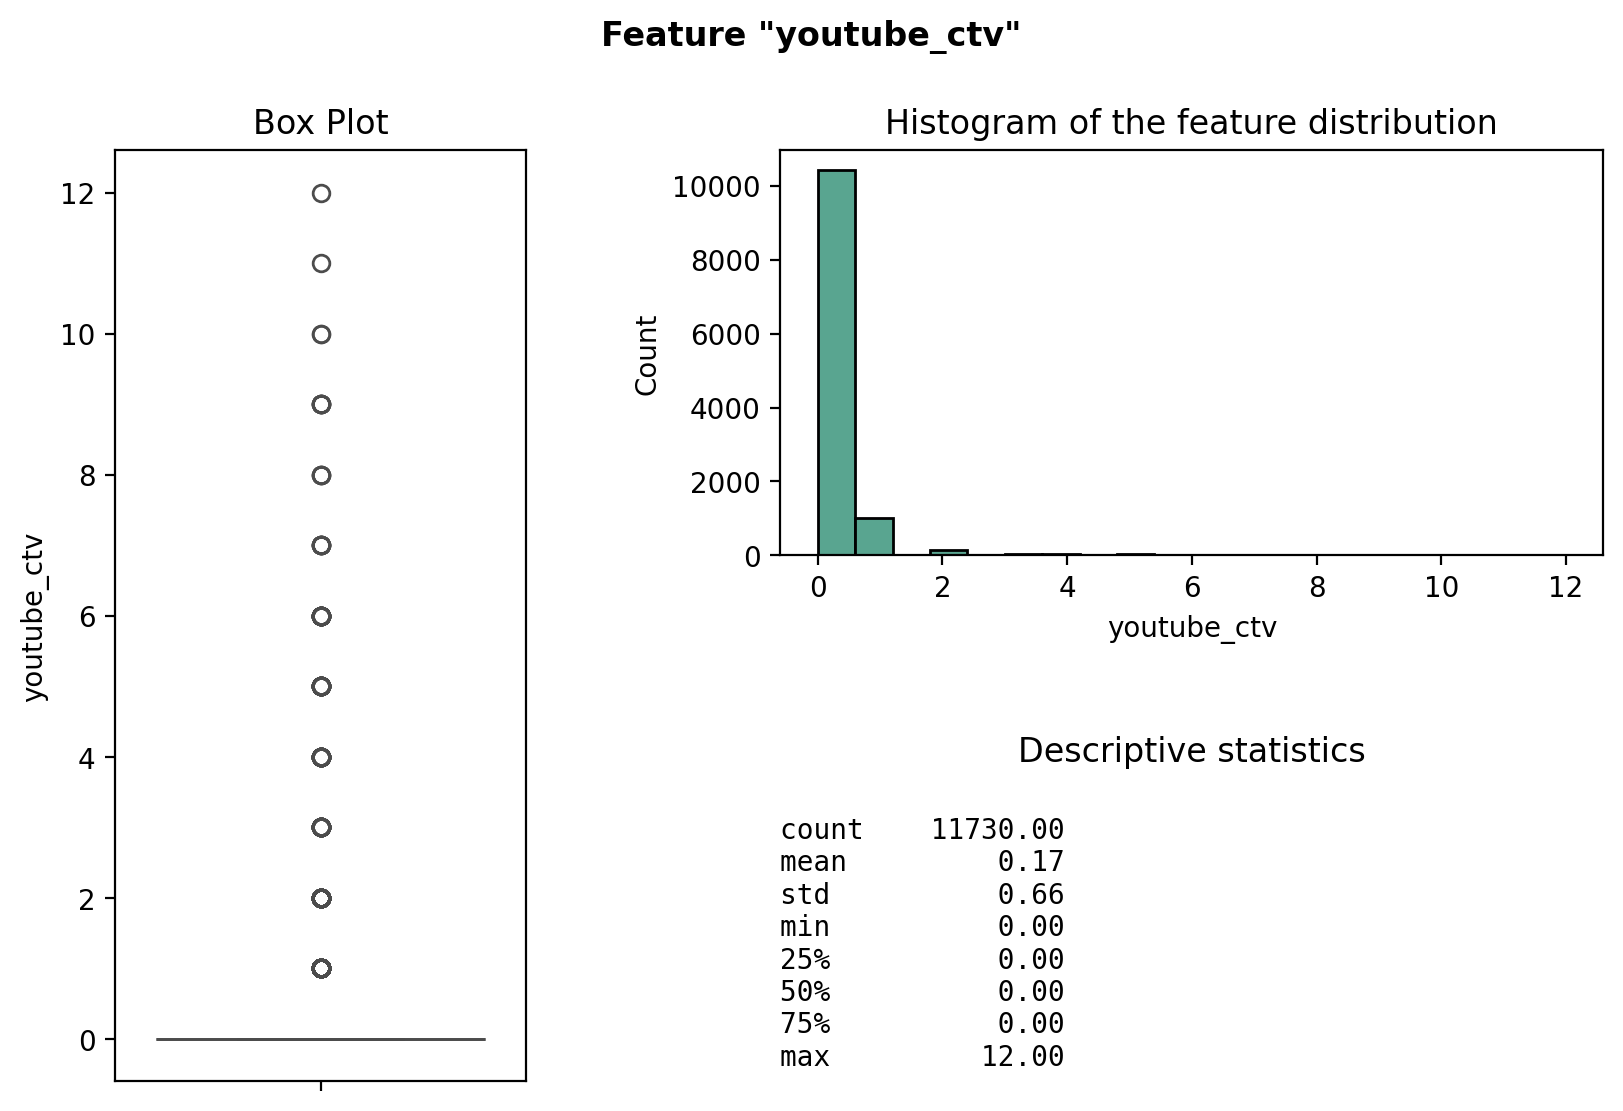

In [110]:
plot_numeric_feature(data=data, column="youtube_ctv")

* The feature is numeric with values ranging from 0 to 12.
* This feature contributes to the `youtube_total` feature. Probably, this feature will not be useful for modelling.

**Feature `pinterest`**

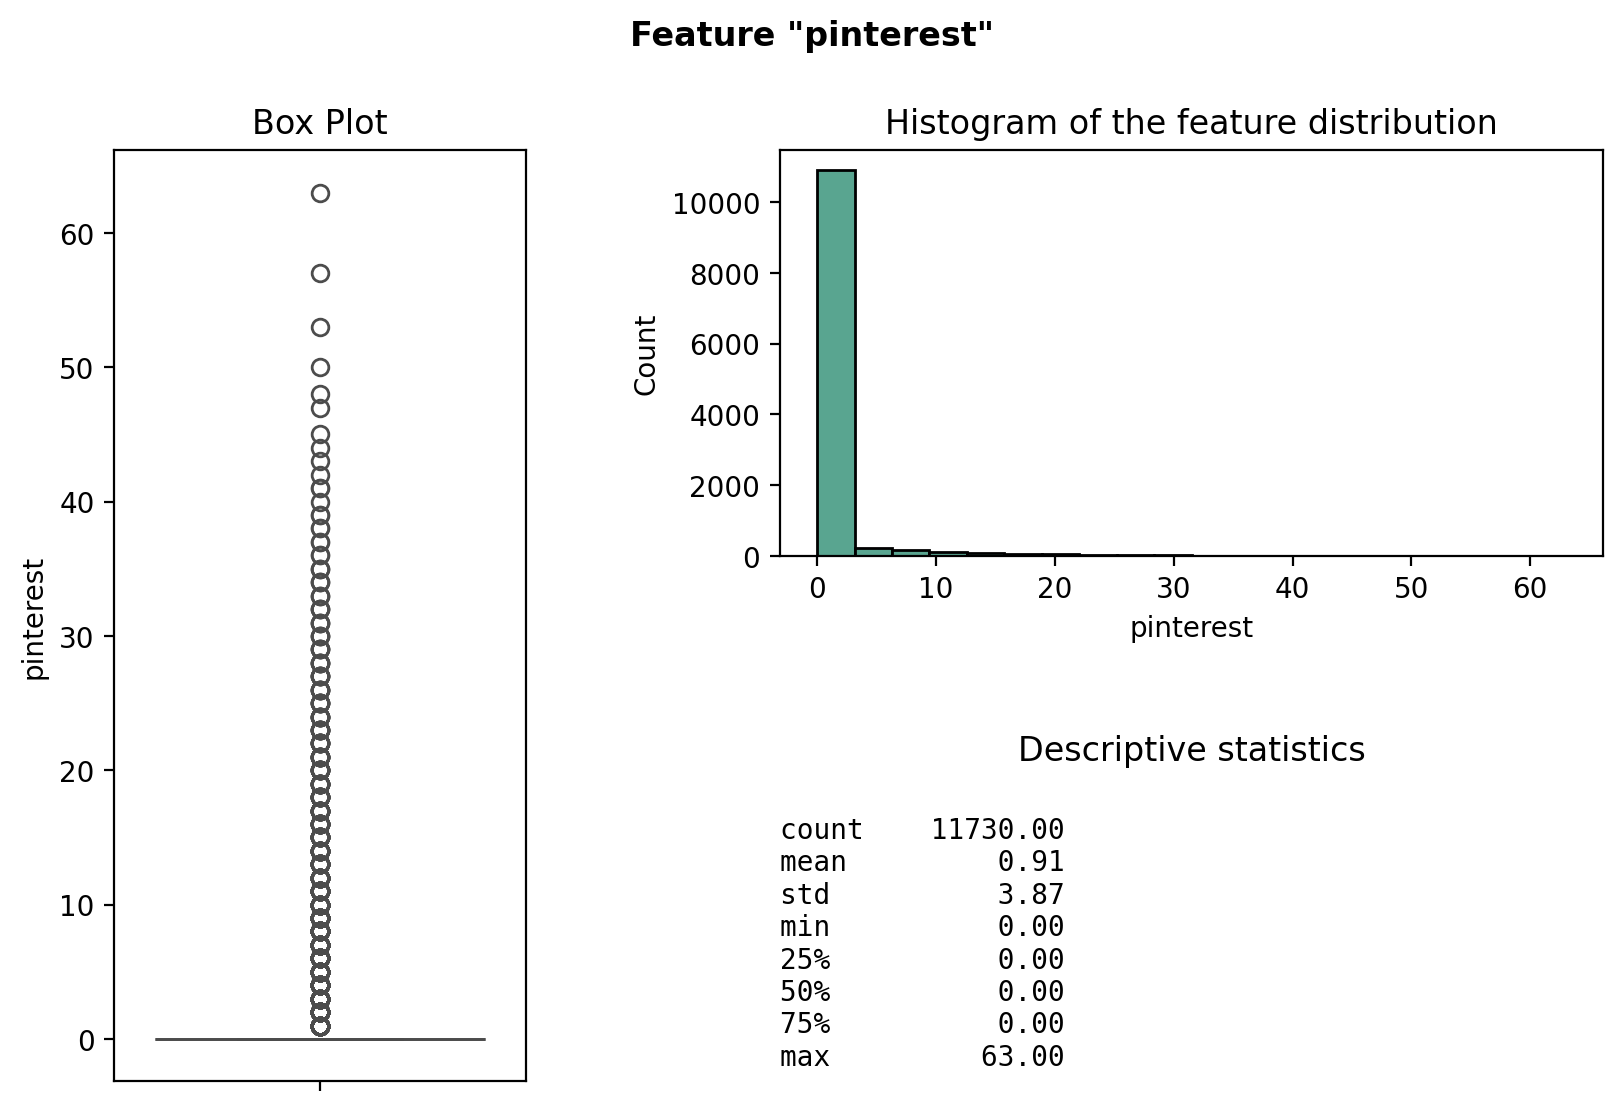

In [111]:
plot_numeric_feature(data=data, column="pinterest")

* The feature is numeric with values ranging from 0 to 63.
* The distribution is highly-skewed, but due to the presence of 0 values we cannot use log-transformation.
* Most of the values are 0.

#### Correlation Analysis

Due to the presence of categorical features and features that are non-normally distributed, we cannot use Pearson correlation coefficient. We will use more advanced method of correlation analysis that can capture even non-linear relationships between features.

The phi_k coefficient ranges from 0 to 1, where 0 - no correlation, 1 - absolute correlation.

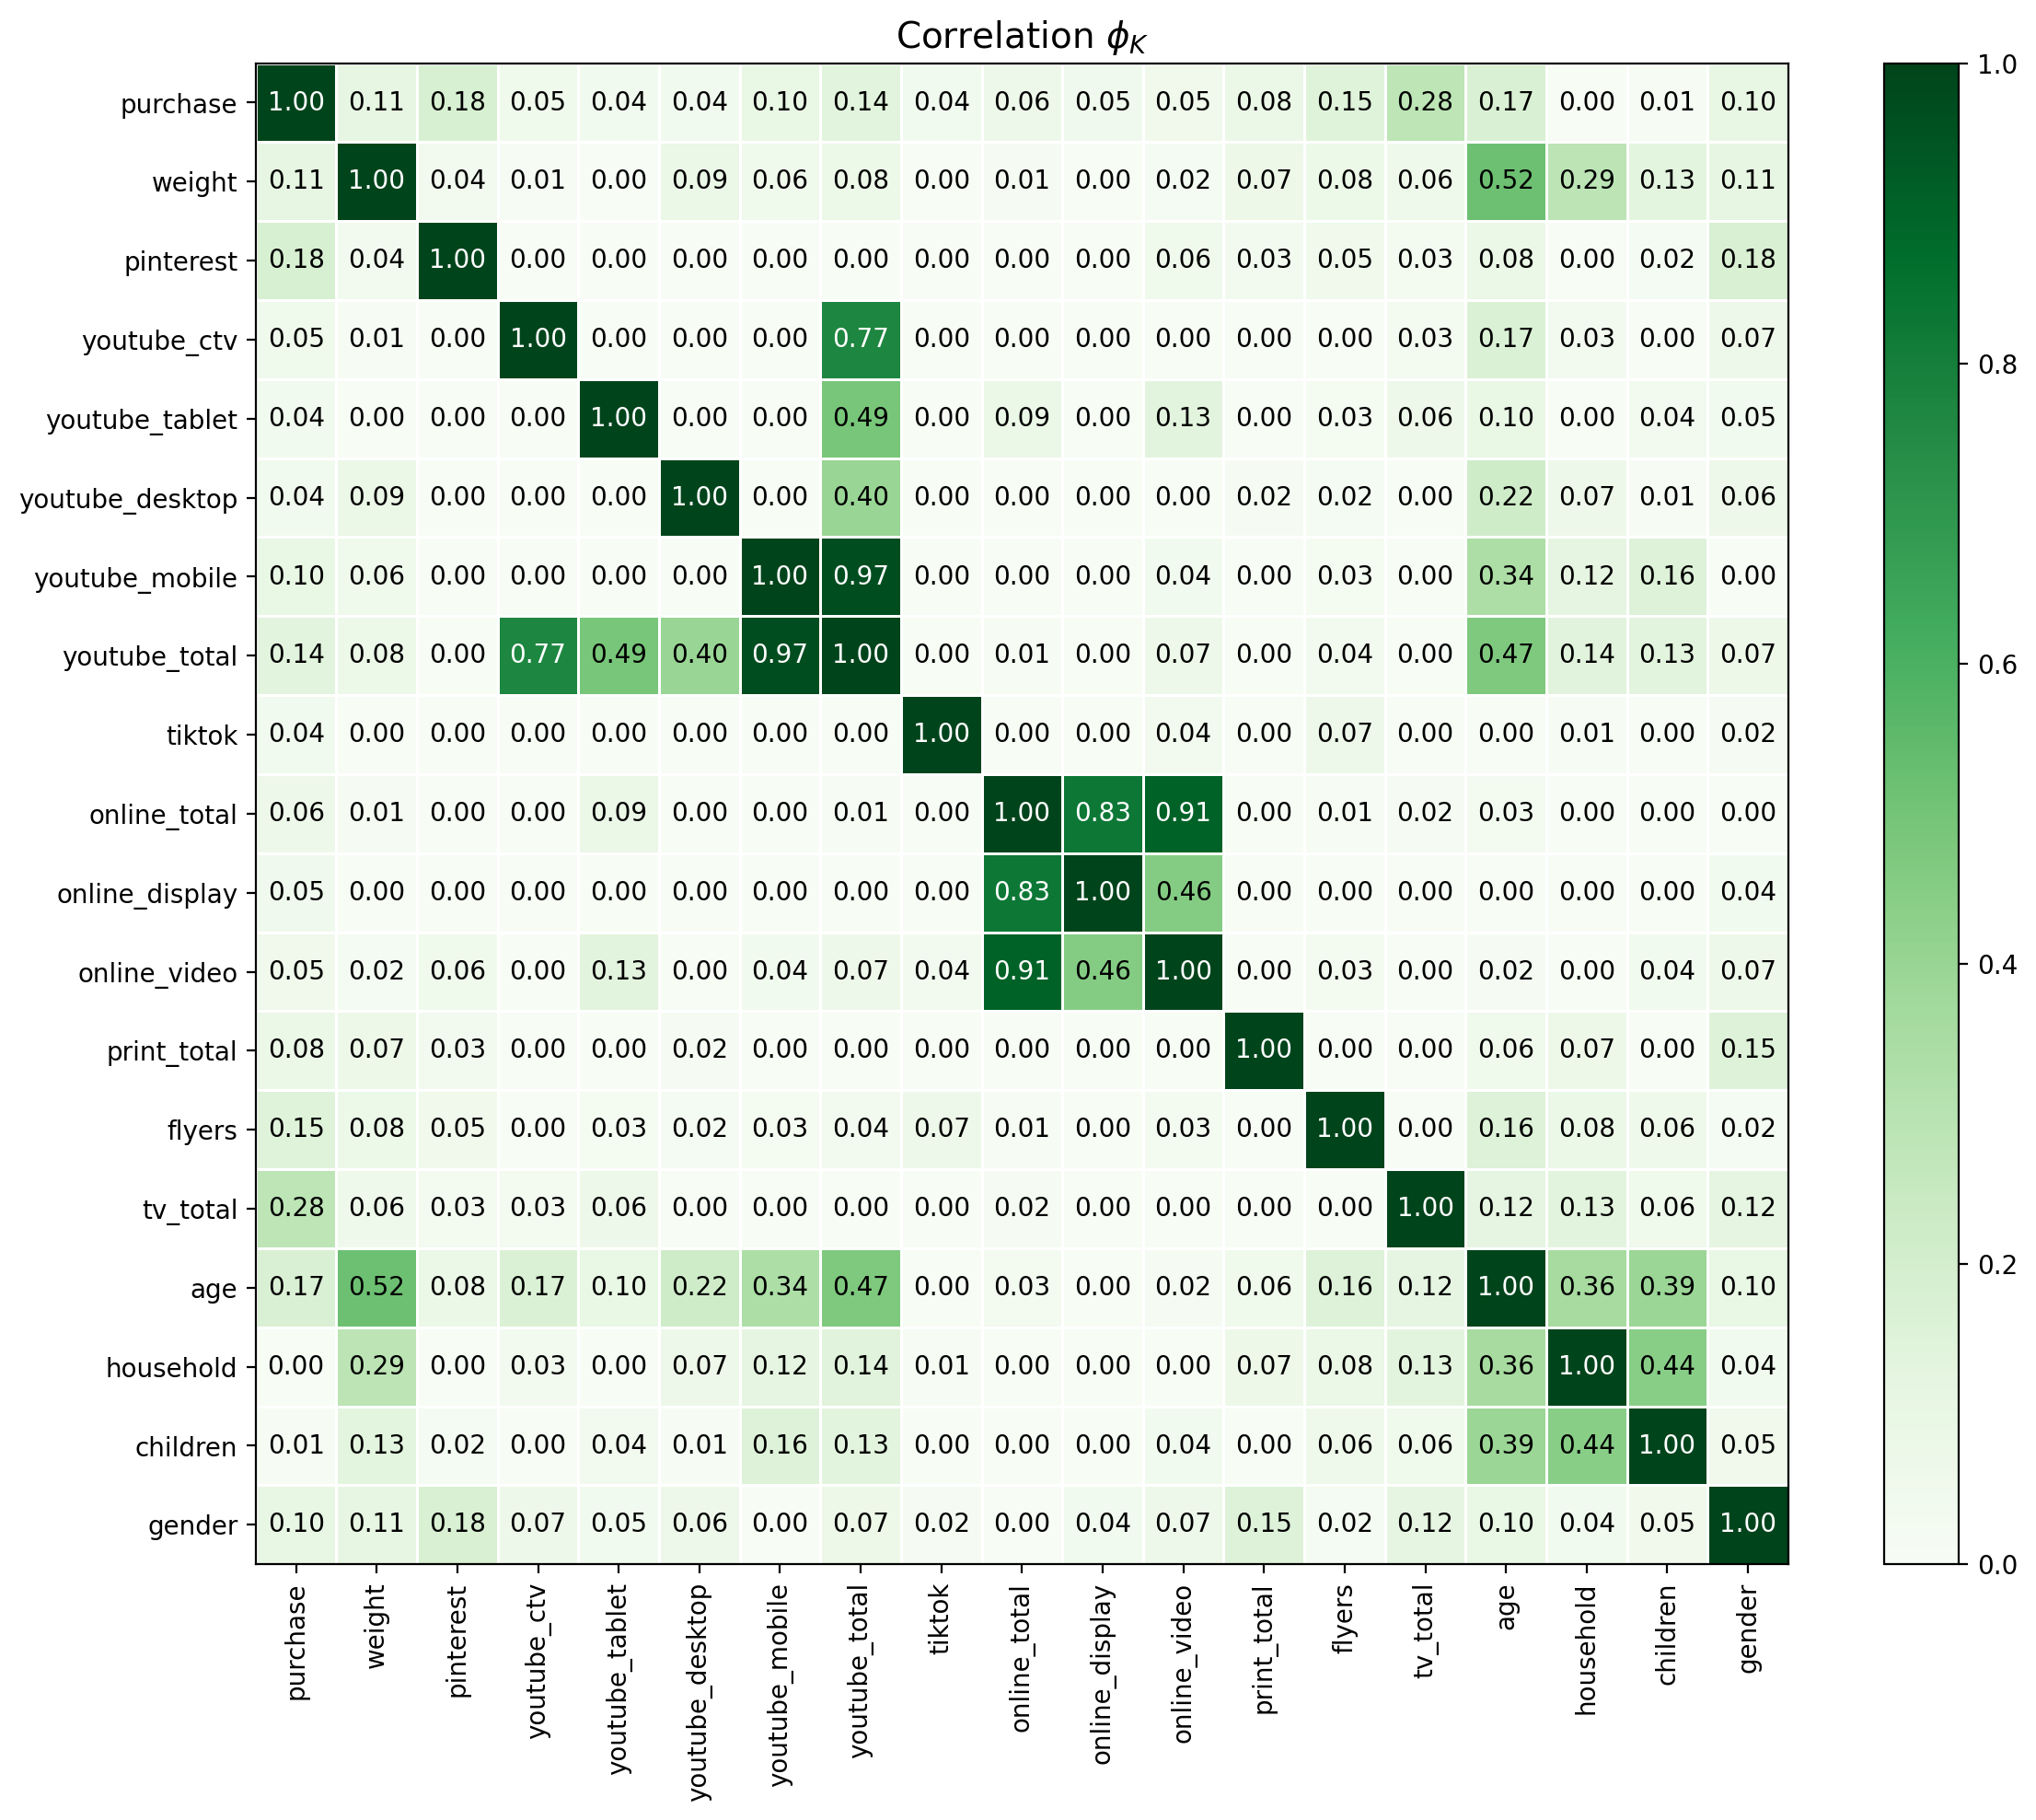

In [112]:
# Move the target for visual clarity
data = data[[col for col in data.columns if col != "purchase"] + ["purchase"]]

# Calculate correlation matrix
phik_overview = data.phik_matrix(
    interval_cols=["age", "tv_total", "flyers", "print_total", 
                   "online_video", "online_display", "online_total", 
                   "tiktok", "youtube_total", "youtube_mobile", 
                   "youtube_desktop", "youtube_tablet", "youtube_ctv", 
                   "pinterest", "weight"]
)

# Plot correlation matrix
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map="Greens",
    title=r"Correlation $\phi_K$",
    figsize=(12, 10)
)
plt.tight_layout()
plt.show()

* There are groups of multicollinear features. Decision Tree based models are not sensitive to multicollinearity, but linear models are.
* None of them have a strong relationship with the target.
* We don't know yet which group of features will show the best performance so we will keep them all and analyse feature importance later.

#### Class Overlap Analysis

Now we will apply dimensionality reduction technique - t-Distributed Stochastic Neighbor Embedding. t-SNE is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map. We will use 2D representation. The visualization will give us an idea if the classes are easily separatable or overlapping in the given feature space.

In [113]:
# Apply dimensionality reduction
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
y = data["purchase"]
X = data.drop(columns=["purchase"])

X_tsne = tsne.fit_transform(X)

tsne_df = pd.DataFrame(X_tsne, columns=["component_1", "component_2"])
tsne_df.index = X.index
tsne_data = pd.concat([tsne_df, y.reset_index(drop=True)], axis=1)
tsne_data.head()

component_1  component_2  purchase
1   -56.174976    48.749268       0.0
2   -67.652435    52.152790       1.0
4   -58.599770    48.086140       1.0
5   -56.332523    48.184170       0.0
6   -47.639767    47.375641       1.0

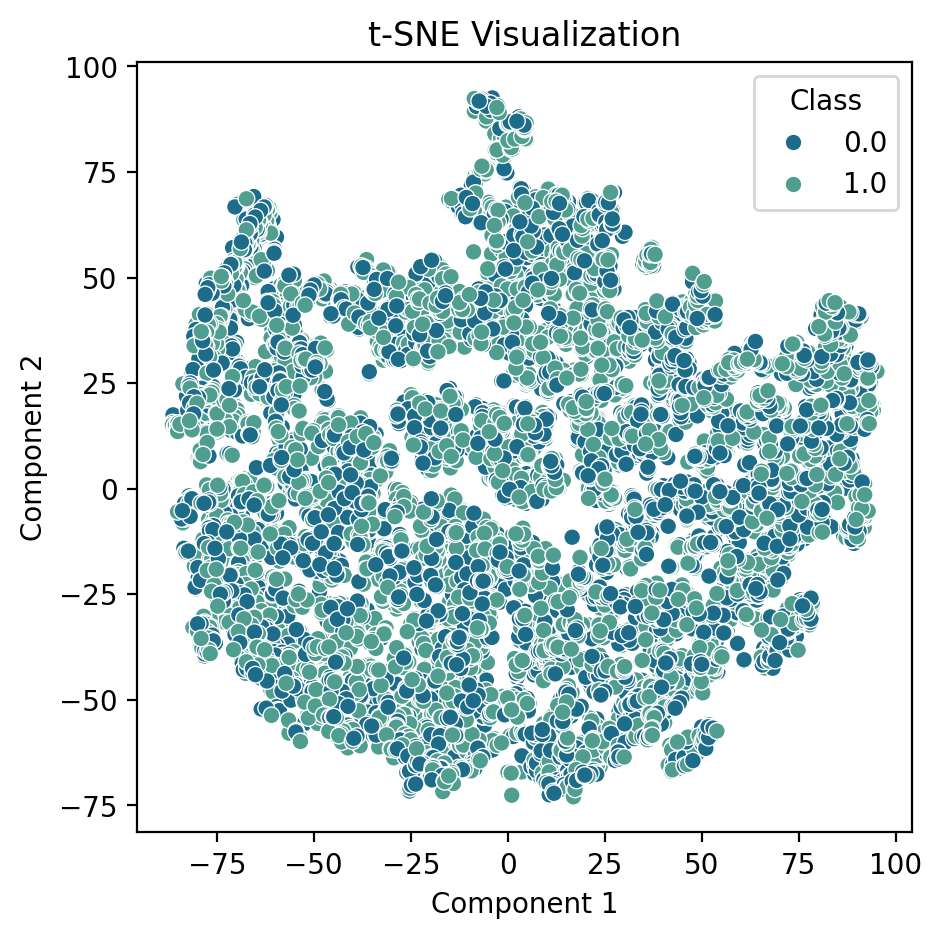

In [114]:
# Visualize feature space in 2D
plt.figure(figsize=(5, 5))
sns.scatterplot(
    data=tsne_data, 
    x="component_1", 
    y="component_2", 
    hue="purchase",
    legend="full",
    palette="crest_r"
)
    
plt.title(f"t-SNE Visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Class")
plt.show()

In the given feature space, classes do not form distinctive clusters, they overlap, which means that classification will be challenging.

#### Analysis Results

* Our target feature `purchase` shows light imbalance (43% of class 0 and 57% of class 1). We don't need apply upsampling techniques like SMOTE to balance out classes, stratification by target should be enough.
* The `weight` feature had logarithmic distribution and was highly skewed. We applied log-transformation to it.
* Other numeric features are also highly-skewed but we can't apply log-transformation because there are 0 values in them.
* For correlation analysis we used Phi_K matrix. There are groups of multicollinear features (`youtube_total` and `youtube_x`, `online_total` and `online_x`). None of them have a strong relationship with the target. We don't know yet which group of features will show the best performance so we will keep them all and analyse feature importance later.
* For class overlap analysis we used dimentionality reduction technique - tSNE. The analysis showed that in the given feature space classes overlap, which makes classification challenging.

## Machine Learning Model Development

Machine learning model can help to achieve different business objectives.

In the context of advertisement campaign evaluation, these three common scenarios can be used for metric selection:
1. Maximizing Return on Investment (ROI): When the goal is to target individuals most likely to convert, we prioritize **precision** (minimizing false positives). High precision ensures the campaign budget is allocated to likely customers.
2. Broad Awareness: For campaigns aiming to ensure all potential customers are reached, **recall** (minimizing false negatives) is prioritized. High recall ensures we reach as many potential customers as possible.
3. Balanced Perspective: When both precision and recall are critical, the **F1 score** is used. As the harmonic mean of precision and recall, the F1 score provides a balanced metric when the costs of false positives and false negatives are comparable.

In this research, we calculate all three metrics — precision, recall, and F1 score — but adopt the balanced perspective (F1 score) as the primary strategy. This strategy can be adjusted based on specific client requirements.

#### Data Split and Scaling

In [115]:
# Train/Test split
y = data["purchase"]
X = data.drop(columns=["purchase"])

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    random_state=RANDOM_STATE,
    test_size=0.3
)

print(f"Train Size: {X_train.shape}, {y_train.shape}")
print(f"Test Size: {X_test.shape}, {y_test.shape}")

Train Size: (8211, 18), (8211,)
Test Size: (3519, 18), (3519,)


In [116]:
# Prepare list of features for scaling
features_to_scale = X_train.drop(columns="gender").columns.tolist()
features_to_scale

['children',
 'household',
 'age',
 'tv_total',
 'flyers',
 'print_total',
 'online_video',
 'online_display',
 'online_total',
 'tiktok',
 'youtube_total',
 'youtube_mobile',
 'youtube_desktop',
 'youtube_tablet',
 'youtube_ctv',
 'pinterest',
 'weight']

In [117]:
# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform on train data
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])

# Only transform on test data
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

In [118]:
# Check the result
X_train.head()

gender  children  household       age  tv_total    flyers  print_total  \
3494       0 -0.279978  -0.168933  0.748381 -0.590478  0.403837     0.047728   
1027       0 -0.279978  -1.049080  0.489885 -0.682462  1.328776    -0.478306   
6008       0  2.486446   1.591361 -1.125711  0.145398 -0.521102    -0.478306   
8208       1 -0.279978  -0.168933 -2.159693 -0.130555 -0.521102     0.047728   
336        0 -0.279978  -1.049080 -0.802592  1.249213 -0.521102    -0.478306   

      online_video  online_display  online_total   tiktok  youtube_total  \
3494     -0.223075        -0.14891     -0.240961 -0.11686      -0.518568   
1027     -0.223075        -0.14891     -0.240961 -0.11686      -0.518568   
6008      0.621011        -0.14891      0.396658 -0.11686       0.177974   
8208      1.465097        -0.14891      1.034278 -0.11686      -0.518568   
336      -0.223075        -0.14891     -0.240961 -0.11686       0.177974   

      youtube_mobile  youtube_desktop  youtube_tablet  youtube_ctv  pinterest  \
3494       -0.359798        -0.212172       -0.179203    -0.251462  -0.237546   
1027       -0.359798        -0.212172       -0.179203    -0.251462  -0.237546   
6008       -0.359798         2.164563       -0.179203    -0.251462  -0.237546   
8208       -0.359798        -0.212172       -0.179203    -0.251462  -0.237546   
336         0.530052        -0.212172       -0.179203    -0.251462  -0.237546   

        weight  
3494 -0.398586  
1027 -0.512004  
6008 -0.031600  
8208  1.449993  
336   0.623022

In [119]:
# Prepare variable to store model metrics
cross_validation_info = {}

In [120]:
# Create StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

#### Models with Default Parameters

**Logistic Regression**

Logistic Regression is a linear model and requires handling multicollinearity.

In [121]:
# Remove multicollinear total features
X_train_no_total = X_train.drop(columns=["online_total", "youtube_total"])

# Train and cross-validate model
logreg1_model = LogisticRegression(random_state=RANDOM_STATE)
logreg1_model.fit(X_train_no_total, y_train)

logreg1_f1, logreg1_precision, logreg1_recall = calculate_metrics_cv(
    model=logreg1_model,
    X=X_train_no_total,
    y=y_train,
    cv=cv
)

# Save model info
cross_validation_info["LogReg (no multicollinear total)"] = {
    "F1": logreg1_f1, 
    "Precision": logreg1_precision, 
    "Recall": logreg1_recall
}

F1:        [0.7215 0.7196 0.7224 0.7147 0.6914], mean = 0.7139
Precision: [0.741  0.7323 0.7348 0.7422 0.706 ], mean = 0.7313
Recall:    [0.703  0.7073 0.7105 0.6891 0.6774], mean = 0.6975


In [122]:
# Remove multicollinear channel features
X_train_no_multi_channels = X_train.drop(
    columns=[
        "online_video", "online_display", 
        "youtube_mobile", "youtube_desktop", 
        "youtube_tablet", "youtube_ctv"
    ]
)

# Train and cross-validate model
logreg2_model = LogisticRegression(random_state=RANDOM_STATE)
logreg2_model.fit(X_train_no_multi_channels, y_train)

logreg2_f1, logreg2_precision, logreg2_recall = calculate_metrics_cv(
    model=logreg2_model,
    X=X_train_no_multi_channels,
    y=y_train,
    cv=cv
)

# Save model info
cross_validation_info["LogReg (no multicollinear channels)"] = {
    "F1": logreg2_f1, 
    "Precision": logreg2_precision, 
    "Recall": logreg2_recall
}

F1:        [0.724  0.7166 0.7227 0.7178 0.6913], mean = 0.7145
Precision: [0.7427 0.7285 0.7343 0.7477 0.7048], mean = 0.7316
Recall:    [0.7062 0.7051 0.7115 0.6902 0.6784], mean = 0.6983


**K Nearest Neighbors (kNN)**

In [123]:
# Train and cross-validate model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

knn_f1, knn_precision, knn_recall = calculate_metrics_cv(
    model=knn_model,
    X=X_train,
    y=y_train,
    cv=cv
)

# Save model info
cross_validation_info["K Nearest Neighbors"] = {
    "F1": knn_f1, 
    "Precision": knn_precision, 
    "Recall": knn_recall
}

F1:        [0.6519 0.6583 0.6568 0.6634 0.643 ], mean = 0.6547
Precision: [0.6751 0.6764 0.6711 0.6849 0.6798], mean = 0.6775
Recall:    [0.6303 0.641  0.6432 0.6432 0.61  ], mean = 0.6335


**Support Vector Machine (SVM)**

In [124]:
# Train and cross-validate model
svm_model = SVC(random_state=RANDOM_STATE)
svm_model.fit(X_train, y_train)

svm_f1, svm_precision, svm_recall = calculate_metrics_cv(
    model=svm_model,
    X=X_train,
    y=y_train,
    cv=cv
)

# Save model info
cross_validation_info["Support Vector Machine"] = {
    "F1": svm_f1, 
    "Precision": svm_precision, 
    "Recall": svm_recall
}

F1:        [0.7055 0.7064 0.7125 0.6879 0.6859], mean = 0.6996
Precision: [0.766  0.7539 0.7751 0.7681 0.7478], mean = 0.7622
Recall:    [0.6538 0.6645 0.6592 0.6229 0.6335], mean = 0.6468


**Gradient Boosting - XGBoost**

In [125]:
# Train and cross-validate model
xgb_model = XGBClassifier(random_state=RANDOM_STATE, verbosity=0)
xgb_model.fit(X_train, y_train)

xgb_f1, xgb_precision, xgb_recall = calculate_metrics_cv(
    model=xgb_model,
    X=X_train,
    y=y_train,
    cv=cv
)

# Save model info
cross_validation_info["XGBoost"] = {
    "F1": xgb_f1, 
    "Precision": xgb_precision, 
    "Recall": xgb_recall
}

F1:        [0.7031 0.7212 0.701  0.6992 0.6787], mean = 0.7006
Precision: [0.7346 0.7526 0.7276 0.7364 0.7198], mean = 0.7342
Recall:    [0.6741 0.6923 0.6763 0.6656 0.6421], mean = 0.6701


**Gradient Boosting - LightGBM**

In [126]:
# Train and cross-validate model
lgbm_model = LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
lgbm_model.fit(X_train, y_train)

lgbm_f1, lgbm_precision, lgbm_recall = calculate_metrics_cv(
    model=lgbm_model,
    X=X_train,
    y=y_train,
    cv=cv
)

# Save model info
cross_validation_info["LightGBM"] = {
    "F1": lgbm_f1, 
    "Precision": lgbm_precision, 
    "Recall": lgbm_recall
}

F1:        [0.7072 0.7342 0.7034 0.7064 0.6895], mean = 0.7081
Precision: [0.7558 0.7856 0.7684 0.7695 0.7532], mean = 0.7665
Recall:    [0.6645 0.6891 0.6485 0.6528 0.6357], mean = 0.6581


**Gradient Boosting - CatBoost**

In [127]:
# Train and cross-validate model
cb_model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)
cb_model.fit(X_train, y_train)

cb_f1, cb_precision, cb_recall = calculate_metrics_cv(
    model=cb_model,
    X=X_train,
    y=y_train,
    cv=cv
)

# Save model info
cross_validation_info["CatBoost"] = {
    "F1": cb_f1, 
    "Precision": cb_precision, 
    "Recall": cb_recall
}

F1:        [0.7227 0.7357 0.7134 0.7081 0.6979], mean = 0.7156
Precision: [0.7649 0.7767 0.7575 0.7751 0.7497], mean = 0.7648
Recall:    [0.6848 0.6987 0.6741 0.6517 0.6528], mean = 0.6724


**Cross-Validation Results**

In [128]:
# Create DF with cross-validation results
cross_validation_df = pd.DataFrame(
    index=cross_validation_info.keys(),
    data=cross_validation_info.values()
)
cross_validation_df.sort_values(by="F1", ascending=False)

F1  Precision  Recall
CatBoost                             0.7156     0.7648  0.6724
LogReg (no multicollinear channels)  0.7145     0.7316  0.6983
LogReg (no multicollinear total)     0.7139     0.7313  0.6975
LightGBM                             0.7081     0.7665  0.6581
XGBoost                              0.7006     0.7342  0.6701
Support Vector Machine               0.6996     0.7622  0.6468
K Nearest Neighbors                  0.6547     0.6775  0.6335

CatBoost model with default parameters showed the best result during cross-validation. Logistic Regression is the close second. We will tune huperparameters for these two models and choose the model that will show the best metric after tuning.

#### Hyperparameter Tuning

**Gradient Boosting - CatBoost**

In [129]:
# Define optimization function
def objective_cb(trial: optuna.Trial) -> float:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    param_grid = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.01, 100, log=True),
        "random_strength": trial.suggest_float("random_strength", 0, 5),
        "max_depth": trial.suggest_int("max_depth", 3, 6)
    }
    model = CatBoostClassifier(
        **param_grid, 
        random_state=RANDOM_STATE, 
        verbose=0, 
        iterations=500
    )
    model.fit(X_train, y_train)
    
    f1_cv = cross_val_score(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring="f1").mean()
    
    return f1_cv

# Start optimization
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)
study.optimize(objective_cb, n_trials=50, n_jobs=1)
best_parameters_cb = study.best_params

print("Hyperparameters of the best performing model:\n", best_parameters_cb)

Hyperparameters of the best performing model:
 {'learning_rate': 0.02419822724018819, 'l2_leaf_reg': 10.942011271394673, 'random_strength': 4.384407513360387, 'max_depth': 4}


In [130]:
# Train model with best hyperparameters
cb_tuned_model = CatBoostClassifier(
    **best_parameters_cb,
    random_state=RANDOM_STATE, 
    verbose=0, 
    iterations=500
)
cb_tuned_model.fit(X_train, y_train)

# Cross-validation
cb_tuned_f1, cb_tuned_precision, cb_tuned_recall = calculate_metrics_cv(
    model=cb_tuned_model,
    X=X_train,
    y=y_train,
    cv=cv
)

# Save model info
cross_validation_info["CatBoost Tuned"] = {
    "F1": cb_tuned_f1, 
    "Precision": cb_tuned_precision, 
    "Recall": cb_tuned_recall
}

F1:        [0.7324 0.7369 0.7191 0.7164 0.7059], mean = 0.7221
Precision: [0.7606 0.7617 0.7407 0.7602 0.7284], mean = 0.7503
Recall:    [0.7062 0.7137 0.6987 0.6774 0.6848], mean = 0.6962


**Logistic Regression**

In [131]:
# Define optimization function
def objective_logreg1(trial: optuna.Trial) -> float:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    param_grid = {
        "C": trial.suggest_float("C", 0.0001, 10, log=True),
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "solver": trial.suggest_categorical("solver", ["liblinear", "saga"])
    }
    model = LogisticRegression(
        **param_grid, 
        random_state=RANDOM_STATE
    )
    model.fit(X_train_no_total, y_train)
    
    f1_cv = cross_val_score(
        model,
        X_train_no_total,
        y_train,
        cv=cv,
        scoring="f1").mean()
    
    return f1_cv

# Start optimization
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)
study.optimize(objective_logreg1, n_trials=50, n_jobs=1)
best_parameters_logreg1 = study.best_params

print("Hyperparameters of the best performing model:\n", best_parameters_logreg1)

Hyperparameters of the best performing model:
 {'C': 0.000431443787682104, 'penalty': 'l2', 'solver': 'saga'}


In [132]:
# Train model with best hyperparameters
logreg1_tuned_model = LogisticRegression(
    **best_parameters_logreg1,
    random_state=RANDOM_STATE
)
logreg1_tuned_model.fit(X_train_no_total, y_train)

# Cross-validation
logreg1_tuned_f1, logreg1_tuned_precision, logreg1_tuned_recall = calculate_metrics_cv(
    model=logreg1_tuned_model,
    X=X_train_no_total,
    y=y_train,
    cv=cv
)

# Save model info
cross_validation_info["LogReg (no multicollinear total) Tuned"] = {
    "F1": logreg1_tuned_f1, 
    "Precision": logreg1_tuned_precision, 
    "Recall": logreg1_tuned_recall
}

F1:        [0.7393 0.7369 0.7303 0.7341 0.731 ], mean = 0.7343
Precision: [0.6161 0.6186 0.6132 0.6132 0.6088], mean = 0.614
Recall:    [0.9241 0.9113 0.9028 0.9145 0.9145], mean = 0.9134


In [133]:
# Define optimization function
def objective_logreg2(trial: optuna.Trial) -> float:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    param_grid = {
        "C": trial.suggest_float("C", 0.0001, 10, log=True),
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "solver": trial.suggest_categorical("solver", ["liblinear", "saga"])
    }
    model = LogisticRegression(
        **param_grid, 
        random_state=RANDOM_STATE
    )
    model.fit(X_train_no_multi_channels, y_train)
    
    f1_cv = cross_val_score(
        model,
        X_train_no_multi_channels,
        y_train,
        cv=cv,
        scoring="f1").mean()
    
    return f1_cv

# Start optimization
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)
study.optimize(objective_logreg2, n_trials=50, n_jobs=1)
best_parameters_logreg2 = study.best_params

print("Hyperparameters of the best performing model:\n", best_parameters_logreg2)

Hyperparameters of the best performing model:
 {'C': 0.00047693769246083035, 'penalty': 'l2', 'solver': 'saga'}


In [134]:
# Train model with best hyperparameters
logreg2_tuned_model = LogisticRegression(
    **best_parameters_logreg2,
    random_state=RANDOM_STATE
)
logreg2_tuned_model.fit(X_train_no_multi_channels, y_train)

# Cross-validation
logreg2_tuned_f1, logreg2_tuned_precision, logreg2_tuned_recall = calculate_metrics_cv(
    model=logreg2_tuned_model,
    X=X_train_no_multi_channels,
    y=y_train,
    cv=cv
)

# Save model info
cross_validation_info["LogReg (no multicollinear channels) Tuned"] = {
    "F1": logreg2_tuned_f1, 
    "Precision": logreg2_tuned_precision, 
    "Recall": logreg2_tuned_recall
}

F1:        [0.7385 0.7359 0.7298 0.7388 0.7311], mean = 0.7348
Precision: [0.6223 0.6236 0.617  0.6227 0.6147], mean = 0.6201
Recall:    [0.9081 0.8974 0.8932 0.9081 0.9017], mean = 0.9017


**Cross-Validation Results (Updated)**

In [135]:
# Create DF with cross-validation results
cross_validation_df = pd.DataFrame(index=cross_validation_info.keys(), data=cross_validation_info.values())
cross_validation_df.sort_values(by="F1", ascending=False)

F1  Precision  Recall
LogReg (no multicollinear channels) Tuned  0.7348     0.6201  0.9017
LogReg (no multicollinear total) Tuned     0.7343     0.6140  0.9134
CatBoost Tuned                             0.7221     0.7503  0.6962
CatBoost                                   0.7156     0.7648  0.6724
LogReg (no multicollinear channels)        0.7145     0.7316  0.6983
LogReg (no multicollinear total)           0.7139     0.7313  0.6975
LightGBM                                   0.7081     0.7665  0.6581
XGBoost                                    0.7006     0.7342  0.6701
Support Vector Machine                     0.6996     0.7622  0.6468
K Nearest Neighbors                        0.6547     0.6775  0.6335

Following the strategy we will choose Logistic Regression model trained on the dataset with `online_total` and `youtube_total` features and without their related features `online_video`, `online_display`, `youtube_mobile`, `youtube_desktop`, `youtube_tablet`, `youtube_ctv`.

In [136]:
# Create variable to store chosen model metrics
log_reg_metrics = {}

# Add cross-validation info
log_reg_metrics["cross_validation"] = {
    "F1": logreg1_tuned_f1, 
    "Precision": logreg1_tuned_precision, 
    "Recall": logreg1_tuned_recall
}

#### Model Testing

Let's see how well the model will generalize unseen data.

In [137]:
# Remove multicollinear features from test set
X_test = X_test.drop(
    columns=[
        "online_video", "online_display", 
        "youtube_mobile", "youtube_desktop", 
        "youtube_tablet", "youtube_ctv"
    ]
)

F1 test:        0.7293
Precision test: 0.6345
Recall test:    0.8574


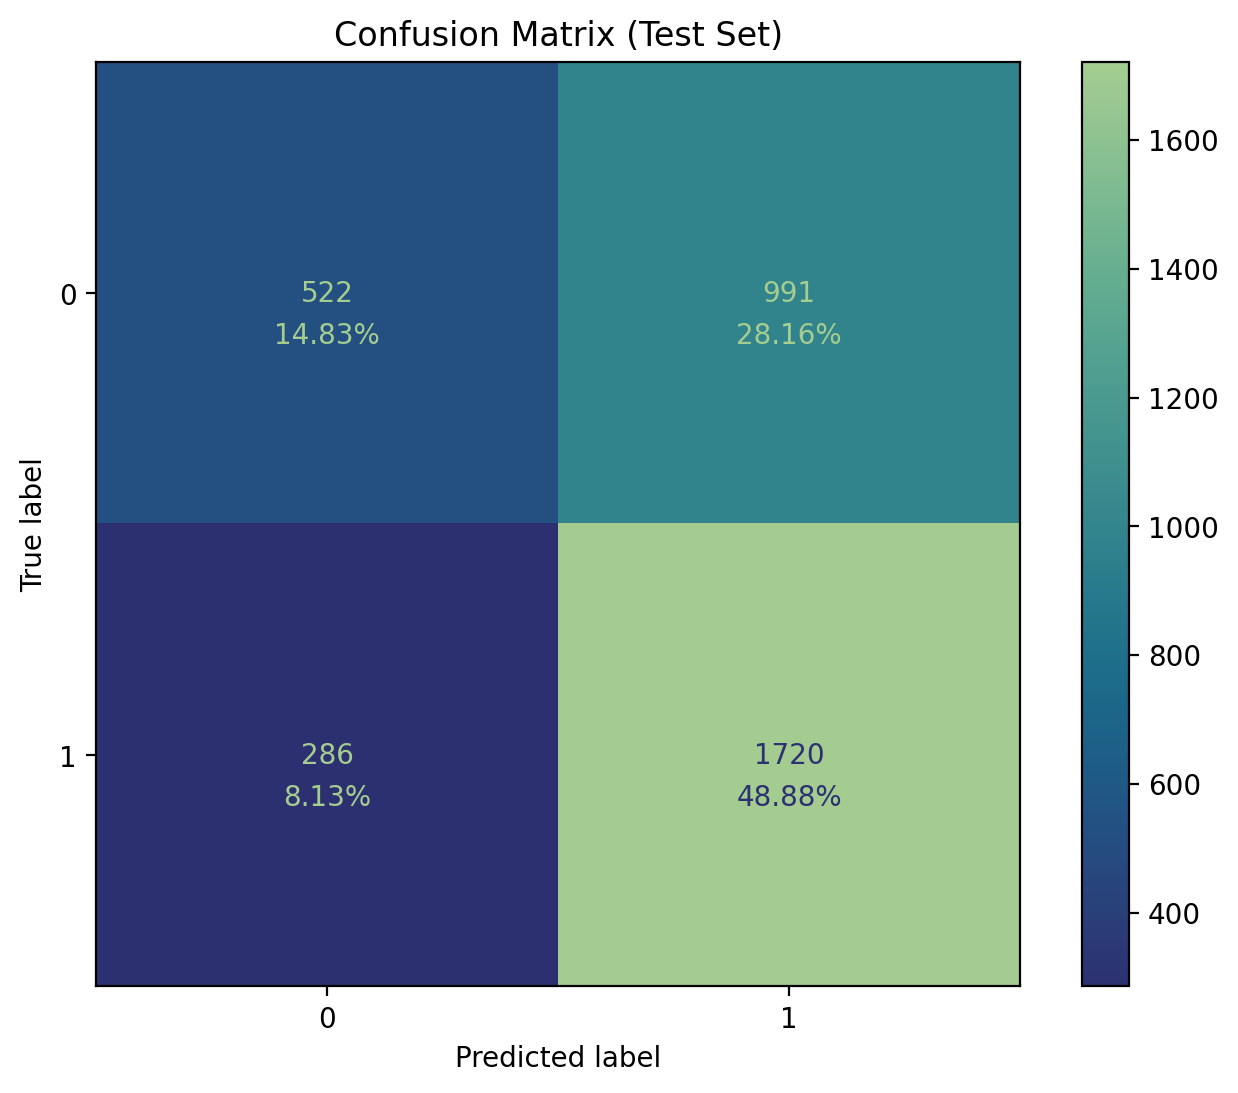

In [138]:
# Make predictions on test data
y_pred = logreg2_tuned_model.predict(X_test)

# Evaluate metrics
f1_test = f1_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)
print(f"F1 test:        {f1_test:.4f}")
print(f"Precision test: {precision_test:.4f}")
print(f"Recall test:    {recall_test:.4f}")

# Add test info
log_reg_metrics["test"] = {
    "F1": f1_test, 
    "Precision": precision_test, 
    "Recall": recall_test
}

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
display_labels = logreg2_tuned_model.classes_
total_predictions = np.sum(conf_matrix)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=display_labels)
disp.plot(ax=ax, cmap="crest_r", values_format="")
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        percentage = conf_matrix[i, j] / total_predictions * 100
        original_text = ax.texts[i * conf_matrix.shape[1] + j]
        original_color = original_text.get_color()
        ax.annotate(
            f'{percentage:.2f}%',
            xy=(j, i),
            xycoords="data",
            textcoords="offset points",
            xytext=(0, -18),
            ha="center",
            color=original_color,
            fontsize=10
        )
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [139]:
# Show feature odd ratio
features = []
coefficients = []
odds_ratios = []
for feature_number, feature_name in enumerate(X_test.columns):
    features.append(feature_name)
    coef = logreg2_tuned_model.coef_[0, feature_number]
    coefficients.append(coef)
    exp_weight = math.exp(coef)
    odds_ratios.append(exp_weight)

log_reg_odds = pd.DataFrame({
    "Feature": features, 
    "log_reg_coefficient": 
    coefficients, 
    "odds_ratio": odds_ratios
})
log_reg_odds = log_reg_odds.sort_values(by="odds_ratio", ascending=False)
log_reg_odds

Feature  log_reg_coefficient  odds_ratio
4        tv_total             0.307904    1.360571
10      pinterest             0.149811    1.161615
9   youtube_total             0.130138    1.138986
6     print_total             0.107768    1.113789
5          flyers             0.098139    1.103116
7    online_total             0.057204    1.058872
8          tiktok             0.023091    1.023359
2       household            -0.001611    0.998390
1        children            -0.014642    0.985465
0          gender            -0.028585    0.971820
3             age            -0.035373    0.965245
11         weight            -0.064878    0.937182

In [140]:
# Create DF with model metrics
log_reg_metrics_df = pd.DataFrame(
    index=log_reg_metrics.keys(), 
    data=log_reg_metrics.values()
)
log_reg_metrics_df

F1  Precision    Recall
cross_validation  0.734300   0.614000  0.913400
test              0.729277   0.634452  0.857428

The metrics on cross-validation and test sets are very similar, indicating that the model has not overfitted and demonstrates strong generalization capabilities.

## Research Conclusion

**Research Goal**

The objective of this study was to evaluate the efficiency of the XYZ advertisement campaign.

**Data Overview**

We analyzed two datasets: socio-demographic data and media contacts. The data was mostly clean, but the weight column contained 2713 corrupted values (17% of the dataset). This parameter is essential for scaling sample data to the population. Imputation attempts were unsuccessful, so we replaced corrupted values with 1 to maintain dataset integrity.

**Conversion Rate Analysis**
* Overall CR: 5.11%.
* Top-Performing Channels: Flyers (13.50%), Print (9.20%), and TikTok (5.98%).
* Channels like YouTube and Online were never used as standalone sources, making it impossible to evaluate their individual CR.<br>

**Media Channel Popularity**
* TV is the dominant channel, accounting for 63% of all interactions.
* The second most popular channel is print, contributing 7.78% of interactions.
* TikTok, despite having a relatively high conversion rate, is the least utilized channel, representing only 0.47% of all interactions.

**Demographic Insights**

* Age groups show varying preferences for media channels, highlighting the need for targeted strategies.
* Although the 51-60 age group generates the most interactions, the odds of purchase decrease by ~3.48% for each additional year of age.

**Customer Profiles**

* Organic Customers: Primarily women (65.3%), aged 17-40, without children.
* Acquired Customers: Predominantly men (55.5%), mid-to-elder aged, showing higher purchase likelihood post-advertisement.

**Machine Learning Model**

We developed a logistic regression model to predict purchase likelihood. Its simplicity and interpretability make it suitable for business applications.

Performance: 
* F1 Score = 0.73
* Precision = 0.63
* Recall = 0.86

Key Findings:
* Male customers have a higher conversion likelihood.
* TV interactions significantly increase purchase odds (+36.06%).
* Older age correlates with lower purchase likelihood.

**KEY POINTS** <br>
🚀 **Leverage Flyers**: High CR (13.50%), especially effective for the 71+ age group. <br>
🚀 **Utilize TikTok**: High CR (5.98%) but underused (0.47% of interactions). <br>
🚀 **Prioritize TV**: Dominates interactions (63%) and boosts purchase odds by 36.06%. <br>
🚀 **Focus on Male Customers**: Data and model indicate higher conversion likelihood for men.